### In this notebook, we will try to fine-tune the model which uses positions and formations. And create a framework that could draw insights from trained model and feed it to the LLM to get recommendations for team managers and coach

In [2]:
from glob import glob
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

In [ ]:
xtrain = pd.read_csv("player_pca_features_final_2425.csv")
ytrain = pd.read_csv("matchinfo_train2425.csv")

/mnt/d/mltorch/lib/python3.12/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


AM [ 2.03238432 -0.68129795]
CB [-4.09156909  1.39015186]
CM [ 0.25705013 -0.06793619]
DM [-1.97095965  0.68615281]
FW [ 4.92446877 -1.73996182]
LB [-3.33364212 -1.45059825]
LM [-0.24670563 -2.4182594 ]
LW [ 2.02234622 -3.43292381]
LWB [-2.24591424 -1.87816619]
RB [-1.74359951  3.1959108 ]
RM [1.29926756 2.07059027]
RW [3.71488932 1.45461715]
RWB [-0.6180161   2.87172071]


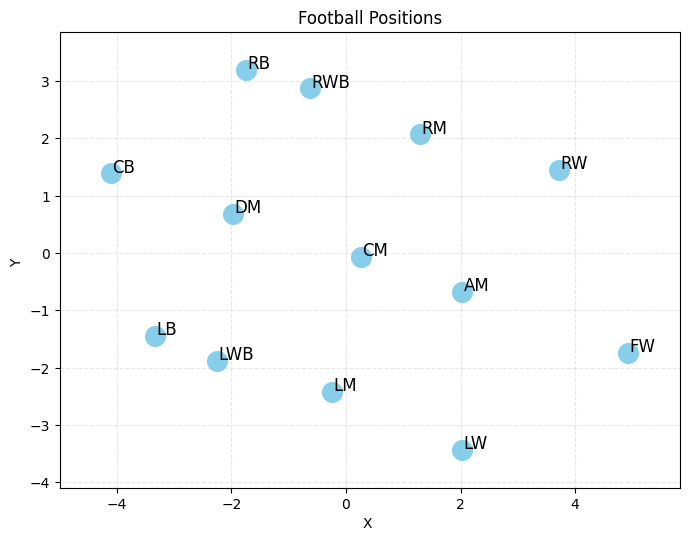

In [5]:
# functions from previous notebook
# get coordinates for each position
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

distances = {
    ('FW','AM'): 4,
    ('FW','LW'): 2,
    ('FW','RW'): 2,
    ('FW','LM'): 5,
    ('FW','RM'): 5,
    ('FW','LWB'): 7,
    ('FW','RWB'): 7,
    ('FW','LB'): 8,
    ('FW','RB'): 8,
    ('FW','CM'): 7,
    ('FW','DM'): 8,
    ('FW','CB'): 9,

    ('AM','LW'): 2,
    ('AM','RW'): 2,
    ('AM','LM'): 2,
    ('AM','RM'): 2,
    ('AM','LWB'): 5,
    ('AM','RWB'): 5,
    ('AM','LB'): 6,
    ('AM','RB'): 6,
    ('AM','CM'): 1,
    ('AM','DM'): 4,
    ('AM','CB'): 7,

    ('CM','LW'): 4,
    ('CM','RW'): 4,
    ('CM','LM'): 2,
    ('CM','RM'): 2,
    ('CM','LWB'): 4,
    ('CM','RWB'): 4,
    ('CM','LB'): 4,
    ('CM','RB'): 4,
    ('CM','DM'): 1,
    ('CM','CB'): 6,

    ('DM','LW'): 6,
    ('DM','RW'): 6,
    ('DM','LM'): 4,
    ('DM','RM'): 4,
    ('DM','LWB'): 2,
    ('DM','RWB'): 2,
    ('DM','LB'): 3,
    ('DM','RB'): 3,
    ('DM','CB'): 2,

    ('CB','LW'): 7,
    ('CB','RW'): 7,
    ('CB','LM'): 6,
    ('CB','RM'): 6,
    ('CB','LWB'): 4,
    ('CB','RWB'): 4,
    ('CB','LB'): 2,
    ('CB','RB'): 2,

    ('LB','LW'): 5,
    ('LB','RW'): 9,
    ('LB','LM'): 2,
    ('LB','RM'): 6,
    ('LB','LWB'): 1,
    ('LB','RWB'): 5,
    ('LB','RB'): 4,

    ('RB','LW'): 9,
    ('RB','RW'): 5,
    ('RB','LM'): 6,
    ('RB','RM'): 2,
    ('RB','LWB'): 5,
    ('RB','RWB'): 1,

    ('RWB','LW'): 8,
    ('RWB','RW'): 4,
    ('RWB','LM'): 5,
    ('RWB','RM'): 1,
    ('RWB','LWB'): 4,

    ('LWB','LW'): 4,
    ('LWB','RW'): 8,
    ('LWB','LM'): 1,
    ('LWB','RM'): 5,

    ('LM','LW'): 1,
    ('LM','RW'): 7,
    ('LM','RM'): 4,

    ('RM','LW'): 7,
    ('RM','RW'): 1,

    ('RW','LW'): 4
}

def positions_to_coords(dist_dict, n_dim=2, random_state=42):
    # 1. 获取所有位置
    positions = sorted({p for pair in dist_dict.keys() for p in pair})
    n_pos = len(positions)
    pos_index = {p:i for i,p in enumerate(positions)}
    
    # 2. 构建完整距离矩阵（未知距离用较大值或平均值）
    dist_matrix = np.zeros((n_pos,n_pos))
    for i in range(n_pos):
        for j in range(n_pos):
            if i == j:
                dist_matrix[i,j] = 0
            else:
                key1 = (positions[i], positions[j])
                key2 = (positions[j], positions[i])
                if key1 in dist_dict:
                    dist_matrix[i,j] = dist_dict[key1]
                elif key2 in dist_dict:
                    dist_matrix[i,j] = dist_dict[key2]
                else:
                    dist_matrix[i,j] = 1.0 

    mds = MDS(n_components=n_dim, dissimilarity='precomputed', random_state=random_state)
    coords = mds.fit_transform(dist_matrix)
    
    # 4. 输出字典
    pos_coords = {p: coords[pos_index[p]] for p in positions}
    return pos_coords

coords = positions_to_coords(distances, n_dim=2)
for k,v in coords.items():
    print(k, v)
# 提取所有 x, y
xs = [x for x, y in coords.values()]
ys = [y for x, y in coords.values()]

# 创建图
plt.figure(figsize=(8,6))
plt.title("Football Positions")
plt.xlabel("X ")
plt.ylabel("Y ")

# 画每个位置
for pos, (x, y) in coords.items():
    plt.scatter(x, y, s=200, c='skyblue')
    plt.text(x+0.02, y+0.02, pos, fontsize=12)

# 自动设置坐标范围并加边距
x_margin = (max(xs)-min(xs))*0.1
y_margin = (max(ys)-min(ys))*0.1
plt.xlim(min(xs)-x_margin, max(xs)+x_margin)
plt.ylim(min(ys)-y_margin, max(ys)+y_margin)

plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True, linestyle='--', alpha=0.3)

plt.show()

mpos = {5: [0.4,0.25,0.15,0.12,0.08 ], 4: [0.5,0.25,0.15,0.1], 3:[0.5,0.3,0.2], 2:[0.7,0.3]}

# add formations to xtrain
def get_team_formation(row):
    match_id = row['match_id']
    team_name = row['team_name']
    match_info = ytrain[ytrain['match_id'] == match_id]
    if not match_info.empty:
        if team_name == match_info['team1'].values[0]:
            return match_info['team1_formation'].values[0]
        elif team_name == match_info['team2'].values[0]:
            return match_info['team2_formation'].values[0]
    return None

# add home score and away score to ytrain
def get_home_away_score(row):
    scoreline = row['scoreline']
    scores = scoreline.split('-')
    if len(scores) != 2:
        scores = scoreline.split('–')
        if len(scores) != 2:
            return None, None
    
    homeaway = row['match_id'].split('_')[-1]
    if homeaway == 'H':
        home_score = int(scores[0].strip())
        away_score = int(scores[1].strip())
    else:
        away_score = int(scores[0].strip())
        home_score = int(scores[1].strip())

    return home_score, away_score

formations_positions = {
    "4-5-1": ["GK", "RB", "CB", "CB", "LB", "RM", "CM", "CM", "CM", "LM", "FW"],
    "5-4-1": ["GK", "RB", "CB", "CB", "CB", "LB", "RM", "CM", "CM", "LM", "FW"],
    "3-2-4-1": ["GK", "CB", "CB", "CB", "DM", "DM", "RM", "CM", "CM", "LM", "FW"],
    "4-1-4-1": ["GK", "RB", "CB", "CB", "LB", "DM", "RM", "CM", "CM", "LM", "FW"],
    "4-2-3-1": ["GK", "RB", "CB", "CB", "LB", "DM", "DM", "RM", "AM", "LM", "FW"],
    "3-1-4-2": ["GK", "CB", "CB", "CB", "DM", "RM", "CM", "CM", "LM", "FW", "FW"],
    "5-3-2": ["GK", "RB", "CB", "CB", "CB", "LB", "CM", "CM", "CM", "FW", "FW"],
    "4-3-1-2": ["GK", "RB", "CB", "CB", "LB", "CM", "CM", "CM", "AM", "FW", "FW"],
    "4-4-1-1": ["GK", "RB", "CB", "CB", "LB", "RM", "CM", "CM", "LM", "AM", "FW"],
    "4-1-2-1-2": ["GK", "RB", "CB", "CB", "LB", "DM", "CM", "CM", "AM", "FW", "FW"],
    "3-5-2": ["GK", "CB", "CB", "CB", "RWB", "CM", "CM", "CM", "LWB", "FW", "FW"],
    "4-3-3": ["GK", "RB", "CB", "CB", "LB", "CM", "CM", "CM", "RW", "FW", "LW"],
    "4-2-2-2": ["GK", "RB", "CB", "CB", "LB", "DM", "DM", "RM", "LM", "FW", "FW"],
    "4-4-2": ["GK", "RB", "CB", "CB", "LB", "RM", "CM", "CM", "LM", "FW", "FW"],
    "3-4-3": ["GK", "CB", "CB", "CB", "RM", "CM", "CM", "LM", "RW", "FW", "LW"],
    "3-4-1-2": ["GK", "CB", "CB", "CB", "RM", "CM", "CM", "LM", "AM", "FW", "FW"]
}

def get_role_familiarity(row):
    pos = row['new_POS']
    team_name = row['team_name']
    player_name = row['player_name']
    position_weights = playerinfo[team_name][player_name].get('position_weights', {})

    if ',' in pos:
        pos_list = [p.strip() for p in pos.split(',')]
    else:
        pos_list = [pos]

    familiarity = 0.0
    for p in pos_list:
        familiarity += position_weights.get(p, 0.0)
    return familiarity

def get_pos_coords(row):
    pos = row['new_POS']

    if ',' in pos:
        pos_list = [p.strip() for p in pos.split(',')]
    else:
        pos_list = [pos]

    if pos == 'GK':
        return (0.0, 0.0)  # GK no weights 
    
    xcoords = 0.0
    ycoords = 0.0
    if len(pos_list) == 1:
        p = pos_list[0]
        if p not in coords:
            print(p)
            return (0.0, 0.0)
        xcoords = coords[p][0]
        ycoords = coords[p][1]
        return (xcoords, ycoords)
    for idx,p in enumerate(pos_list):
        if p not in coords:
            print(p)
            continue
        v = mpos[len(pos_list)][idx]
        xcoords = coords[p][0] * v + xcoords
        ycoords = coords[p][1] * v + ycoords
    return xcoords, ycoords

    # add home or away info to xdf
def get_home_away(row):
    match_id = row['match_id']
    team_name = row['team_name']
    match_info = match_id.split('_')
    team1 = match_info[0]
    team2 = match_info[1]
    homeaway = match_info[-1]
    if team_name == team1 and homeaway == 'H':
        return 1
    elif team_name == team2 and homeaway == 'A':
        return 1
    elif team_name == team1 and homeaway == 'A':
        return 0
    elif team_name == team2 and homeaway == 'H':
        return 0
    return None

In [4]:
with open('playerinfo_final.json', 'r') as f:
    # read player info
    playerinfo = json.load(f)

In [8]:
xtrain['formation'] = xtrain.apply(lambda row: get_team_formation(row), axis=1)

In [11]:
xtrain.dropna(inplace=True)

In [12]:
xtrain['x_coords'] = xtrain.apply(lambda row: get_pos_coords(row)[0], axis=1)
xtrain['y_coords'] = xtrain.apply(lambda row: get_pos_coords(row)[1], axis=1)

In [13]:
# role familiarity

xtrain['familiarity'] = xtrain.apply(lambda row: get_role_familiarity(row), axis=1)

In [14]:
xtrain.head()

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,player_name,team_name,match_id,Pos,Minutes,Starts,new_POS,formation,x_coords,y_coords,familiarity
0,0.168534,-0.258025,-0.002957,-0.014741,0.036560,0.119996,0.014278,Ben White,Arsenal,Arsenal_Wolves_1_20240817_H,RB,90.0,1,RB,4-3-3,-1.743600,3.195911,0.797401
1,1.219420,0.973380,-0.279193,-0.170504,0.123143,0.202416,-0.033560,Bukayo Saka,Arsenal,Arsenal_Wolves_1_20240817_H,RW,79.0,1,RW,4-3-3,3.714889,1.454617,0.639116
2,-0.098128,-0.362798,-0.289863,0.585192,-0.193722,0.039448,-0.083642,David Raya,Arsenal,Arsenal_Wolves_1_20240817_H,GK,90.0,1,GK,4-3-3,0.000000,0.000000,1.000000
3,0.830315,0.008400,-0.082664,-0.084396,0.118838,0.326469,0.051253,Declan Rice,Arsenal,Arsenal_Wolves_1_20240817_H,LM,84.0,1,LM,4-3-3,-0.246706,-2.418259,0.453965
4,-0.017742,0.252378,0.102859,0.051054,0.087101,-0.092282,0.096185,Gabriel Jesus,Arsenal,Arsenal_Wolves_1_20240817_H,FW,6.0,0,FW,4-3-3,4.924469,-1.739962,0.904538


In [17]:
xdf = []

# order each player in xtrain according to formation positions and append features to xdf for each match and team

for match_id, match_info in xtrain.groupby('match_id'):
    for team_name, team_info in match_info.groupby('team_name'):
        formation = team_info['formation'].values[0]
        if formation not in formations_positions:
            print(f"Formation {formation} not found for team {team_name} in match {match_id}")
            continue
        formation_positions = formations_positions[formation]
        team_players = team_info.copy()
        team_players_start = team_players[team_players['Starts']==1]
        team_subs = team_players[team_players['Starts']==0]
        player_pos = {}
        if len(team_players_start) < len(formation_positions):
            print(f"Not enough starting players for team {team_name} in match {match_id}")
            continue
        team_players = team_players_start
        for idx, pos in enumerate(formation_positions):
            # find player closest to position pos
            pos_coord = coords.get(pos, None)
            if pos_coord is None:
                if pos == 'GK':
                    # add GK row to xdf
                    gk_player = team_players[team_players['Pos']=='GK']
                    if gk_player.empty:
                        print(f"No GK found for team {team_name} in match {match_id}")
                        continue
                    selected_player = gk_player.iloc[0]
                    row_data = {
                        'match_id': match_id,
                        'team_name': team_name,
                        'position': pos,
                        'player_name': selected_player['player_name'],
                        'PCA1': selected_player['PCA1'],
                        'PCA2': selected_player['PCA2'],
                        'PCA3': selected_player['PCA3'],
                        'PCA4': selected_player['PCA4'],
                        'PCA5': selected_player['PCA5'],
                        'PCA6': selected_player['PCA6'],
                        'PCA7': selected_player['PCA7'],
                        'x_coords': selected_player['x_coords'],
                        'y_coords': selected_player['y_coords'],
                        'familiarity': selected_player['familiarity'],
                        'order': idx,
                        'minutes':selected_player['Minutes'],
                        'starts':1
                    }
                    player_pos[selected_player['player_name']] = (pos,idx)
                    xdf.append(row_data)
                    # remove selected player from team_players to avoid duplicate selection
                    team_players = team_players[team_players['player_name'] != selected_player['player_name']]
                continue
            px, py = pos_coord
            team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
            team_players_sorted = team_players.sort_values(by=['dist_to_pos', 'player_name'])
            if team_players_sorted.empty:
                print(f"No players found for team {team_name} in match {match_id}")
                continue
            selected_player = team_players_sorted.iloc[0]
            row_data = {
                'match_id': match_id,
                'team_name': team_name,
                'position': pos,
                'player_name': selected_player['player_name'],
                'PCA1': selected_player['PCA1'],
                'PCA2': selected_player['PCA2'],
                'PCA3': selected_player['PCA3'],
                'PCA4': selected_player['PCA4'],
                'PCA5': selected_player['PCA5'],
                'PCA6': selected_player['PCA6'],
                'PCA7': selected_player['PCA7'],
                'x_coords': selected_player['x_coords'],
                'y_coords': selected_player['y_coords'],
                'familiarity': selected_player['familiarity'],
                'order': idx,
                'minutes':selected_player['Minutes'],
                'starts':1
            }
            xdf.append(row_data)
            # remove selected player from team_players to avoid duplicate selection
            player_pos[selected_player['player_name']] = (pos,idx)
            team_players = team_players[team_players['player_name'] != selected_player['player_name']]
        # to get position index, calculate distance of coordinates from position coordinates, sort by distance, name of player

        # add info about substitute
        team_subs = team_info.copy()
        team_subs = team_subs[(team_subs['Starts']==0)&(team_subs['Minutes']>0.0)]
        team_subs = team_subs.sort_values(by='Minutes',ascending=False)
        team_players_start = team_info.copy()
        team_players_start = team_players_start[team_players_start['Starts']==1]
        sub_poss = {}
        for idx, row in team_subs.iterrows():
            subsub = False
            sub_outmins = 90-float(row['Minutes'])
            subout_players = team_players_start[team_players_start['Minutes']==sub_outmins]['player_name'].values
            print(subout_players, subout_players.shape, sub_outmins, team_players_start['Minutes'].values)
            if subout_players.shape[0]==0:
                subout_players = team_players_start[team_players_start['Minutes']!=90.0]['player_name'].values
                if subout_players.shape[0]==0:
                    # subbetout from subs
                    subout_players = np.array(list(sub_poss.keys()))
                    subsub=True
        

            name = subout_players[0]
            if subsub:
                best_pos = sub_poss[name][0]
            else:
                best_pos = player_pos[subout_players[0]][0]

            if subout_players.shape[0]>1:
                dmin = None
                for i in subout_players:
                    if subsub:
                        pos, _ = sub_poss[i]
                    else:
                        pos, _ = player_pos[i]

                    if pos == "GK":
                        posx,posy = 0.0,0.0
                    else:
                        posx,posy = coords.get(pos, None)
                    dtmin = np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2)
                    if dmin is None:
                        dmin = dtmin
                    elif dtmin<dmin:
                        dmin=dtmin
                        best_pos=pos
                        name=i
            # remove player for team_players_start

            row_data = {
                'match_id': match_id,
                'team_name': team_name,
                'position': best_pos,
                'player_name': row['player_name'],
                'PCA1': row['PCA1'],
                'PCA2': row['PCA2'],
                'PCA3': row['PCA3'],
                'PCA4': row['PCA4'],
                'PCA5': row['PCA5'],
                'PCA6': row['PCA6'],
                'PCA7': row['PCA7'],
                'x_coords': row['x_coords'],
                'y_coords': row['y_coords'],
                'familiarity': row['familiarity'],
                'order': idx+11,
                'minutes':row['Minutes'],
                'starts':0
            }
            sub_poss[row['player_name']]=best_pos,idx+11
            xdf.append(row_data)
            if subsub:
                sub_poss.pop(name)
            else:
                team_players_start = team_players_start[team_players_start['player_name'] !=name]

xdf = pd.DataFrame(xdf)
xdf['home_away'] = xdf.apply(lambda row: get_home_away(row), axis=1)

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Gabriel Martinelli'] (1,) 81.0 [90. 90. 90. 81. 90. 90. 90. 90. 90. 90. 90.]
['Amadou Onana'] (1,) 36.0 [36. 90. 90. 90. 45. 84. 90. 90. 79. 90. 90.]
['Ian Maatsen'] (1,) 45.0 [90. 90. 90. 45. 84. 90. 90. 79. 90. 90.]
['Ollie Watkins'] (1,) 79.0 [90. 90. 90. 84. 90. 90. 79. 90. 90.]
['Jacob Ramsey'] (1,) 84.0 [90. 90. 90. 84. 90. 90. 90. 90.]
['Gabriel Martinelli'] (1,) 64.0 [90. 87. 90. 90. 90. 64. 78. 90. 90. 90. 90.]
['Jurriën Timber'] (1,) 78.0 [90. 87. 90. 90. 90. 78. 90. 90. 90. 90.]
['Bukayo Saka'] (1,) 87.0 [90. 87. 90. 90. 90. 90. 90. 90. 90.]
['Matty Cash'] (1,) 15.0 [75. 90. 90. 64. 90. 75. 15. 90. 64. 90. 90.]
['John McGinn' 'Ollie Watkins'] (2,) 64.0 [75. 90. 90. 64. 90. 75. 90. 64. 90. 90.]
['Ollie Watkins'] (1,) 64.0 [75. 90. 90. 90. 75. 90. 64. 90. 90.]
['Amadou Onana' 'Lucas Digne'] (2,) 75.0 [75. 90. 90. 90. 75. 90. 90. 90.]
['Lucas Digne'] (1,) 75.0 [90. 90. 90. 75. 90. 90. 90.]
['Declan Rice'] (1,) 73.0 [85. 85. 90. 73. 85. 90. 90. 90. 90. 90. 90.]
['Ben White' 'B

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Ethan Nwaneri' 'Mikel Merino' 'Riccardo Calafiori'] (3,) 77.0 [90. 77. 89. 90. 90. 90. 87. 77. 77. 90. 90.]
['Mikel Merino' 'Riccardo Calafiori'] (2,) 77.0 [90. 89. 90. 90. 90. 87. 77. 77. 90. 90.]
['Riccardo Calafiori'] (1,) 77.0 [90. 89. 90. 90. 90. 87. 77. 90. 90.]
['Martin Ødegaard'] (1,) 87.0 [90. 89. 90. 90. 90. 87. 90. 90.]
['Gabriel Jesus'] (1,) 89.0 [90. 89. 90. 90. 90. 90. 90.]
['Christian Nørgaard' 'Mikkel Damsgaard' 'Sepp van den Berg' 'Yoane Wissa'] (4,) 74.0 [74. 90. 90. 90. 90. 74. 90. 74. 90. 90. 74.]
['Mikkel Damsgaard' 'Sepp van den Berg' 'Yoane Wissa'] (3,) 74.0 [90. 90. 90. 90. 74. 90. 74. 90. 90. 74.]
['Sepp van den Berg' 'Yoane Wissa'] (2,) 74.0 [90. 90. 90. 90. 90. 74. 90. 90. 74.]
['Yoane Wissa'] (1,) 74.0 [90. 90. 90. 90. 90. 90. 90. 74.]
['Ethan Nwaneri' 'Kieran Tierney' 'Oleksandr Zinchenko'] (3,) 61.0 [90. 74. 61. 90. 90. 90. 61. 90. 61. 68. 90.]
['Kieran Tierney' 'Oleksandr Zinchenko'] (2,) 61.0 [90. 74. 90. 90. 90. 61. 90. 61. 68. 90.]
['Oleksandr Zinche

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Noni Madueke' 'Roméo Lavia'] (2,) 67.0 [67. 90. 90. 81. 90. 90. 87. 90. 90. 67. 90.]
['Roméo Lavia'] (1,) 67.0 [90. 90. 81. 90. 90. 87. 90. 90. 67. 90.]
['Malo Gusto'] (1,) 81.0 [90. 90. 81. 90. 90. 87. 90. 90. 90.]
['Nicolas Jackson'] (1,) 87.0 [90. 90. 90. 90. 87. 90. 90. 90.]
['Gabriel Martinelli'] (1,) 78.0 [90. 90. 90. 78. 90. 90. 89. 90. 90. 90. 90.]
['Martin Ødegaard'] (1,) 89.0 [90. 90. 90. 90. 90. 89. 90. 90. 90. 90.]
['Jadon Sancho' 'Christopher Nkunku'] (2,) 75.0 [75. 85. 75. 90. 90. 90. 90. 90. 81. 90. 85.]
['Christopher Nkunku'] (1,) 75.0 [85. 75. 90. 90. 90. 90. 90. 81. 90. 85.]
['Reece James'] (1,) 81.0 [85. 90. 90. 90. 90. 90. 81. 90. 85.]
['Benoît Badiashile' 'Wesley Fofana'] (2,) 85.0 [85. 90. 90. 90. 90. 90. 90. 85.]
['Wesley Fofana'] (1,) 85.0 [90. 90. 90. 90. 90. 90. 85.]
['Bukayo Saka'] (1,) 23.0 [23. 90. 85. 90. 90. 85. 57. 90. 57. 90. 90.]
['Kai Havertz' 'Myles Lewis-Skelly'] (2,) 57.0 [90. 85. 90. 90. 85. 57. 90. 57. 90. 90.]
['Myles Lewis-Skelly'] (1,) 57.0 

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Raheem Sterling'] (1,) 68.0 [90. 90. 90. 90. 90. 88. 90. 75. 68. 75. 90.]
['Myles Lewis-Skelly' 'Thomas Partey'] (2,) 75.0 [90. 90. 90. 90. 90. 88. 90. 75. 75. 90.]
['Thomas Partey'] (1,) 75.0 [90. 90. 90. 90. 90. 88. 90. 75. 90.]
['Leandro Trossard'] (1,) 88.0 [90. 90. 90. 90. 90. 88. 90. 90.]
['James Justin'] (1,) 42.0 [74. 42. 90. 84. 90. 90. 90. 90. 90. 84. 90.]
['Jordan Ayew'] (1,) 74.0 [74. 90. 84. 90. 90. 90. 90. 90. 84. 90.]
['Bobby De Cordova-Reid' 'Wilfred Ndidi'] (2,) 84.0 [90. 84. 90. 90. 90. 90. 90. 84. 90.]
['Wilfred Ndidi'] (1,) 84.0 [90. 90. 90. 90. 90. 90. 84. 90.]
['Gabriel Martinelli'] (1,) 73.0 [90. 90. 90. 90. 73. 90. 90. 89. 90. 84. 90.]
['Thomas Partey'] (1,) 84.0 [90. 90. 90. 90. 90. 90. 89. 90. 84. 90.]
['Leandro Trossard'] (1,) 89.0 [90. 90. 90. 90. 90. 90. 89. 90. 90.]
['Facundo Buonanotte'] (1,) 84.0 [84. 90. 89. 90. 90. 90. 89. 89. 90. 89. 90.]
['Caleb Okoli' 'Oliver Skipp' 'Stephy Mavididi' 'Wilfred Ndidi'] (4,) 89.0 [90. 89. 90. 90. 90. 89. 89. 90. 89. 

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Omar Marmoush' 'Phil Foden'] (2,) 71.0 [90. 90. 90. 90. 90. 90. 90. 71. 71. 90. 90.]
['Phil Foden'] (1,) 71.0 [90. 90. 90. 90. 90. 90. 90. 71. 90. 90.]
['Bukayo Saka'] (1,) 45.0 [45. 90. 90. 90. 86. 89. 90. 44. 73. 90. 90.]
['Riccardo Calafiori'] (1,) 73.0 [90. 90. 90. 86. 89. 90. 44. 73. 90. 90.]
['Gabriel Martinelli'] (1,) 86.0 [90. 90. 90. 86. 89. 90. 44. 90. 90.]
['Jurriën Timber'] (1,) 89.0 [90. 90. 90. 89. 90. 44. 90. 90.]
['Rodri'] (1,) 20.0 [77. 90. 90. 90. 69. 90. 90. 20. 90. 77. 90.]
['Jeremy Doku'] (1,) 69.0 [77. 90. 90. 90. 69. 90. 90. 90. 77. 90.]
['Kyle Walker' 'Sávio'] (2,) 77.0 [77. 90. 90. 90. 90. 90. 90. 77. 90.]
['Sávio'] (1,) 77.0 [90. 90. 90. 90. 90. 90. 77. 90.]
['Gabriel Martinelli' 'Oleksandr Zinchenko'] (2,) 70.0 [90. 90. 90. 70. 90. 90. 90. 89. 70. 90. 90.]
['Oleksandr Zinchenko'] (1,) 70.0 [90. 90. 90. 90. 90. 90. 89. 70. 90. 90.]
['Martin Ødegaard'] (1,) 89.0 [90. 90. 90. 90. 90. 90. 89. 90. 90.]
['Tyrell Malacia'] (1,) 45.0 [58. 90. 90. 90. 58. 90. 58. 90

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Jacob Murphy'] (1,) 62.0 [90. 90. 63. 90. 90. 75. 62. 90. 90. 63. 90.]
['Callum Wilson' 'Sven Botman'] (2,) 63.0 [90. 90. 63. 90. 90. 75. 90. 90. 63. 90.]
['Sven Botman'] (1,) 63.0 [90. 90. 90. 90. 75. 90. 90. 63. 90.]
['Harvey Barnes'] (1,) 75.0 [90. 90. 90. 90. 75. 90. 90. 90.]
['Jorginho'] (1,) 45.0 [82. 90. 90. 90. 45. 87. 90. 82. 90. 66. 90.]
['Riccardo Calafiori'] (1,) 66.0 [82. 90. 90. 90. 87. 90. 82. 90. 66. 90.]
['Bukayo Saka' 'Martin Ødegaard'] (2,) 82.0 [82. 90. 90. 90. 87. 90. 82. 90. 90.]
['Martin Ødegaard'] (1,) 82.0 [90. 90. 90. 87. 90. 82. 90. 90.]
['Jurriën Timber'] (1,) 87.0 [90. 90. 90. 87. 90. 90. 90.]
['Anthony Elanga'] (1,) 45.0 [45. 90. 90. 90. 90. 62. 90. 90. 90. 62. 72.]
['Nicolás Domínguez' 'Taiwo Awoniyi'] (2,) 62.0 [90. 90. 90. 90. 62. 90. 90. 90. 62. 72.]
['Taiwo Awoniyi'] (1,) 62.0 [90. 90. 90. 90. 90. 90. 90. 62. 72.]
['Álex Moreno'] (1,) 72.0 [90. 90. 90. 90. 90. 90. 90. 72.]
['Riccardo Calafiori'] (1,) 45.0 [90. 90. 76. 90. 69. 84. 90. 84. 90. 45. 90.

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Raheem Sterling'] (1,) 60.0 [90. 86. 90. 90. 90. 76. 90. 86. 60. 90. 90.]
['Leandro Trossard'] (1,) 76.0 [90. 86. 90. 90. 90. 76. 90. 86. 90. 90.]
['Declan Rice' 'Myles Lewis-Skelly'] (2,) 86.0 [90. 86. 90. 90. 90. 90. 86. 90. 90.]
['Myles Lewis-Skelly'] (1,) 86.0 [90. 90. 90. 90. 90. 86. 90. 90.]
['Pape Matar Sarr' 'Yves Bissouma'] (2,) 45.0 [90. 90. 90. 90. 90. 90. 45. 90. 90. 77. 45.]
['Yves Bissouma'] (1,) 45.0 [90. 90. 90. 90. 90. 90. 90. 90. 77. 45.]
['Son Heung-min'] (1,) 77.0 [90. 90. 90. 90. 90. 90. 90. 90. 77.]
['Gabriel Martinelli' 'Leandro Trossard'] (2,) 79.0 [90. 85. 90. 90. 79. 90. 90. 90. 79. 90. 90.]
['Leandro Trossard'] (1,) 79.0 [90. 85. 90. 90. 90. 90. 90. 79. 90. 90.]
['Bukayo Saka'] (1,) 85.0 [90. 85. 90. 90. 90. 90. 90. 90. 90.]
['Brennan Johnson' 'Rodrigo Bentancur'] (2,) 67.0 [67. 90. 90. 90. 90. 90. 79. 90. 90. 67. 90.]
['Rodrigo Bentancur'] (1,) 67.0 [90. 90. 90. 90. 90. 79. 90. 90. 67. 90.]
['James Maddison'] (1,) 79.0 [90. 90. 90. 90. 90. 79. 90. 90. 90.]

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Jean-Ricner Bellegarde'] (1,) 56.0 [83. 90. 56. 90. 83. 83. 90. 90. 74. 90. 90.]
['Rodrigo Gomes'] (1,) 74.0 [83. 90. 90. 83. 83. 90. 90. 74. 90. 90.]
['Rayan Aït-Nouri' 'João Gomes' 'Jørgen Strand Larsen'] (3,) 83.0 [83. 90. 90. 83. 83. 90. 90. 90. 90.]
['João Gomes' 'Jørgen Strand Larsen'] (2,) 83.0 [90. 90. 83. 83. 90. 90. 90. 90.]
['Jørgen Strand Larsen'] (1,) 83.0 [90. 90. 83. 90. 90. 90. 90.]
['Ethan Nwaneri'] (1,) 45.0 [90. 90. 45. 90. 86. 90. 90. 90. 42. 90. 90.]
['Gabriel Martinelli'] (1,) 86.0 [90. 90. 90. 86. 90. 90. 90. 42. 90. 90.]
['Jørgen Strand Larsen'] (1,) 31.0 [86. 90. 86. 90. 90. 69. 31. 86. 90. 74. 90.]
['Pablo Sarabia'] (1,) 74.0 [86. 90. 86. 90. 90. 69. 86. 90. 74. 90.]
['Rayan Aït-Nouri' 'André' 'Matt Doherty'] (3,) 86.0 [86. 90. 86. 90. 90. 69. 86. 90. 90.]
['André' 'Matt Doherty'] (2,) 86.0 [90. 86. 90. 90. 69. 86. 90. 90.]
['Matt Doherty'] (1,) 86.0 [90. 90. 90. 69. 86. 90. 90.]
['Marco Asensio' 'Tyrone Mings'] (2,) 69.0 [90. 90. 90. 90. 79. 90. 69. 90. 88.

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Vitaly Janelt'] (1,) 74.0 [90. 90. 90. 90. 90. 89. 90. 90. 90. 74. 90.]
['Kristoffer Ajer'] (1,) 89.0 [90. 90. 90. 90. 90. 89. 90. 90. 90. 90.]
['Pau Torres'] (1,) 19.0 [82. 90. 90. 90. 90. 76. 82. 90. 90. 19. 82.]
['Leon Bailey'] (1,) 76.0 [82. 90. 90. 90. 90. 76. 82. 90. 90. 82.]
['Boubacar Kamara' 'Lucas Digne' 'Youri Tielemans'] (3,) 82.0 [82. 90. 90. 90. 90. 82. 90. 90. 82.]
['Lucas Digne' 'Youri Tielemans'] (2,) 82.0 [90. 90. 90. 90. 82. 90. 90. 82.]
['Youri Tielemans'] (1,) 82.0 [90. 90. 90. 90. 90. 90. 82.]
['Brajan Gruda' 'Julio Enciso' 'Simon Adingra'] (3,) 57.0 [90. 57. 85. 90. 90. 90. 57. 90. 57. 90. 68.]
['Julio Enciso' 'Simon Adingra'] (2,) 57.0 [90. 85. 90. 90. 90. 57. 90. 57. 90. 68.]
['Simon Adingra'] (1,) 57.0 [90. 85. 90. 90. 90. 90. 57. 90. 68.]
['Yasin Ayari'] (1,) 68.0 [90. 85. 90. 90. 90. 90. 90. 68.]
['Carlos Baleba'] (1,) 85.0 [90. 85. 90. 90. 90. 90. 90.]
['Jacob Ramsey' 'Marcus Rashford' 'Youri Tielemans'] (3,) 64.0 [90. 90. 90. 64. 90. 90. 64. 80. 87. 90. 

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

[] (0,) 61.0 [74. 90. 90. 82. 60. 90. 90. 82. 74. 90. 90.]
['Ollie Watkins'] (1,) 74.0 [90. 90. 82. 60. 90. 90. 82. 74. 90. 90.]
[] (0,) 74.0 [90. 90. 82. 60. 90. 90. 82. 90. 90.]
['Morgan Rogers'] (1,) 82.0 [90. 90. 60. 90. 90. 82. 90. 90.]
[] (0,) 82.0 [90. 90. 60. 90. 90. 90. 90.]
['Adama Traoré' 'Andreas Pereira'] (2,) 67.0 [63. 67. 90. 67. 90. 90. 90. 79. 90. 90. 79.]
['Andreas Pereira'] (1,) 67.0 [63. 90. 67. 90. 90. 90. 79. 90. 90. 79.]
['Emile Smith Rowe' 'Sander Berge'] (2,) 79.0 [63. 90. 90. 90. 90. 79. 90. 90. 79.]
['Sander Berge'] (1,) 79.0 [63. 90. 90. 90. 90. 90. 90. 79.]
['Boubacar Kamara'] (1,) 15.0 [90. 90. 15. 62. 90. 45. 90. 45. 90. 90. 90.]
['Jacob Ramsey' 'Lucas Digne'] (2,) 45.0 [90. 90. 62. 90. 45. 90. 45. 90. 90. 90.]
['Lucas Digne'] (1,) 45.0 [90. 90. 62. 90. 90. 45. 90. 90. 90.]
['Donyell Malen'] (1,) 62.0 [90. 90. 62. 90. 90. 90. 90. 90.]
[] (0,) 45.0 [16. 39. 79. 90. 90. 90. 90. 90. 79. 90. 89.]
[] (0,) 61.0 [39. 79. 90. 90. 90. 90. 90. 79. 90. 89.]
['Liam D

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Jordan Ayew' 'Abdul Fatawu Issahaku' 'Oliver Skipp'] (3,) 67.0 [67. 90. 67. 89. 90. 90. 90. 67. 90. 88. 90.]
['Abdul Fatawu Issahaku' 'Oliver Skipp'] (2,) 67.0 [90. 67. 89. 90. 90. 90. 67. 90. 88. 90.]
['Oliver Skipp'] (1,) 67.0 [90. 89. 90. 90. 90. 67. 90. 88. 90.]
['Wilfred Ndidi'] (1,) 88.0 [90. 89. 90. 90. 90. 90. 88. 90.]
['Caleb Okoli'] (1,) 89.0 [90. 89. 90. 90. 90. 90. 90.]
['Jacob Ramsey'] (1,) 44.0 [73. 90. 90. 90. 44. 64. 73. 90. 64. 90. 90.]
['Leon Bailey' 'Ollie Watkins'] (2,) 64.0 [73. 90. 90. 90. 64. 73. 90. 64. 90. 90.]
['Ollie Watkins'] (1,) 64.0 [73. 90. 90. 90. 73. 90. 64. 90. 90.]
['Amadou Onana' 'Lucas Digne'] (2,) 73.0 [73. 90. 90. 90. 73. 90. 90. 90.]
['Lucas Digne'] (1,) 73.0 [90. 90. 90. 73. 90. 90. 90.]
['Trent Alexander-Arnold'] (1,) 24.0 [90. 86. 90. 64. 64. 90. 90. 90. 90. 24. 90.]
['Curtis Jones' 'Darwin Núñez'] (2,) 64.0 [90. 86. 90. 64. 64. 90. 90. 90. 90. 90.]
['Darwin Núñez'] (1,) 64.0 [90. 86. 90. 64. 90. 90. 90. 90. 90.]
['Alexis Mac Allister'] (1,

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

[] (0,) 45.0 [65. 90. 90. 90. 90. 90. 90. 65. 19. 90. 80.]
[] (0,) 64.0 [90. 90. 90. 90. 90. 90. 65. 19. 90. 80.]
[] (0,) 65.0 [90. 90. 90. 90. 90. 90. 19. 90. 80.]
[] (0,) 65.0 [90. 90. 90. 90. 90. 90. 90. 80.]
[] (0,) 80.0 [90. 90. 90. 90. 90. 90. 90.]
['Ezri Konsa'] (1,) 11.0 [90. 11. 90. 62. 84. 90. 90. 90. 90. 90. 90.]
['Leon Bailey'] (1,) 62.0 [90. 90. 62. 84. 90. 90. 90. 90. 90. 90.]
['Lucas Digne'] (1,) 84.0 [90. 90. 84. 90. 90. 90. 90. 90. 90.]
['Harry Maguire' 'Noussair Mazraoui'] (2,) 45.0 [63. 90. 90. 90. 90. 90. 45. 90. 84. 45. 63.]
['Noussair Mazraoui'] (1,) 45.0 [63. 90. 90. 90. 90. 90. 90. 84. 45. 63.]
['Marcus Rashford' 'Rasmus Højlund'] (2,) 63.0 [63. 90. 90. 90. 90. 90. 90. 84. 63.]
['Rasmus Højlund'] (1,) 63.0 [90. 90. 90. 90. 90. 90. 84. 63.]
['Kobbie Mainoo'] (1,) 84.0 [90. 90. 90. 90. 90. 90. 84.]
['Youri Tielemans'] (1,) 45.0 [90. 68. 90. 90. 79. 31. 90. 68. 68. 90. 45.]
['Boubacar Kamara' 'Matty Cash' 'Morgan Rogers'] (3,) 68.0 [90. 68. 90. 90. 79. 31. 90. 68. 

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Andrés García'] (1,) 45.0 [61. 45. 90. 61. 90. 90. 72. 90. 61. 90. 90.]
['Amadou Onana' 'Donyell Malen' 'Ollie Watkins'] (3,) 61.0 [61. 90. 61. 90. 90. 72. 90. 61. 90. 90.]
['Donyell Malen' 'Ollie Watkins'] (2,) 61.0 [90. 61. 90. 90. 72. 90. 61. 90. 90.]
['Ollie Watkins'] (1,) 61.0 [90. 90. 90. 72. 90. 61. 90. 90.]
['Marco Asensio'] (1,) 72.0 [90. 90. 90. 72. 90. 90. 90.]
['Anthony Elanga'] (1,) 45.0 [45. 90. 90. 90. 74. 90. 90. 90. 73. 90. 90.]
['Nicolás Domínguez'] (1,) 73.0 [90. 90. 90. 74. 90. 90. 90. 73. 90. 90.]
['Morato'] (1,) 74.0 [90. 90. 90. 74. 90. 90. 90. 90. 90.]
['Ian Maatsen' 'Jáder Durán'] (2,) 57.0 [90. 90. 90. 90. 57. 90. 57. 58. 90. 90. 58.]
['Jáder Durán'] (1,) 57.0 [90. 90. 90. 90. 90. 57. 58. 90. 90. 58.]
['Leon Bailey' 'Youri Tielemans'] (2,) 58.0 [90. 90. 90. 90. 90. 58. 90. 90. 58.]
['Youri Tielemans'] (1,) 58.0 [90. 90. 90. 90. 90. 90. 90. 58.]
['James Bree'] (1,) 45.0 [90. 90. 72. 78. 45. 90. 90. 90. 90. 89. 90.]
['Cameron Archer'] (1,) 72.0 [90. 90. 72. 78

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Pape Matar Sarr'] (1,) 52.0 [90. 90. 90. 90. 90. 90. 86. 52. 73. 73. 86.]
['Sergio Reguilón' 'Son Heung-min'] (2,) 73.0 [90. 90. 90. 90. 90. 90. 86. 73. 73. 86.]
['Son Heung-min'] (1,) 73.0 [90. 90. 90. 90. 90. 90. 86. 73. 86.]
['Mikey Moore' 'Wilson Odobert'] (2,) 86.0 [90. 90. 90. 90. 90. 90. 86. 86.]
['Wilson Odobert'] (1,) 86.0 [90. 90. 90. 90. 90. 90. 86.]
['John McGinn' 'Ollie Watkins'] (2,) 61.0 [90. 90. 90. 61. 73. 73. 81. 90. 61. 90. 90.]
['Ollie Watkins'] (1,) 61.0 [90. 90. 90. 73. 73. 81. 90. 61. 90. 90.]
['Leon Bailey' 'Lucas Digne'] (2,) 73.0 [90. 90. 90. 73. 73. 81. 90. 90. 90.]
['Lucas Digne'] (1,) 73.0 [90. 90. 90. 73. 81. 90. 90. 90.]
['Matty Cash'] (1,) 81.0 [90. 90. 90. 81. 90. 90. 90.]
['Jarrod Bowen' 'Lucas Paquetá' 'Michail Antonio'] (3,) 72.0 [90. 90. 90. 84. 72. 90. 72. 90. 72. 90. 84.]
['Lucas Paquetá' 'Michail Antonio'] (2,) 72.0 [90. 90. 90. 84. 90. 72. 90. 72. 90. 84.]
['Michail Antonio'] (1,) 72.0 [90. 90. 90. 84. 90. 90. 72. 90. 84.]
['Guido Rodríguez' '

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Marcos Senesi' 'Tyler Adams'] (2,) 66.0 [90. 83. 90. 90. 90. 75. 90. 66. 90. 75. 66.]
['Tyler Adams'] (1,) 66.0 [90. 83. 90. 90. 90. 75. 90. 90. 75. 66.]
['Justin Kluivert' 'Ryan Christie'] (2,) 75.0 [90. 83. 90. 90. 90. 75. 90. 90. 75.]
['Ryan Christie'] (1,) 75.0 [90. 83. 90. 90. 90. 90. 90. 75.]
['Adam Smith'] (1,) 83.0 [90. 83. 90. 90. 90. 90. 90.]
['Mathias Jensen'] (1,) 78.0 [82. 89. 90. 90. 90. 78. 89. 90. 90. 90. 90.]
['Christian Nørgaard'] (1,) 82.0 [82. 89. 90. 90. 90. 89. 90. 90. 90. 90.]
['Bryan Mbeumo' 'Mikkel Damsgaard'] (2,) 89.0 [89. 90. 90. 90. 89. 90. 90. 90. 90.]
['Mikkel Damsgaard'] (1,) 89.0 [90. 90. 90. 89. 90. 90. 90. 90.]
[] (0,) 72.0 [90. 90. 90. 90. 84. 78. 90. 90. 90. 66. 78.]
['Justin Kluivert' 'Tyler Adams'] (2,) 78.0 [90. 90. 90. 90. 78. 90. 90. 90. 66. 78.]
['Tyler Adams'] (1,) 78.0 [90. 90. 90. 90. 90. 90. 90. 66. 78.]
[] (0,) 84.0 [90. 90. 90. 90. 90. 90. 90. 66.]
[] (0,) 84.0 [90. 90. 90. 90. 90. 90. 90.]
['Kristoffer Ajer' 'Vitaly Janelt'] (2,) 71.0

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Evanilson' 'Ryan Christie'] (2,) 67.0 [74. 90. 67. 90. 74. 90. 90. 82. 90. 90. 67.]
['Ryan Christie'] (1,) 67.0 [74. 90. 90. 74. 90. 90. 82. 90. 90. 67.]
['Adam Smith' 'Justin Kluivert'] (2,) 74.0 [74. 90. 90. 74. 90. 90. 82. 90. 90.]
['Justin Kluivert'] (1,) 74.0 [90. 90. 74. 90. 90. 82. 90. 90.]
['Marcus Tavernier'] (1,) 82.0 [90. 90. 90. 90. 82. 90. 90.]
['Pedro Neto'] (1,) 45.0 [61. 60. 90. 90. 90. 90. 78. 45. 90. 90. 90.]
['Axel Disasi'] (1,) 60.0 [61. 60. 90. 90. 90. 90. 78. 90. 90. 90.]
['Noni Madueke'] (1,) 61.0 [61. 90. 90. 90. 90. 78. 90. 90. 90.]
['Nicolas Jackson'] (1,) 78.0 [90. 90. 90. 90. 78. 90. 90. 90.]
['Enes Ünal' 'Max Aarons'] (2,) 61.0 [90. 90. 84. 90. 61. 90. 71. 90. 61. 90. 90.]
['Max Aarons'] (1,) 61.0 [90. 90. 84. 90. 90. 71. 90. 61. 90. 90.]
['Justin Kluivert'] (1,) 71.0 [90. 90. 84. 90. 90. 71. 90. 90. 90.]
['Dango Ouattara'] (1,) 84.0 [90. 90. 84. 90. 90. 90. 90. 90.]
['Will Hughes'] (1,) 52.0 [87. 90. 90. 90. 90. 81. 90. 90. 90. 90. 52.]
['Jean-Philippe M

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['David Brooks'] (1,) 62.0 [90. 90. 62. 90. 81. 90. 81. 90. 90. 72. 90.]
['Philip Billing'] (1,) 72.0 [90. 90. 90. 81. 90. 81. 90. 90. 72. 90.]
['Evanilson' 'James Hill'] (2,) 81.0 [90. 90. 90. 81. 90. 81. 90. 90. 90.]
['James Hill'] (1,) 81.0 [90. 90. 90. 90. 81. 90. 90. 90.]
['Andreas Pereira' 'Raúl Jiménez'] (2,) 67.0 [90. 89. 67. 90. 90. 90. 77. 90. 67. 89. 90.]
['Raúl Jiménez'] (1,) 67.0 [90. 89. 90. 90. 90. 77. 90. 67. 89. 90.]
['Harry Wilson'] (1,) 77.0 [90. 89. 90. 90. 90. 77. 90. 89. 90.]
['Alex Iwobi' 'Saša Lukić'] (2,) 89.0 [90. 89. 90. 90. 90. 90. 89. 90.]
['Saša Lukić'] (1,) 89.0 [90. 90. 90. 90. 90. 89. 90.]
['Marcos Senesi'] (1,) 45.0 [90. 90. 64. 88. 90. 90. 90. 90. 45. 90. 90.]
['Alex Scott'] (1,) 64.0 [90. 90. 64. 88. 90. 90. 90. 90. 90. 90.]
['Antoine Semenyo'] (1,) 88.0 [90. 90. 88. 90. 90. 90. 90. 90. 90.]
['Rodrigo Muniz' 'Ryan Sessegnon'] (2,) 56.0 [90. 90. 68. 90. 90. 90. 56. 56. 58. 84. 90.]
['Ryan Sessegnon'] (1,) 56.0 [90. 90. 68. 90. 90. 90. 56. 58. 84. 90.]

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Luke Thomas' 'Oliver Skipp' 'Patson Daka'] (3,) 71.0 [90. 90. 90. 90. 90. 85. 71. 71. 71. 88. 90.]
['Oliver Skipp' 'Patson Daka'] (2,) 71.0 [90. 90. 90. 90. 90. 85. 71. 71. 88. 90.]
['Patson Daka'] (1,) 71.0 [90. 90. 90. 90. 90. 85. 71. 88. 90.]
['Kasey McAteer'] (1,) 85.0 [90. 90. 90. 90. 90. 85. 88. 90.]
['Victor Bernth Kristiansen'] (1,) 88.0 [90. 90. 90. 90. 90. 88. 90.]
['Justin Kluivert'] (1,) 45.0 [90. 62. 90. 80. 90. 45. 90. 90. 90. 62. 73.]
['Adam Smith' 'Milos Kerkez'] (2,) 62.0 [90. 62. 90. 80. 90. 90. 90. 90. 62. 73.]
['Milos Kerkez'] (1,) 62.0 [90. 90. 80. 90. 90. 90. 90. 62. 73.]
['Ryan Christie'] (1,) 73.0 [90. 90. 80. 90. 90. 90. 90. 73.]
['Evanilson'] (1,) 80.0 [90. 90. 80. 90. 90. 90. 90.]
['Jamie Vardy'] (1,) 73.0 [81. 87. 90. 90. 73. 90. 90. 81. 90. 90. 90.]
['Facundo Buonanotte' 'Stephy Mavididi'] (2,) 81.0 [81. 87. 90. 90. 90. 90. 81. 90. 90. 90.]
['Stephy Mavididi'] (1,) 81.0 [87. 90. 90. 90. 90. 81. 90. 90. 90.]
['Jordan Ayew'] (1,) 87.0 [87. 90. 90. 90. 90. 9

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Kevin De Bruyne'] (1,) 68.0 [89. 90. 82. 90. 68. 90. 66. 90. 89. 90. 89.]
['Erling Haaland'] (1,) 82.0 [89. 90. 82. 90. 90. 66. 90. 89. 90. 89.]
['Bernardo Silva' 'Omar Marmoush' 'İlkay Gündoğan'] (3,) 89.0 [89. 90. 90. 90. 66. 90. 89. 90. 89.]
['Omar Marmoush' 'İlkay Gündoğan'] (2,) 89.0 [90. 90. 90. 66. 90. 89. 90. 89.]
['İlkay Gündoğan'] (1,) 89.0 [90. 90. 90. 66. 90. 90. 89.]
['Adam Smith'] (1,) 45.0 [90. 45. 88. 90. 90. 70. 90. 77. 90. 90. 88.]
['Evanilson'] (1,) 70.0 [90. 88. 90. 90. 70. 90. 77. 90. 90. 88.]
['Justin Kluivert'] (1,) 77.0 [90. 88. 90. 90. 90. 77. 90. 90. 88.]
['Antoine Semenyo' 'Tyler Adams'] (2,) 88.0 [90. 88. 90. 90. 90. 90. 90. 88.]
['Tyler Adams'] (1,) 88.0 [90. 90. 90. 90. 90. 90. 88.]
['Tyrell Malacia'] (1,) 45.0 [90. 90. 90. 90. 90. 54. 90. 90. 54. 90. 45.]
['Joshua Zirkzee' 'Manuel Ugarte'] (2,) 54.0 [90. 90. 90. 90. 90. 54. 90. 90. 54. 90.]
['Manuel Ugarte'] (1,) 54.0 [90. 90. 90. 90. 90. 90. 90. 54. 90.]
['Alex Scott' 'Justin Kluivert'] (2,) 71.0 [90. 

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Adam Smith' 'Alex Scott' 'Luis Sinisterra'] (3,) 62.0 [90. 62. 62. 90. 68. 90. 90. 83. 62. 90. 90.]
['Alex Scott' 'Luis Sinisterra'] (2,) 62.0 [90. 62. 90. 68. 90. 90. 83. 62. 90. 90.]
['Luis Sinisterra'] (1,) 62.0 [90. 90. 68. 90. 90. 83. 62. 90. 90.]
['Dango Ouattara'] (1,) 68.0 [90. 90. 68. 90. 90. 83. 90. 90.]
['Lewis Cook'] (1,) 83.0 [90. 90. 90. 90. 83. 90. 90.]
['Danilo'] (1,) 14.0 [53. 71. 71. 14. 90. 90. 90. 90. 90. 53. 90.]
['Anthony Elanga' 'Ola Aina'] (2,) 53.0 [53. 71. 71. 90. 90. 90. 90. 90. 53. 90.]
['Ola Aina'] (1,) 53.0 [71. 71. 90. 90. 90. 90. 90. 53. 90.]
['Callum Hudson-Odoi' 'Chris Wood'] (2,) 71.0 [71. 71. 90. 90. 90. 90. 90. 90.]
['Chris Wood'] (1,) 71.0 [71. 90. 90. 90. 90. 90. 90.]
['David Brooks'] (1,) 79.0 [90. 90. 89. 79. 90. 90. 87. 90. 90. 90. 90.]
['Justin Kluivert'] (1,) 87.0 [90. 90. 89. 90. 90. 87. 90. 90. 90. 90.]
['Dango Ouattara'] (1,) 89.0 [90. 90. 89. 90. 90. 90. 90. 90. 90.]
['Ryan Yates'] (1,) 45.0 [90. 90. 90. 66. 90. 78. 90. 66. 90. 78. 45.]

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Pape Matar Sarr'] (1,) 56.0 [90. 61. 90. 90. 90. 90. 90. 79. 56. 90. 79.]
['Ben Davies'] (1,) 61.0 [90. 61. 90. 90. 90. 90. 90. 79. 90. 79.]
['James Maddison' 'Yves Bissouma'] (2,) 79.0 [90. 90. 90. 90. 90. 90. 79. 90. 79.]
['Yves Bissouma'] (1,) 79.0 [90. 90. 90. 90. 90. 90. 90. 79.]
['Evanilson' 'Ryan Christie'] (2,) 70.0 [90. 89. 90. 70. 90. 90. 90. 80. 90. 70. 90.]
['Ryan Christie'] (1,) 70.0 [90. 89. 90. 90. 90. 90. 80. 90. 70. 90.]
['Marcus Tavernier'] (1,) 80.0 [90. 89. 90. 90. 90. 90. 80. 90. 90.]
['Antoine Semenyo'] (1,) 89.0 [90. 89. 90. 90. 90. 90. 90. 90.]
['Brennan Johnson' 'Yves Bissouma'] (2,) 45.0 [45. 60. 90. 90. 90. 90. 90. 86. 60. 90. 45.]
['Yves Bissouma'] (1,) 45.0 [60. 90. 90. 90. 90. 90. 86. 60. 90. 45.]
['Cristian Romero' 'Rodrigo Bentancur'] (2,) 60.0 [60. 90. 90. 90. 90. 90. 86. 60. 90.]
['Rodrigo Bentancur'] (1,) 60.0 [90. 90. 90. 90. 90. 86. 60. 90.]
['Pedro Porro'] (1,) 86.0 [90. 90. 90. 90. 90. 86. 90.]
['Adam Smith' 'Antoine Semenyo'] (2,) 67.0 [90. 67.

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['João Gomes'] (1,) 45.0 [79. 88. 90. 79. 90. 45. 90. 90. 90. 72. 90.]
['Santiago Bueno'] (1,) 72.0 [79. 88. 90. 79. 90. 90. 90. 90. 72. 90.]
['Rayan Aït-Nouri' 'Jean-Ricner Bellegarde'] (2,) 79.0 [79. 88. 90. 79. 90. 90. 90. 90. 90.]
['Jean-Ricner Bellegarde'] (1,) 79.0 [88. 90. 79. 90. 90. 90. 90. 90.]
['Matheus Cunha'] (1,) 88.0 [88. 90. 90. 90. 90. 90. 90.]
['Mark Flekken'] (1,) 35.0 [71. 77. 90. 90. 90. 90. 35. 90. 90. 90. 90.]
['Christian Nørgaard'] (1,) 71.0 [71. 77. 90. 90. 90. 90. 90. 90. 90. 90.]
['Ben Mee'] (1,) 77.0 [77. 90. 90. 90. 90. 90. 90. 90. 90.]
['Brajan Gruda' 'Kaoru Mitoma' "Matt O'Riley"] (3,) 66.0 [90. 66. 90. 90. 90. 87. 77. 66. 90. 66. 90.]
['Kaoru Mitoma' "Matt O'Riley"] (2,) 66.0 [90. 90. 90. 90. 87. 77. 66. 90. 66. 90.]
["Matt O'Riley"] (1,) 66.0 [90. 90. 90. 90. 87. 77. 90. 66. 90.]
['Julio Enciso'] (1,) 77.0 [90. 90. 90. 90. 87. 77. 90. 90.]
['Joël Veltman'] (1,) 87.0 [90. 90. 90. 90. 87. 90. 90.]
['Michael Kayode'] (1,) 65.0 [90. 90. 75. 86. 90. 65. 86. 

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Jean-Philippe Mateta'] (1,) 45.0 [90. 73. 83. 69. 90. 90. 45. 90. 90. 90. 83.]
['Daichi Kamada'] (1,) 69.0 [90. 73. 83. 69. 90. 90. 90. 90. 90. 83.]
['Adam Wharton'] (1,) 73.0 [90. 73. 83. 90. 90. 90. 90. 90. 83.]
['Chris Richards' 'Will Hughes'] (2,) 83.0 [90. 83. 90. 90. 90. 90. 90. 83.]
['Will Hughes'] (1,) 83.0 [90. 90. 90. 90. 90. 90. 83.]
['Christian Nørgaard'] (1,) 53.0 [53. 90. 90. 83. 90. 90. 89. 90. 90. 90. 90.]
['Kevin Schade'] (1,) 83.0 [90. 90. 83. 90. 90. 89. 90. 90. 90. 90.]
['Mikkel Damsgaard'] (1,) 89.0 [90. 90. 90. 90. 89. 90. 90. 90. 90.]
['Ismaila Sarr'] (1,) 71.0 [90. 83. 90. 90. 71. 90. 90. 90. 90. 90. 83.]
['Chris Richards' 'Will Hughes'] (2,) 83.0 [90. 83. 90. 90. 90. 90. 90. 90. 90. 83.]
['Will Hughes'] (1,) 83.0 [90. 90. 90. 90. 90. 90. 90. 90. 83.]
['Mikkel Damsgaard' 'Yoane Wissa'] (2,) 71.0 [40. 90. 90. 90. 90. 90. 71. 90. 90. 85. 71.]
['Yoane Wissa'] (1,) 71.0 [40. 90. 90. 90. 90. 90. 90. 90. 85. 71.]
['Vitaly Janelt'] (1,) 85.0 [40. 90. 90. 90. 90. 90. 

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Sander Berge'] (1,) 45.0 [90. 79. 65. 88. 90. 90. 65. 90. 90. 45. 90.]
['Alex Iwobi' 'Emile Smith Rowe'] (2,) 65.0 [90. 79. 65. 88. 90. 90. 65. 90. 90. 90.]
['Emile Smith Rowe'] (1,) 65.0 [90. 79. 88. 90. 90. 65. 90. 90. 90.]
['Adama Traoré'] (1,) 79.0 [90. 79. 88. 90. 90. 90. 90. 90.]
['Antonee Robinson'] (1,) 88.0 [90. 88. 90. 90. 90. 90. 90.]
['Kevin Schade'] (1,) 71.0 [90. 90. 90. 71. 90. 90. 84. 90. 90. 90. 89.]
['Mikkel Damsgaard'] (1,) 84.0 [90. 90. 90. 90. 90. 84. 90. 90. 90. 89.]
['Yoane Wissa'] (1,) 89.0 [90. 90. 90. 90. 90. 90. 90. 90. 89.]
['Conor Chaplin'] (1,) 56.0 [90. 84. 61. 90. 90. 56. 90. 61. 90. 90. 90.]
['Liam Delap' 'Jack Taylor'] (2,) 61.0 [90. 84. 61. 90. 90. 90. 61. 90. 90. 90.]
['Jack Taylor'] (1,) 61.0 [90. 84. 90. 90. 90. 61. 90. 90. 90.]
['Axel Tuanzebe'] (1,) 84.0 [90. 84. 90. 90. 90. 90. 90. 90.]
['Mikkel Damsgaard'] (1,) 76.0 [77. 90. 90. 80. 90. 90. 76. 90. 90. 90. 90.]
['Christian Nørgaard'] (1,) 77.0 [77. 90. 90. 80. 90. 90. 90. 90. 90. 90.]
['Keane

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Vitaly Janelt'] (1,) 65.0 [90. 90. 90. 90. 90. 80. 90. 90. 65. 90. 90.]
['Mikkel Damsgaard'] (1,) 80.0 [90. 90. 90. 90. 90. 80. 90. 90. 90. 90.]
['Kostas Tsimikas' 'Luis Díaz'] (2,) 64.0 [79. 90. 86. 79. 90. 64. 64. 90. 90. 90. 90.]
['Luis Díaz'] (1,) 64.0 [79. 90. 86. 79. 90. 64. 90. 90. 90. 90.]
['Alexis Mac Allister' 'Dominik Szoboszlai'] (2,) 79.0 [79. 90. 86. 79. 90. 90. 90. 90. 90.]
['Dominik Szoboszlai'] (1,) 79.0 [90. 86. 79. 90. 90. 90. 90. 90.]
['Cody Gakpo'] (1,) 86.0 [90. 86. 90. 90. 90. 90. 90.]
['Keane Lewis-Potter' 'Mathias Jensen'] (2,) 65.0 [90. 90. 90. 65. 90. 90. 90. 65. 90. 72. 72.]
['Mathias Jensen'] (1,) 65.0 [90. 90. 90. 90. 90. 90. 65. 90. 72. 72.]
['Vitaly Janelt' 'Yoane Wissa'] (2,) 72.0 [90. 90. 90. 90. 90. 90. 90. 72. 72.]
['Yoane Wissa'] (1,) 72.0 [90. 90. 90. 90. 90. 90. 90. 72.]
['Diogo Jota' 'Luis Díaz' 'Trent Alexander-Arnold'] (3,) 71.0 [90. 90. 90. 71. 90. 90. 71. 82. 89. 71. 90.]
['Luis Díaz' 'Trent Alexander-Arnold'] (2,) 71.0 [90. 90. 90. 90. 90.

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Matthijs de Ligt'] (1,) 34.0 [90. 90. 90. 90. 90. 45. 90. 56. 34. 45. 75.]
['Luke Shaw' 'Patrick Dorgu'] (2,) 45.0 [90. 90. 90. 90. 90. 45. 90. 56. 45. 75.]
['Patrick Dorgu'] (1,) 45.0 [90. 90. 90. 90. 90. 90. 56. 45. 75.]
['Mason Mount'] (1,) 56.0 [90. 90. 90. 90. 90. 90. 56. 75.]
['Tyler Fredricson'] (1,) 75.0 [90. 90. 90. 90. 90. 90. 75.]
['Keane Lewis-Potter'] (1,) 65.0 [90. 90. 90. 65. 73. 90. 90. 90. 90. 86. 73.]
['Kevin Schade' 'Vitaly Janelt'] (2,) 73.0 [90. 90. 90. 73. 90. 90. 90. 90. 86. 73.]
['Vitaly Janelt'] (1,) 73.0 [90. 90. 90. 90. 90. 90. 90. 86. 73.]
['Sepp van den Berg'] (1,) 86.0 [90. 90. 90. 90. 90. 90. 90. 86.]
['Rasmus Højlund'] (1,) 73.0 [90. 89. 90. 90. 87. 90. 90. 87. 90. 90. 73.]
['Casemiro' 'Jonny Evans'] (2,) 87.0 [90. 89. 90. 90. 87. 90. 90. 87. 90. 90.]
['Jonny Evans'] (1,) 87.0 [90. 89. 90. 90. 90. 90. 87. 90. 90.]
['Alejandro Garnacho'] (1,) 89.0 [90. 89. 90. 90. 90. 90. 90. 90.]
['Fabio Carvalho' 'Thiago'] (2,) 72.0 [90. 90. 90. 72. 90. 90. 90. 90. 72

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Vitaly Janelt'] (1,) 58.0 [90. 90. 82. 90. 90. 90. 90. 90. 58. 82. 90.]
['Ethan Pinnock' 'Yehor Yarmoliuk'] (2,) 82.0 [90. 90. 82. 90. 90. 90. 90. 90. 82. 90.]
['Yehor Yarmoliuk'] (1,) 82.0 [90. 90. 90. 90. 90. 90. 90. 82. 90.]
['Alexander Isak' 'Jacob Murphy'] (2,) 65.0 [65. 90. 90. 90. 89. 65. 90. 88. 90. 90. 90.]
['Jacob Murphy'] (1,) 65.0 [90. 90. 90. 89. 65. 90. 88. 90. 90. 90.]
['Kieran Trippier'] (1,) 88.0 [90. 90. 90. 89. 90. 88. 90. 90. 90.]
['Harvey Barnes'] (1,) 89.0 [90. 90. 90. 89. 90. 90. 90. 90.]
['Kristoffer Ajer' 'Vitaly Janelt'] (2,) 66.0 [90. 90. 90. 90. 80. 66. 90. 90. 90. 66. 90.]
[] (0,) 67.0 [90. 90. 90. 90. 80. 90. 90. 90. 66. 90.]
[] (0,) 80.0 [90. 90. 90. 90. 90. 90. 90. 66. 90.]
[] (0,) 89.0 [90. 90. 90. 90. 90. 90. 90. 90.]
['Anthony Elanga' 'Elliot Anderson'] (2,) 63.0 [63. 90. 89. 63. 90. 90. 74. 90. 89. 90. 90.]
['Elliot Anderson'] (1,) 63.0 [90. 89. 63. 90. 90. 74. 90. 89. 90. 90.]
['Morgan Gibbs-White'] (1,) 74.0 [90. 89. 90. 90. 74. 90. 89. 90. 90.]


/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Adam Armstrong' 'William Smallbone'] (2,) 45.0 [90. 45. 90. 90. 90. 90. 81. 90. 55. 45. 90.]
['William Smallbone'] (1,) 45.0 [90. 90. 90. 90. 90. 81. 90. 55. 45. 90.]
['Taylor Harwood-Bellis'] (1,) 55.0 [90. 90. 90. 90. 90. 81. 90. 55. 90.]
['Joe Aribo'] (1,) 81.0 [90. 90. 90. 90. 90. 81. 90. 90.]
['Vitaly Janelt'] (1,) 65.0 [83. 90. 90. 90. 90. 75. 90. 90. 90. 65. 90.]
['Kristoffer Ajer'] (1,) 75.0 [83. 90. 90. 90. 90. 75. 90. 90. 90. 90.]
['Christian Nørgaard'] (1,) 83.0 [83. 90. 90. 90. 90. 90. 90. 90. 90.]
['Mikey Moore'] (1,) 45.0 [90. 90. 90. 90. 90. 45. 90. 78. 90. 90. 67.]
['Yves Bissouma'] (1,) 67.0 [90. 90. 90. 90. 90. 90. 78. 90. 90. 67.]
['Richarlison'] (1,) 78.0 [90. 90. 90. 90. 90. 90. 78. 90. 90.]
['Yehor Yarmoliuk'] (1,) 62.0 [90. 90. 86. 90. 78. 90. 78. 90. 90. 90. 62.]
['Kristoffer Ajer' 'Mikkel Damsgaard'] (2,) 78.0 [90. 90. 86. 90. 78. 90. 78. 90. 90. 90.]
['Mikkel Damsgaard'] (1,) 78.0 [90. 90. 86. 90. 90. 78. 90. 90. 90.]
['Fabio Carvalho'] (1,) 86.0 [90. 90. 86

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Kevin Schade' 'Mikkel Damsgaard'] (2,) 79.0 [90. 90. 90. 79. 90. 85. 79. 90. 90. 90. 90.]
['Mikkel Damsgaard'] (1,) 79.0 [90. 90. 90. 90. 85. 79. 90. 90. 90. 90.]
['Michael Kayode'] (1,) 85.0 [90. 90. 90. 90. 85. 90. 90. 90. 90.]
['Rayan Aït-Nouri' 'Gonçalo Guedes'] (2,) 64.0 [64. 90. 90. 90. 64. 89. 90. 86. 86. 90. 90.]
['Gonçalo Guedes'] (1,) 64.0 [90. 90. 90. 64. 89. 90. 86. 86. 90. 90.]
['Marshall Munetsi' 'Matt Doherty'] (2,) 86.0 [90. 90. 90. 89. 90. 86. 86. 90. 90.]
['Matt Doherty'] (1,) 86.0 [90. 90. 90. 89. 90. 86. 90. 90.]
['José Sá'] (1,) 89.0 [90. 90. 90. 89. 90. 90. 90.]
['Christian Nørgaard' 'Kevin Schade'] (2,) 76.0 [76. 90. 90. 90. 76. 89. 90. 89. 90. 90. 90.]
['Kevin Schade'] (1,) 76.0 [90. 90. 90. 76. 89. 90. 89. 90. 90. 90.]
['Kristoffer Ajer' 'Mikkel Damsgaard'] (2,) 89.0 [90. 90. 90. 89. 90. 89. 90. 90. 90.]
['Mikkel Damsgaard'] (1,) 89.0 [90. 90. 90. 90. 89. 90. 90. 90.]
['André'] (1,) 56.0 [90. 90. 90. 56. 67. 90. 76. 90. 90. 90. 90.]
['Carlos Forbs'] (1,) 67.0

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Tariq Lamptey'] (1,) 45.0 [90. 87. 71. 90. 90. 90. 90. 90. 45. 71. 71.]
['Georginio Rutter' 'Yankuba Minteh' 'Yasin Ayari'] (3,) 71.0 [90. 87. 71. 90. 90. 90. 90. 90. 71. 71.]
['Yankuba Minteh' 'Yasin Ayari'] (2,) 71.0 [90. 87. 90. 90. 90. 90. 90. 71. 71.]
['Yasin Ayari'] (1,) 71.0 [90. 87. 90. 90. 90. 90. 90. 71.]
['Carlos Baleba'] (1,) 87.0 [90. 87. 90. 90. 90. 90. 90.]
['Eberechi Eze' 'Jean-Philippe Mateta'] (2,) 59.0 [59. 90. 90. 90. 89. 59. 90. 90. 90. 84. 84.]
['Jean-Philippe Mateta'] (1,) 59.0 [90. 90. 90. 89. 59. 90. 90. 90. 84. 84.]
['Tyrick Mitchell' 'Will Hughes'] (2,) 84.0 [90. 90. 90. 89. 90. 90. 90. 84. 84.]
['Will Hughes'] (1,) 84.0 [90. 90. 90. 89. 90. 90. 90. 84.]
['Ismaila Sarr'] (1,) 89.0 [90. 90. 90. 89. 90. 90. 90.]
['Kaoru Mitoma' "Matt O'Riley"] (2,) 62.0 [90. 90. 90. 71. 89. 89. 62. 90. 62. 80. 71.]
["Matt O'Riley"] (1,) 62.0 [90. 90. 90. 71. 89. 89. 90. 62. 80. 71.]
['Diego Gómez' 'Yankuba Minteh'] (2,) 71.0 [90. 90. 90. 71. 89. 89. 90. 80. 71.]
['Yankuba Min

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Jan Paul van Hecke'] (1,) 71.0 [90. 90. 90. 71. 79. 90. 90. 85. 80. 90. 79.]
['João Pedro' 'Simon Adingra'] (2,) 79.0 [90. 90. 90. 79. 90. 90. 85. 80. 90. 79.]
['Simon Adingra'] (1,) 79.0 [90. 90. 90. 90. 90. 85. 80. 90. 79.]
["Matt O'Riley"] (1,) 80.0 [90. 90. 90. 90. 90. 85. 80. 90.]
['Mats Wieffer'] (1,) 85.0 [90. 90. 90. 90. 90. 85. 90.]


/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Reiss Nelson' 'Emile Smith Rowe'] (2,) 70.0 [70. 90. 90. 90. 90. 70. 79. 90. 79. 89. 90.]
['Emile Smith Rowe'] (1,) 70.0 [90. 90. 90. 90. 70. 79. 90. 79. 89. 90.]
['Harry Wilson' 'Rodrigo Muniz'] (2,) 79.0 [90. 90. 90. 90. 79. 90. 79. 89. 90.]
['Rodrigo Muniz'] (1,) 79.0 [90. 90. 90. 90. 90. 79. 89. 90.]
['Sander Berge'] (1,) 89.0 [90. 90. 90. 90. 90. 89. 90.]
['Yasin Ayari'] (1,) 68.0 [90. 90. 85. 76. 90. 90. 90. 85. 90. 76. 68.]
['Georginio Rutter' 'Yankuba Minteh'] (2,) 76.0 [90. 90. 85. 76. 90. 90. 90. 85. 90. 76.]
['Yankuba Minteh'] (1,) 76.0 [90. 90. 85. 90. 90. 90. 85. 90. 76.]
['Carlos Baleba' 'Kaoru Mitoma'] (2,) 85.0 [90. 90. 85. 90. 90. 90. 85. 90.]
['Kaoru Mitoma'] (1,) 85.0 [90. 90. 90. 90. 90. 85. 90.]
['Raúl Jiménez'] (1,) 68.0 [90. 88. 81. 90. 90. 90. 81. 90. 68. 90. 90.]
['Andreas Pereira' 'Emile Smith Rowe'] (2,) 81.0 [90. 88. 81. 90. 90. 90. 81. 90. 90. 90.]
['Emile Smith Rowe'] (1,) 81.0 [90. 88. 90. 90. 90. 81. 90. 90. 90.]
['Alex Iwobi'] (1,) 88.0 [90. 88. 90. 9

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

[] (0,) 72.0 [90. 90. 90. 90. 90. 85. 90. 90. 90. 57. 90.]
[] (0,) 75.0 [90. 90. 90. 90. 90. 90. 90. 90. 57. 90.]
[] (0,) 85.0 [90. 90. 90. 90. 90. 90. 90. 90. 90.]
['Danny Welbeck' 'Yankuba Minteh'] (2,) 68.0 [90. 89. 68. 90. 89. 90. 90. 90. 83. 68. 90.]
['Yankuba Minteh'] (1,) 68.0 [90. 89. 90. 89. 90. 90. 90. 83. 68. 90.]
['Pervis Estupiñán'] (1,) 83.0 [90. 89. 90. 89. 90. 90. 90. 83. 90.]
['Carlos Baleba' 'João Pedro'] (2,) 89.0 [90. 89. 90. 89. 90. 90. 90. 90.]
['João Pedro'] (1,) 89.0 [90. 90. 89. 90. 90. 90. 90.]
['Kobbie Mainoo' 'Manuel Ugarte'] (2,) 63.0 [90. 90. 90. 90. 90. 83. 63. 90. 63. 90. 83.]
['Manuel Ugarte'] (1,) 63.0 [90. 90. 90. 90. 90. 83. 90. 63. 90. 83.]
['Joshua Zirkzee' 'Noussair Mazraoui'] (2,) 83.0 [90. 90. 90. 90. 90. 83. 90. 90. 83.]
['Noussair Mazraoui'] (1,) 83.0 [90. 90. 90. 90. 90. 90. 90. 83.]
['James Milner'] (1,) 72.0 [89. 78. 90. 72. 90. 90. 90. 90. 89. 90. 89.]
['Danny Welbeck'] (1,) 78.0 [89. 78. 90. 90. 90. 90. 90. 89. 90. 89.]
['Billy Gilmour' '

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Jack Hinshelwood' 'João Pedro' 'Kaoru Mitoma'] (3,) 45.0 [90. 72. 90. 45. 90. 45. 90. 45. 90. 90. 90.]
['João Pedro' 'Kaoru Mitoma'] (2,) 45.0 [90. 72. 90. 90. 45. 90. 45. 90. 90. 90.]
['Kaoru Mitoma'] (1,) 45.0 [90. 72. 90. 90. 90. 45. 90. 90. 90.]
['Danny Welbeck'] (1,) 72.0 [90. 72. 90. 90. 90. 90. 90. 90.]
['Danilo'] (1,) 64.0 [90. 81. 64. 81. 90. 90. 71. 71. 90. 90. 90.]
['Morgan Gibbs-White' 'Murillo'] (2,) 71.0 [90. 81. 81. 90. 90. 71. 71. 90. 90. 90.]
['Murillo'] (1,) 71.0 [90. 81. 81. 90. 90. 71. 90. 90. 90.]
['Chris Wood' 'Elliot Anderson'] (2,) 81.0 [90. 81. 81. 90. 90. 90. 90. 90.]
['Elliot Anderson'] (1,) 81.0 [90. 81. 90. 90. 90. 90. 90.]
['Carlos Baleba' 'Simon Adingra'] (2,) 61.0 [90. 61. 90. 70. 90. 90. 90. 90. 90. 81. 61.]
['Simon Adingra'] (1,) 61.0 [90. 90. 70. 90. 90. 90. 90. 90. 81. 61.]
['Georginio Rutter'] (1,) 70.0 [90. 90. 70. 90. 90. 90. 90. 90. 81.]
['Pervis Estupiñán'] (1,) 81.0 [90. 90. 90. 90. 90. 90. 90. 81.]
['Anthony Elanga' 'James Ward-Prowse' 'Álex

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Pape Matar Sarr'] (1,) 45.0 [90. 90. 90. 65. 90. 90. 82. 65. 45. 90. 65.]
['Dominic Solanke' 'Micky van de Ven' 'Rodrigo Bentancur'] (3,) 65.0 [90. 90. 90. 65. 90. 90. 82. 65. 90. 65.]
['Micky van de Ven' 'Rodrigo Bentancur'] (2,) 65.0 [90. 90. 90. 90. 90. 82. 65. 90. 65.]
['Rodrigo Bentancur'] (1,) 65.0 [90. 90. 90. 90. 90. 82. 90. 65.]
['Mathys Tel'] (1,) 82.0 [90. 90. 90. 90. 90. 82. 90.]
['Adam Webster'] (1,) 8.0 [ 8. 90. 73. 90. 45. 72. 90. 90. 90. 90. 86.]
['Ferdi Kadioglu'] (1,) 45.0 [90. 73. 90. 45. 72. 90. 90. 90. 90. 86.]
['Georginio Rutter'] (1,) 72.0 [90. 73. 90. 72. 90. 90. 90. 90. 86.]
['Carlos Baleba'] (1,) 73.0 [90. 73. 90. 90. 90. 90. 90. 86.]
['Yankuba Minteh'] (1,) 86.0 [90. 90. 90. 90. 90. 90. 86.]
['Rodrigo Bentancur' 'Timo Werner'] (2,) 78.0 [90. 90. 90. 90. 90. 90. 84. 90. 90. 78. 78.]
['Timo Werner'] (1,) 78.0 [90. 90. 90. 90. 90. 90. 84. 90. 90. 78.]
['James Maddison'] (1,) 84.0 [90. 90. 90. 90. 90. 90. 84. 90. 90.]
['Mats Wieffer'] (1,) 55.0 [90. 67. 90. 67.

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Ferdi Kadioglu'] (1,) 71.0 [90. 79. 72. 71. 79. 90. 90. 90. 88. 90. 90.]
['Danny Welbeck'] (1,) 72.0 [90. 79. 72. 79. 90. 90. 90. 88. 90. 90.]
['Carlos Baleba' 'Georginio Rutter'] (2,) 79.0 [90. 79. 79. 90. 90. 90. 88. 90. 90.]
['Georginio Rutter'] (1,) 79.0 [90. 79. 90. 90. 90. 88. 90. 90.]
['Kaoru Mitoma'] (1,) 88.0 [90. 90. 90. 90. 88. 90. 90.]
['Mario Lemina' 'Toti Gomes'] (2,) 45.0 [90. 90. 90. 90. 89. 89. 45. 90. 90. 90. 45.]
[] (0,) 46.0 [90. 90. 90. 90. 89. 89. 90. 90. 90. 45.]
['Jørgen Strand Larsen'] (1,) 89.0 [90. 90. 90. 90. 89. 90. 90. 90. 45.]
[] (0,) 89.0 [90. 90. 90. 90. 90. 90. 90. 45.]
[] (0,) 89.0 [90. 90. 90. 90. 90. 90. 90.]
['Nicolas Jackson'] (1,) 80.0 [85. 90. 90. 90. 90. 90. 90. 90. 80. 90. 90.]
['Jadon Sancho'] (1,) 85.0 [85. 90. 90. 90. 90. 90. 90. 90. 90. 90.]
['Cheick Doucouré'] (1,) 68.0 [86. 68. 90. 90. 90. 90. 90. 90. 90. 90. 90.]
['Eberechi Eze'] (1,) 86.0 [86. 90. 90. 90. 90. 90. 90. 90. 90. 90.]
['Pedro Neto'] (1,) 57.0 [85. 90. 90. 90. 73. 90. 90. 

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Jack Harrison'] (1,) 62.0 [90. 63. 90. 62. 90. 90. 90. 90. 63. 90.]
['Beto' 'Nathan Patterson'] (2,) 63.0 [90. 63. 90. 90. 90. 90. 90. 63. 90.]
['Nathan Patterson'] (1,) 63.0 [90. 90. 90. 90. 90. 90. 63. 90.]
['Nicolas Jackson'] (1,) 72.0 [90. 90. 90. 90. 90. 90. 90. 72. 90. 90. 90.]
['Adama Traoré'] (1,) 66.0 [90. 66. 89. 73. 90. 90. 90. 90. 73. 90. 90.]
['Andreas Pereira' 'Raúl Jiménez'] (2,) 73.0 [90. 89. 73. 90. 90. 90. 90. 73. 90. 90.]
['Raúl Jiménez'] (1,) 73.0 [90. 89. 90. 90. 90. 90. 73. 90. 90.]
['Alex Iwobi'] (1,) 89.0 [90. 89. 90. 90. 90. 90. 90. 90.]
['Noni Madueke' 'Reece James'] (2,) 45.0 [45. 90. 90. 90. 90. 90. 77. 90. 45. 90. 90.]
[] (0,) 47.0 [90. 90. 90. 90. 90. 77. 90. 45. 90. 90.]
[] (0,) 77.0 [90. 90. 90. 90. 90. 90. 45. 90. 90.]
[] (0,) 88.0 [90. 90. 90. 90. 90. 90. 90. 90.]
['Saša Lukić'] (1,) 71.0 [90. 83. 90. 90. 90. 90. 77. 83. 77. 90. 71.]
['Kenny Tete' 'Ryan Sessegnon'] (2,) 77.0 [90. 83. 90. 90. 90. 90. 77. 83. 77. 90.]
['Ryan Sessegnon'] (1,) 77.0 [90. 

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['João Félix' 'Moisés Caicedo'] (2,) 80.0 [84. 90. 90. 90. 80. 90. 90. 80. 89. 90. 90.]
['Moisés Caicedo'] (1,) 80.0 [84. 90. 90. 90. 90. 90. 80. 89. 90. 90.]
['Noni Madueke'] (1,) 84.0 [84. 90. 90. 90. 90. 90. 89. 90. 90.]
['Nicolas Jackson'] (1,) 89.0 [90. 90. 90. 90. 90. 89. 90. 90.]
['Harry Winks'] (1,) 10.0 [90. 78. 90. 90. 10. 78. 70. 90. 90. 70. 90.]
['Kasey McAteer' 'Wilfred Ndidi'] (2,) 70.0 [90. 78. 90. 90. 78. 70. 90. 90. 70. 90.]
['Wilfred Ndidi'] (1,) 70.0 [90. 78. 90. 90. 78. 90. 90. 70. 90.]
['Bilal El Khannouss' 'Jamie Vardy'] (2,) 78.0 [90. 78. 90. 90. 78. 90. 90. 90.]
['Jamie Vardy'] (1,) 78.0 [90. 90. 90. 78. 90. 90. 90.]
['Cole Palmer' 'Wesley Fofana'] (2,) 72.0 [90. 88. 72. 90. 90. 90. 90. 90. 90. 90. 72.]
['Wesley Fofana'] (1,) 72.0 [90. 88. 90. 90. 90. 90. 90. 90. 90. 72.]
['Christopher Nkunku'] (1,) 88.0 [90. 88. 90. 90. 90. 90. 90. 90. 90.]
['Boubakary Soumaré'] (1,) 65.0 [83. 72. 65. 90. 90. 90. 90. 83. 82. 90. 90.]
['Bilal El Khannouss'] (1,) 72.0 [83. 72. 90

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Trent Alexander-Arnold'] (1,) 56.0 [68. 90. 90. 90. 57. 90. 81. 90. 56. 90. 68.]
['Diogo Jota'] (1,) 57.0 [68. 90. 90. 90. 57. 90. 81. 90. 90. 68.]
['Harvey Elliott' 'Wataru Endo'] (2,) 68.0 [68. 90. 90. 90. 90. 81. 90. 90. 68.]
['Wataru Endo'] (1,) 68.0 [90. 90. 90. 90. 81. 90. 90. 68.]
['Kostas Tsimikas'] (1,) 81.0 [90. 90. 90. 90. 81. 90. 90.]
['Jadon Sancho'] (1,) 45.0 [75. 45. 90. 90. 90. 90. 90. 52. 90. 52. 52.]
['Reece James' 'Roméo Lavia' 'Tosin Adarabioyo'] (3,) 52.0 [75. 90. 90. 90. 90. 90. 52. 90. 52. 52.]
['Roméo Lavia' 'Tosin Adarabioyo'] (2,) 52.0 [75. 90. 90. 90. 90. 90. 90. 52. 52.]
['Tosin Adarabioyo'] (1,) 52.0 [75. 90. 90. 90. 90. 90. 90. 52.]
['Noni Madueke'] (1,) 75.0 [75. 90. 90. 90. 90. 90. 90.]
['Diogo Jota'] (1,) 29.0 [90. 90. 65. 80. 29. 90. 90. 90. 90. 80. 90.]
['Cody Gakpo'] (1,) 65.0 [90. 90. 65. 80. 90. 90. 90. 90. 80. 90.]
['Curtis Jones' 'Trent Alexander-Arnold'] (2,) 80.0 [90. 90. 80. 90. 90. 90. 90. 80. 90.]
['Trent Alexander-Arnold'] (1,) 80.0 [90. 

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Pedro Neto'] (1,) 89.0 [90. 90. 90. 90. 90. 90. 89. 90. 90. 90.]
['Casemiro' 'Mason Mount'] (2,) 69.0 [90. 90. 90. 80. 69. 90. 80. 69. 90. 90. 90.]
['Mason Mount'] (1,) 69.0 [90. 90. 90. 80. 90. 80. 69. 90. 90. 90.]
['Bruno Fernandes' 'Luke Shaw'] (2,) 80.0 [90. 90. 90. 80. 90. 80. 90. 90. 90.]
['Luke Shaw'] (1,) 80.0 [90. 90. 90. 90. 80. 90. 90. 90.]
['Noni Madueke'] (1,) 45.0 [45. 90. 90. 90. 90. 90. 35. 90. 90. 74. 74.]
['Roméo Lavia' 'Trevoh Chalobah'] (2,) 74.0 [90. 90. 90. 90. 90. 35. 90. 90. 74. 74.]
['Trevoh Chalobah'] (1,) 74.0 [90. 90. 90. 90. 90. 35. 90. 90. 74.]
['Sven Botman'] (1,) 54.0 [89. 64. 89. 90. 90. 90. 90. 90. 90. 54. 90.]
['Anthony Gordon'] (1,) 64.0 [89. 64. 89. 90. 90. 90. 90. 90. 90. 90.]
['Alexander Isak' 'Bruno Guimarães'] (2,) 89.0 [89. 89. 90. 90. 90. 90. 90. 90. 90.]
['Bruno Guimarães'] (1,) 89.0 [89. 90. 90. 90. 90. 90. 90. 90.]
['Noni Madueke'] (1,) 66.0 [66. 90. 90. 77. 90. 77. 90. 90. 90. 71. 90.]
['Roméo Lavia'] (1,) 71.0 [90. 90. 77. 90. 77. 90. 9

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Elliot Anderson'] (1,) 65.0 [81. 81. 65. 77. 90. 75. 90. 90. 90. 90. 81.]
['Morgan Gibbs-White'] (1,) 75.0 [81. 81. 77. 90. 75. 90. 90. 90. 90. 81.]
['Callum Hudson-Odoi' 'Chris Wood' 'Álex Moreno'] (3,) 81.0 [81. 81. 77. 90. 90. 90. 90. 90. 81.]
['Chris Wood' 'Álex Moreno'] (2,) 81.0 [81. 77. 90. 90. 90. 90. 90. 81.]
['Álex Moreno'] (1,) 81.0 [77. 90. 90. 90. 90. 90. 81.]
['Noni Madueke'] (1,) 71.0 [71. 90. 90. 78. 90. 90. 90. 90. 78. 90. 90.]
['Cole Palmer' 'Marc Cucurella'] (2,) 78.0 [90. 90. 78. 90. 90. 90. 90. 78. 90. 90.]
['Marc Cucurella'] (1,) 78.0 [90. 90. 90. 90. 90. 90. 78. 90. 90.]
['Adam Armstrong' 'Ryan Fraser'] (2,) 61.0 [61. 72. 38. 78. 90. 90. 90. 78. 90. 61. 90.]
['Ryan Fraser'] (1,) 61.0 [72. 38. 78. 90. 90. 90. 78. 90. 61. 90.]
['Cameron Archer'] (1,) 72.0 [72. 38. 78. 90. 90. 90. 78. 90. 90.]
['James Bree' 'Mateus Fernandes'] (2,) 78.0 [38. 78. 90. 90. 90. 78. 90. 90.]
['Mateus Fernandes'] (1,) 78.0 [38. 90. 90. 90. 78. 90. 90.]
['Jadon Sancho' 'Pedro Neto'] (2,)

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Emerson Palmieri' 'Vladimír Coufal'] (2,) 71.0 [90. 86. 90. 90. 76. 76. 71. 90. 90. 90. 71.]
['Vladimír Coufal'] (1,) 71.0 [90. 86. 90. 90. 76. 76. 90. 90. 90. 71.]
['Andy Irving' 'Carlos Soler'] (2,) 76.0 [90. 86. 90. 90. 76. 76. 90. 90. 90.]
['Carlos Soler'] (1,) 76.0 [90. 86. 90. 90. 76. 90. 90. 90.]
['Aaron Cresswell'] (1,) 86.0 [90. 86. 90. 90. 90. 90. 90.]
['Jadon Sancho' 'Wesley Fofana'] (2,) 56.0 [90. 56. 63. 83. 90. 90. 90. 63. 90. 90. 56.]
['Wesley Fofana'] (1,) 56.0 [90. 63. 83. 90. 90. 90. 63. 90. 90. 56.]
['Cole Palmer' 'Nicolas Jackson'] (2,) 63.0 [90. 63. 83. 90. 90. 90. 63. 90. 90.]
['Nicolas Jackson'] (1,) 63.0 [90. 83. 90. 90. 90. 63. 90. 90.]
['Enzo Fernández'] (1,) 83.0 [90. 83. 90. 90. 90. 90. 90.]
['Guido Rodríguez'] (1,) 37.0 [90. 90. 90. 53. 53. 72. 37. 90. 90. 72. 90.]
['Crysencio Summerville' 'Edson Álvarez'] (2,) 53.0 [90. 90. 90. 53. 53. 72. 90. 90. 72. 90.]
['Edson Álvarez'] (1,) 53.0 [90. 90. 90. 53. 72. 90. 90. 72. 90.]
['Emerson Palmieri' 'Lucas Paquet

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Eddie Nketiah' 'Tyrick Mitchell'] (2,) 71.0 [89. 71. 86. 90. 90. 90. 90. 90. 90. 90. 71.]
['Tyrick Mitchell'] (1,) 71.0 [89. 86. 90. 90. 90. 90. 90. 90. 90. 71.]
['Adam Wharton'] (1,) 86.0 [89. 86. 90. 90. 90. 90. 90. 90. 90.]
['Eberechi Eze'] (1,) 89.0 [89. 90. 90. 90. 90. 90. 90. 90.]
['Jaden Philogene Bidace' 'Jack Clarke'] (2,) 66.0 [66. 74. 83. 90. 90. 66. 90. 83. 90. 90. 90.]
['Jack Clarke'] (1,) 66.0 [74. 83. 90. 90. 66. 90. 83. 90. 90. 90.]
['Julio Enciso'] (1,) 74.0 [74. 83. 90. 90. 90. 83. 90. 90. 90.]
['Liam Delap' 'Jens Cajuste'] (2,) 83.0 [83. 90. 90. 90. 83. 90. 90. 90.]
['Jens Cajuste'] (1,) 83.0 [90. 90. 90. 83. 90. 90. 90.]
['Jefferson Lerma'] (1,) 19.0 [78. 90. 90. 90. 90. 79. 19. 90. 90. 79. 61.]
['Will Hughes'] (1,) 61.0 [78. 90. 90. 90. 90. 79. 90. 90. 79. 61.]
['Eberechi Eze'] (1,) 78.0 [78. 90. 90. 90. 90. 79. 90. 90. 79.]
['Jean-Philippe Mateta' 'Tyrick Mitchell'] (2,) 79.0 [90. 90. 90. 90. 79. 90. 90. 79.]
['Tyrick Mitchell'] (1,) 79.0 [90. 90. 90. 90. 90. 90

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Alexis Mac Allister'] (1,) 45.0 [45. 78. 90. 88. 90. 90. 78. 72. 90. 90. 90.]
['Mohamed Salah'] (1,) 72.0 [78. 90. 88. 90. 90. 78. 72. 90. 90. 90.]
['Alisson' 'Kostas Tsimikas'] (2,) 78.0 [78. 90. 88. 90. 90. 78. 90. 90. 90.]
['Kostas Tsimikas'] (1,) 78.0 [90. 88. 90. 90. 78. 90. 90. 90.]
['Curtis Jones'] (1,) 88.0 [90. 88. 90. 90. 90. 90. 90.]
['Eberechi Eze'] (1,) 71.0 [71. 90. 90. 90. 76. 90. 90. 90. 90. 90. 90.]
['Ismaila Sarr'] (1,) 76.0 [90. 90. 90. 76. 90. 90. 90. 90. 90. 90.]
['Sávio'] (1,) 78.0 [90. 90. 90. 90. 85. 90. 83. 90. 90. 78. 90.]
['Kevin De Bruyne'] (1,) 85.0 [90. 90. 90. 90. 85. 90. 83. 90. 90. 90.]
['Jean-Philippe Mateta'] (1,) 45.0 [79. 79. 90. 90. 90. 90. 90. 45. 90. 62. 62.]
['Maxence Lacroix' 'Tyrick Mitchell'] (2,) 62.0 [79. 79. 90. 90. 90. 90. 90. 90. 62. 62.]
['Tyrick Mitchell'] (1,) 62.0 [79. 79. 90. 90. 90. 90. 90. 90. 62.]
['Eberechi Eze' 'Adam Wharton'] (2,) 79.0 [79. 79. 90. 90. 90. 90. 90. 90.]
['Adam Wharton'] (1,) 79.0 [79. 90. 90. 90. 90. 90. 90.]

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Eberechi Eze'] (1,) 64.0 [64. 83. 90. 90. 90. 90. 90. 90. 90. 90. 76.]
['Will Hughes'] (1,) 76.0 [83. 90. 90. 90. 90. 90. 90. 90. 90. 76.]
['Trevoh Chalobah'] (1,) 83.0 [83. 90. 90. 90. 90. 90. 90. 90. 90.]
['Alexander Isak'] (1,) 21.0 [21. 74. 90. 90. 90. 74. 90. 90. 90. 90. 90.]
['Anthony Gordon' 'Joe Willock'] (2,) 74.0 [74. 90. 90. 90. 74. 90. 90. 90. 90. 90.]
['Joe Willock'] (1,) 74.0 [90. 90. 90. 74. 90. 90. 90. 90. 90.]
['Jean-Philippe Mateta'] (1,) 55.0 [56. 90. 90. 90. 75. 55. 84. 90. 90. 90. 56.]
['Eberechi Eze' 'Will Hughes'] (2,) 56.0 [56. 90. 90. 90. 75. 84. 90. 90. 90. 56.]
['Will Hughes'] (1,) 56.0 [90. 90. 90. 75. 84. 90. 90. 90. 56.]
['Ismaila Sarr'] (1,) 75.0 [90. 90. 90. 75. 84. 90. 90. 90.]
['Jefferson Lerma'] (1,) 84.0 [90. 90. 90. 84. 90. 90. 90.]
['Jacob Murphy' 'Joelinton'] (2,) 61.0 [71. 71. 90. 90. 90. 61. 61. 78. 90. 90. 90.]
['Joelinton'] (1,) 61.0 [71. 71. 90. 90. 90. 61. 78. 90. 90. 90.]
['Alexander Isak' 'Bruno Guimarães'] (2,) 71.0 [71. 71. 90. 90. 90.

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Anthony Elanga'] (1,) 62.0 [62. 83. 83. 77. 90. 90. 90. 90. 90. 90. 77.]
['Elliot Anderson' 'Álex Moreno'] (2,) 77.0 [83. 83. 77. 90. 90. 90. 90. 90. 90. 77.]
['Álex Moreno'] (1,) 77.0 [83. 83. 90. 90. 90. 90. 90. 90. 77.]
['Callum Hudson-Odoi' 'Chris Wood'] (2,) 83.0 [83. 83. 90. 90. 90. 90. 90. 90.]
['Chris Wood'] (1,) 83.0 [83. 90. 90. 90. 90. 90. 90.]
['Eberechi Eze' 'Will Hughes'] (2,) 85.0 [85. 90. 90. 90. 90. 89. 90. 90. 90. 90. 85.]
['Will Hughes'] (1,) 85.0 [90. 90. 90. 90. 89. 90. 90. 90. 90. 85.]
['Ismaila Sarr'] (1,) 89.0 [90. 90. 90. 90. 89. 90. 90. 90. 90.]
['Joe Aribo'] (1,) 50.0 [90. 85. 64. 90. 90. 50. 85. 90. 90. 64. 90.]
['Adam Armstrong' 'Paul Onuachu'] (2,) 64.0 [90. 85. 64. 90. 90. 85. 90. 90. 64. 90.]
['Paul Onuachu'] (1,) 64.0 [90. 85. 90. 90. 85. 90. 90. 64. 90.]
['Tyler Dibling' 'Kyle Walker-Peters'] (2,) 85.0 [90. 85. 90. 90. 85. 90. 90. 90.]
['Kyle Walker-Peters'] (1,) 85.0 [90. 90. 90. 85. 90. 90. 90.]
['Jean-Philippe Mateta' 'Nathaniel Clyne' 'Tyrick Mit

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Dejan Kulusevski'] (1,) 18.0 [90. 90. 90. 18. 90. 90. 90. 90. 57. 45. 90.]
['Rodrigo Bentancur'] (1,) 45.0 [90. 90. 90. 90. 90. 90. 90. 57. 45. 90.]
['Pedro Porro'] (1,) 57.0 [90. 90. 90. 90. 90. 90. 90. 57. 90.]
['Jefferson Lerma'] (1,) 21.0 [90. 90. 87. 90. 90. 66. 90. 21. 90. 90. 90.]
['Ismaila Sarr'] (1,) 66.0 [90. 90. 87. 90. 90. 66. 90. 90. 90. 90.]
['Adam Wharton'] (1,) 87.0 [90. 90. 87. 90. 90. 90. 90. 90. 90.]
['Dejan Kulusevski' 'James Maddison' 'Mikey Moore'] (3,) 61.0 [90. 90. 61. 90. 90. 90. 61. 90. 61. 90. 86.]
['James Maddison' 'Mikey Moore'] (2,) 61.0 [90. 90. 90. 90. 90. 61. 90. 61. 90. 86.]
['Mikey Moore'] (1,) 61.0 [90. 90. 90. 90. 90. 90. 61. 90. 86.]
['Yves Bissouma'] (1,) 86.0 [90. 90. 90. 90. 90. 90. 90. 86.]
['Ismaila Sarr'] (1,) 67.0 [77. 90. 90. 90. 90. 67. 89. 90. 90. 90. 89.]
['Eberechi Eze'] (1,) 77.0 [77. 90. 90. 90. 90. 89. 90. 90. 90. 89.]
['Jean-Philippe Mateta' 'Will Hughes'] (2,) 89.0 [90. 90. 90. 90. 89. 90. 90. 90. 89.]
['Will Hughes'] (1,) 89.0 [

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Will Hughes'] (1,) 79.0 [83. 90. 90. 90. 90. 89. 90. 90. 90. 90. 79.]
['Eddie Nketiah'] (1,) 83.0 [83. 90. 90. 90. 90. 89. 90. 90. 90. 90.]
['Ismaila Sarr'] (1,) 89.0 [90. 90. 90. 90. 89. 90. 90. 90. 90.]
['Pablo Sarabia'] (1,) 61.0 [90. 90. 90. 90. 90. 90. 90. 61. 90. 62. 62.]
['Tommy Doyle' 'Toti Gomes'] (2,) 62.0 [90. 90. 90. 90. 90. 90. 90. 90. 62. 62.]
['Toti Gomes'] (1,) 62.0 [90. 90. 90. 90. 90. 90. 90. 90. 62.]
['Will Hughes'] (1,) 45.0 [80. 90. 90. 90. 90. 62. 90. 70. 90. 80. 45.]
['Ismaila Sarr'] (1,) 62.0 [80. 90. 90. 90. 90. 62. 90. 70. 90. 80.]
['Joel Ward'] (1,) 70.0 [80. 90. 90. 90. 90. 90. 70. 90. 80.]
['Eddie Nketiah' 'Romain Esse'] (2,) 80.0 [80. 90. 90. 90. 90. 90. 90. 80.]
['Romain Esse'] (1,) 80.0 [90. 90. 90. 90. 90. 90. 80.]
['André' 'Nasser Djiga'] (2,) 45.0 [90. 45. 90. 90. 90. 90. 66. 45. 66. 80. 90.]
['Nasser Djiga'] (1,) 45.0 [90. 90. 90. 90. 90. 66. 45. 66. 80. 90.]
['Jørgen Strand Larsen' 'Pablo Sarabia'] (2,) 66.0 [90. 90. 90. 90. 90. 66. 66. 80. 90.]
[

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Emile Smith Rowe'] (1,) 62.0 [90. 90. 74. 90. 90. 62. 74. 90. 90. 82. 82.]
['Andreas Pereira' 'Harry Wilson'] (2,) 74.0 [90. 90. 74. 90. 90. 74. 90. 90. 82. 82.]
['Harry Wilson'] (1,) 74.0 [90. 90. 90. 90. 74. 90. 90. 82. 82.]
['Ryan Sessegnon' 'Sander Berge'] (2,) 82.0 [90. 90. 90. 90. 90. 90. 82. 82.]
['Sander Berge'] (1,) 82.0 [90. 90. 90. 90. 90. 90. 82.]
['Jack Harrison'] (1,) 67.0 [79. 90. 80. 85. 90. 90. 67. 90. 90. 90. 90.]
['Abdoulaye Doucouré'] (1,) 79.0 [79. 90. 80. 85. 90. 90. 90. 90. 90. 90.]
['Dominic Calvert-Lewin'] (1,) 80.0 [90. 80. 85. 90. 90. 90. 90. 90. 90.]
['Dwight McNeil'] (1,) 85.0 [90. 85. 90. 90. 90. 90. 90. 90.]
['Adama Traoré'] (1,) 67.0 [67. 89. 78. 90. 90. 90. 78. 90. 90. 89. 90.]
['Andreas Pereira' 'Emile Smith Rowe'] (2,) 78.0 [89. 78. 90. 90. 90. 78. 90. 90. 89. 90.]
['Emile Smith Rowe'] (1,) 78.0 [89. 90. 90. 90. 78. 90. 90. 89. 90.]
['Alex Iwobi' 'Raúl Jiménez'] (2,) 89.0 [89. 90. 90. 90. 90. 90. 89. 90.]
['Raúl Jiménez'] (1,) 89.0 [90. 90. 90. 90. 

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Jamie Vardy' 'Jannik Vestergaard'] (2,) 59.0 [90. 75. 90. 75. 90. 90. 59. 59. 90. 90. 90.]
['Jannik Vestergaard'] (1,) 59.0 [90. 75. 90. 75. 90. 90. 59. 90. 90. 90.]
['James Justin' 'Bobby De Cordova-Reid'] (2,) 75.0 [90. 75. 90. 75. 90. 90. 90. 90. 90.]
['Bobby De Cordova-Reid'] (1,) 75.0 [90. 90. 75. 90. 90. 90. 90. 90.]
['Jesper Lindstrøm'] (1,) 60.0 [90. 90. 90. 90. 80. 90. 90. 60. 90. 90. 90.]
['Iliman Ndiaye'] (1,) 80.0 [90. 90. 90. 90. 80. 90. 90. 90. 90. 90.]
['Bilal El Khannouss'] (1,) 55.0 [90. 90. 55. 90. 90. 82. 90. 89. 90. 90. 90.]
['Jamie Vardy'] (1,) 82.0 [90. 90. 90. 90. 82. 90. 89. 90. 90. 90.]
['Stephy Mavididi'] (1,) 89.0 [90. 90. 90. 90. 90. 89. 90. 90. 90.]
['Iliman Ndiaye'] (1,) 24.0 [89. 90. 76. 24. 90. 87. 90. 90. 76. 90. 90.]
['Idrissa Gana Gueye' 'Jesper Lindstrøm'] (2,) 76.0 [89. 90. 76. 90. 87. 90. 90. 76. 90. 90.]
['Jesper Lindstrøm'] (1,) 76.0 [89. 90. 90. 87. 90. 90. 76. 90. 90.]
['James Garner'] (1,) 87.0 [89. 90. 90. 87. 90. 90. 90. 90.]
['Conor Bradl

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Jeremy Doku'] (1,) 74.0 [90. 90. 74. 90. 90. 84. 84. 90. 90. 90. 90.]
['Mateo Kovačić' 'Nathan Aké'] (2,) 84.0 [90. 90. 90. 90. 84. 84. 90. 90. 90. 90.]
['Nathan Aké'] (1,) 84.0 [90. 90. 90. 90. 84. 90. 90. 90. 90.]
['James Tarkowski'] (1,) 51.0 [62. 90. 78. 78. 78. 90. 90. 51. 90. 90. 90.]
['Armando Broja'] (1,) 62.0 [62. 90. 78. 78. 78. 90. 90. 90. 90. 90.]
['Idrissa Gana Gueye' 'Iliman Ndiaye' 'Jack Harrison'] (3,) 78.0 [90. 78. 78. 78. 90. 90. 90. 90. 90.]
['Iliman Ndiaye' 'Jack Harrison'] (2,) 78.0 [90. 78. 78. 90. 90. 90. 90. 90.]
['Jack Harrison'] (1,) 78.0 [90. 78. 90. 90. 90. 90. 90.]
['Nicolás González' 'Sávio'] (2,) 77.0 [90. 90. 87. 90. 90. 77. 90. 90. 90. 77. 90.]
['Sávio'] (1,) 77.0 [90. 90. 87. 90. 90. 90. 90. 90. 77. 90.]
['Kevin De Bruyne'] (1,) 87.0 [90. 90. 87. 90. 90. 90. 90. 90. 90.]
['Beto' 'Idrissa Gana Gueye' 'Jesper Lindstrøm'] (3,) 66.0 [90. 72. 66. 90. 66. 90. 81. 90. 66. 90. 90.]
['Idrissa Gana Gueye' 'Jesper Lindstrøm'] (2,) 66.0 [90. 72. 90. 66. 90. 81. 

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Orel Mangala'] (1,) 56.0 [90. 90. 90. 90. 90. 67. 90. 90. 90. 90. 56.]
['Jack Harrison'] (1,) 67.0 [90. 90. 90. 90. 90. 67. 90. 90. 90. 90.]
['Harvey Barnes'] (1,) 61.0 [90. 90. 90. 90. 61. 68. 90. 70. 90. 90. 70.]
['Jacob Murphy'] (1,) 68.0 [90. 90. 90. 90. 68. 90. 70. 90. 90. 70.]
['Kieran Trippier' 'Sandro Tonali'] (2,) 70.0 [90. 90. 90. 90. 90. 70. 90. 90. 70.]
['Sandro Tonali'] (1,) 70.0 [90. 90. 90. 90. 90. 90. 90. 70.]
['Jack Harrison'] (1,) 45.0 [74. 90. 67. 67. 90. 45. 90. 90. 90. 90. 90.]
['Ashley Young' 'Idrissa Gana Gueye'] (2,) 67.0 [74. 90. 67. 67. 90. 90. 90. 90. 90. 90.]
['Idrissa Gana Gueye'] (1,) 67.0 [74. 90. 67. 90. 90. 90. 90. 90. 90.]
['Armando Broja'] (1,) 74.0 [74. 90. 90. 90. 90. 90. 90. 90.]
['Ramón Sosa'] (1,) 67.0 [90. 75. 81. 90. 90. 75. 81. 90. 90. 90. 67.]
['Chris Wood' 'Morgan Gibbs-White'] (2,) 75.0 [90. 75. 81. 90. 90. 75. 81. 90. 90. 90.]
['Morgan Gibbs-White'] (1,) 75.0 [90. 81. 90. 90. 75. 81. 90. 90. 90.]
['Elliot Anderson' 'Neco Williams'] (2,) 

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Séamus Coleman'] (1,) 17.0 [64. 90. 64. 90. 73. 90. 90. 73. 90. 17. 90.]
['Abdoulaye Doucouré' 'Dwight McNeil'] (2,) 64.0 [64. 90. 64. 90. 73. 90. 90. 73. 90. 90.]
['Dwight McNeil'] (1,) 64.0 [90. 64. 90. 73. 90. 90. 73. 90. 90.]
['Iliman Ndiaye' 'Jarrad Branthwaite'] (2,) 73.0 [90. 90. 73. 90. 90. 73. 90. 90.]
['Jarrad Branthwaite'] (1,) 73.0 [90. 90. 90. 90. 73. 90. 90.]
['Joe Aribo' 'Kamaldeen Sulemana' 'Nathan Wood-Gordon'] (3,) 59.0 [90. 67. 90. 90. 90. 59. 59. 90. 59. 81. 90.]
['Kamaldeen Sulemana' 'Nathan Wood-Gordon'] (2,) 59.0 [90. 67. 90. 90. 90. 59. 90. 59. 81. 90.]
['Nathan Wood-Gordon'] (1,) 59.0 [90. 67. 90. 90. 90. 90. 59. 81. 90.]
['Tyler Dibling'] (1,) 67.0 [90. 67. 90. 90. 90. 90. 81. 90.]
['Taylor Harwood-Bellis'] (1,) 81.0 [90. 90. 90. 90. 90. 81. 90.]
['Jesper Lindstrøm'] (1,) 69.0 [90. 90. 90. 80. 87. 90. 90. 69. 90. 90. 90.]
['Iliman Ndiaye'] (1,) 80.0 [90. 90. 90. 80. 87. 90. 90. 90. 90. 90.]
["Jake O'Brien"] (1,) 87.0 [90. 90. 90. 87. 90. 90. 90. 90. 90.]
['R

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Beto' 'Jack Harrison' 'James Garner'] (3,) 78.0 [78. 90. 90. 78. 90. 78. 90. 90. 90. 90.]
['Jack Harrison' 'James Garner'] (2,) 78.0 [90. 90. 78. 90. 78. 90. 90. 90. 90.]
['James Garner'] (1,) 78.0 [90. 90. 90. 78. 90. 90. 90. 90.]
['Lucas Paquetá'] (1,) 82.0 [90. 89. 90. 90. 90. 90. 89. 90. 82. 90. 90.]
['Mohammed Kudus' 'Jean-Clair Todibo'] (2,) 89.0 [90. 89. 90. 90. 90. 90. 89. 90. 90. 90.]
['Jean-Clair Todibo'] (1,) 89.0 [90. 90. 90. 90. 90. 89. 90. 90. 90.]
['Dwight McNeil'] (1,) 73.0 [82. 90. 82. 73. 90. 90. 90. 90. 90. 88. 90.]
['Abdoulaye Doucouré' 'Dominic Calvert-Lewin'] (2,) 82.0 [82. 90. 82. 90. 90. 90. 90. 90. 88. 90.]
['Dominic Calvert-Lewin'] (1,) 82.0 [90. 82. 90. 90. 90. 90. 90. 88. 90.]
['Orel Mangala'] (1,) 88.0 [90. 90. 90. 90. 90. 90. 88. 90.]
['Gonçalo Guedes'] (1,) 56.0 [90. 90. 90. 90. 56. 90. 84. 90. 90. 76. 76.]
['Matt Doherty' 'Santiago Bueno'] (2,) 76.0 [90. 90. 90. 90. 90. 84. 90. 90. 76. 76.]
['Santiago Bueno'] (1,) 76.0 [90. 90. 90. 90. 90. 84. 90. 90. 

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Marshall Munetsi'] (1,) 45.0 [90. 89. 90. 82. 90. 90. 73. 45. 90. 89. 90.]
['Jørgen Strand Larsen'] (1,) 73.0 [90. 89. 90. 82. 90. 90. 73. 90. 89. 90.]
['Jean-Ricner Bellegarde'] (1,) 82.0 [90. 89. 90. 82. 90. 90. 90. 89. 90.]
['André' 'Nélson Semedo'] (2,) 89.0 [90. 89. 90. 90. 90. 90. 89. 90.]
['Nélson Semedo'] (1,) 89.0 [90. 90. 90. 90. 90. 89. 90.]
['Issa Diop'] (1,) 45.0 [90. 62. 90. 90. 90. 90. 45. 90. 78. 90. 62.]
['Alex Iwobi' 'Tom Cairney'] (2,) 62.0 [90. 62. 90. 90. 90. 90. 90. 78. 90. 62.]
['Tom Cairney'] (1,) 62.0 [90. 90. 90. 90. 90. 90. 78. 90. 62.]
['Saša Lukić'] (1,) 78.0 [90. 90. 90. 90. 90. 90. 78. 90.]
['Jens Cajuste' 'Sammie Szmodics'] (2,) 72.0 [87. 79. 90. 90. 90. 72. 90. 90. 79. 90. 72.]
['Sammie Szmodics'] (1,) 72.0 [87. 79. 90. 90. 90. 90. 90. 79. 90. 72.]
['Ben Johnson' 'Nathan Broadhead'] (2,) 79.0 [87. 79. 90. 90. 90. 90. 90. 79. 90.]
['Nathan Broadhead'] (1,) 79.0 [87. 90. 90. 90. 90. 90. 79. 90.]
['Liam Delap'] (1,) 87.0 [87. 90. 90. 90. 90. 90. 90.]
['E

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Adama Traoré' 'Emile Smith Rowe'] (2,) 68.0 [68. 90. 85. 90. 90. 90. 68. 90. 90. 79. 90.]
['Emile Smith Rowe'] (1,) 68.0 [90. 85. 90. 90. 90. 68. 90. 90. 79. 90.]
['Rodrigo Muniz'] (1,) 79.0 [90. 85. 90. 90. 90. 90. 90. 79. 90.]
['Andreas Pereira'] (1,) 85.0 [90. 85. 90. 90. 90. 90. 90. 90.]
['Bobby De Cordova-Reid'] (1,) 62.0 [70. 90. 90. 62. 90. 70. 90. 90. 84. 90. 90.]
['Facundo Buonanotte' 'Jamie Vardy'] (2,) 70.0 [70. 90. 90. 90. 70. 90. 90. 84. 90. 90.]
['Jamie Vardy'] (1,) 70.0 [90. 90. 90. 70. 90. 90. 84. 90. 90.]
['Victor Bernth Kristiansen'] (1,) 84.0 [90. 90. 90. 90. 90. 84. 90. 90.]
['Kenny Tete'] (1,) 54.0 [90. 68. 90. 90. 86. 90. 90. 54. 67. 90. 90.]
['Raúl Jiménez'] (1,) 67.0 [90. 68. 90. 90. 86. 90. 90. 67. 90. 90.]
['Andreas Pereira'] (1,) 68.0 [90. 68. 90. 90. 86. 90. 90. 90. 90.]
['Harry Wilson'] (1,) 86.0 [90. 90. 90. 86. 90. 90. 90. 90.]
['Cody Gakpo' 'Curtis Jones'] (2,) 69.0 [90. 15. 69. 69. 78. 90. 90. 90. 90. 78. 90.]
['Curtis Jones'] (1,) 69.0 [90. 15. 69. 7

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Andreas Pereira' 'Harry Wilson'] (2,) 60.0 [90. 73. 60. 90. 90. 60. 90. 90. 90. 85. 73.]
['Harry Wilson'] (1,) 60.0 [90. 73. 90. 90. 60. 90. 90. 90. 85. 73.]
['Adama Traoré' 'Tom Cairney'] (2,) 73.0 [90. 73. 90. 90. 90. 90. 90. 85. 73.]
['Tom Cairney'] (1,) 73.0 [90. 90. 90. 90. 90. 90. 85. 73.]
['Saša Lukić'] (1,) 85.0 [90. 90. 90. 90. 90. 90. 85.]
['Jeremy Doku'] (1,) 73.0 [90. 90. 84. 73. 90. 90. 90. 90. 81. 90. 84.]
['Omar Marmoush'] (1,) 81.0 [90. 90. 84. 90. 90. 90. 90. 81. 90. 84.]
['Erling Haaland' 'İlkay Gündoğan'] (2,) 84.0 [90. 90. 84. 90. 90. 90. 90. 90. 84.]
['İlkay Gündoğan'] (1,) 84.0 [90. 90. 90. 90. 90. 90. 90. 84.]
['Andreas Pereira' 'Sander Berge'] (2,) 64.0 [90. 90. 76. 64. 90. 90. 90. 76. 76. 64. 90.]
['Sander Berge'] (1,) 64.0 [90. 90. 76. 90. 90. 90. 76. 76. 64. 90.]
['Alex Iwobi' 'Kenny Tete' 'Raúl Jiménez'] (3,) 76.0 [90. 90. 76. 90. 90. 90. 76. 76. 90.]
['Kenny Tete' 'Raúl Jiménez'] (2,) 76.0 [90. 90. 90. 90. 90. 76. 76. 90.]
['Raúl Jiménez'] (1,) 76.0 [90. 

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Matthijs de Ligt' 'Rasmus Højlund'] (2,) 57.0 [80. 90. 90. 90. 90. 90. 90. 75. 57. 80. 57.]
['Rasmus Højlund'] (1,) 57.0 [80. 90. 90. 90. 90. 90. 90. 75. 80. 57.]
['Manuel Ugarte'] (1,) 75.0 [80. 90. 90. 90. 90. 90. 90. 75. 80.]
['Alejandro Garnacho' 'Noussair Mazraoui'] (2,) 80.0 [80. 90. 90. 90. 90. 90. 90. 80.]
['Noussair Mazraoui'] (1,) 80.0 [90. 90. 90. 90. 90. 90. 80.]
['Emile Smith Rowe'] (1,) 71.0 [90. 87. 78. 90. 90. 90. 71. 72. 90. 90. 90.]
['Raúl Jiménez'] (1,) 72.0 [90. 87. 78. 90. 90. 90. 72. 90. 90. 90.]
['Alex Iwobi'] (1,) 78.0 [90. 87. 78. 90. 90. 90. 90. 90. 90.]
['Adama Traoré'] (1,) 87.0 [90. 87. 90. 90. 90. 90. 90. 90.]
['Joelinton' 'Valentino Livramento'] (2,) 63.0 [90. 90. 90. 86. 90. 90. 86. 63. 86. 90. 63.]
['Valentino Livramento'] (1,) 63.0 [90. 90. 90. 86. 90. 90. 86. 86. 90. 63.]
['Bruno Guimarães' 'Jacob Murphy' 'Lewis Hall'] (3,) 86.0 [90. 90. 90. 86. 90. 90. 86. 86. 90.]
['Jacob Murphy' 'Lewis Hall'] (2,) 86.0 [90. 90. 90. 90. 90. 86. 86. 90.]
['Lewis Ha

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Danilo'] (1,) 62.0 [90. 90. 62. 84. 90. 67. 90. 90. 90. 90. 90.]
['Morato'] (1,) 67.0 [90. 90. 84. 90. 67. 90. 90. 90. 90. 90.]
['Elliot Anderson'] (1,) 84.0 [90. 90. 84. 90. 90. 90. 90. 90. 90.]
['Adama Traoré' 'Andreas Pereira'] (2,) 68.0 [90. 68. 90. 68. 90. 90. 90. 87. 90. 82. 82.]
['Andreas Pereira'] (1,) 68.0 [90. 90. 68. 90. 90. 90. 87. 90. 82. 82.]
['Raúl Jiménez' 'Saša Lukić'] (2,) 82.0 [90. 90. 90. 90. 90. 87. 90. 82. 82.]
['Saša Lukić'] (1,) 82.0 [90. 90. 90. 90. 90. 87. 90. 82.]
['Emile Smith Rowe'] (1,) 87.0 [90. 90. 90. 90. 90. 87. 90.]
['Taiwo Awoniyi'] (1,) 45.0 [90. 56. 74. 90. 90. 56. 90. 90. 90. 45. 83.]
['Elliot Anderson' 'Nicolás Domínguez'] (2,) 56.0 [90. 56. 74. 90. 90. 56. 90. 90. 90. 83.]
['Nicolás Domínguez'] (1,) 56.0 [90. 74. 90. 90. 56. 90. 90. 90. 83.]
['James Ward-Prowse'] (1,) 74.0 [90. 74. 90. 90. 90. 90. 90. 83.]
['Álex Moreno'] (1,) 83.0 [90. 90. 90. 90. 90. 90. 83.]
['Joshua King' 'Rodrigo Muniz'] (2,) 61.0 [90. 90. 90. 90. 86. 90. 61. 61. 74. 90. 

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Reiss Nelson' 'Saša Lukić'] (2,) 61.0 [61. 85. 90. 90. 90. 85. 90. 90. 77. 90. 61.]
[] (0,) 69.0 [85. 90. 90. 90. 85. 90. 90. 77. 90. 61.]
['Raúl Jiménez'] (1,) 77.0 [90. 90. 90. 85. 90. 90. 77. 90. 61.]
['Emile Smith Rowe'] (1,) 85.0 [90. 90. 90. 85. 90. 90. 90. 61.]
[] (0,) 85.0 [90. 90. 90. 90. 90. 90. 61.]
['Timo Werner'] (1,) 67.0 [90. 90. 90. 90. 84. 84. 90. 90. 90. 67. 90.]
['James Maddison' 'Pape Matar Sarr'] (2,) 84.0 [90. 90. 90. 90. 84. 84. 90. 90. 90. 90.]
[] (0,) 85.0 [90. 90. 90. 90. 84. 90. 90. 90. 90.]
[] (0,) 89.0 [90. 90. 90. 90. 90. 90. 90. 90.]
['Alex Iwobi' 'Raúl Jiménez'] (2,) 62.0 [90. 62. 90. 90. 90. 90. 71. 62. 90. 90. 86.]
['Raúl Jiménez'] (1,) 62.0 [90. 90. 90. 90. 90. 71. 62. 90. 90. 86.]
['Emile Smith Rowe'] (1,) 71.0 [90. 90. 90. 90. 90. 71. 90. 90. 86.]
['Willian'] (1,) 86.0 [90. 90. 90. 90. 90. 90. 90. 86.]
['Brennan Johnson' 'Yves Bissouma'] (2,) 45.0 [90. 90. 45. 67. 90. 90. 90. 90. 76. 85. 45.]
['Yves Bissouma'] (1,) 45.0 [90. 90. 67. 90. 90. 90. 90

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Alex Iwobi' 'Saša Lukić'] (2,) 65.0 [90. 90. 65. 85. 90. 90. 90. 72. 90. 72. 65.]
['Saša Lukić'] (1,) 65.0 [90. 90. 85. 90. 90. 90. 72. 90. 72. 65.]
['Emile Smith Rowe' 'Raúl Jiménez'] (2,) 72.0 [90. 90. 85. 90. 90. 90. 72. 90. 72.]
['Raúl Jiménez'] (1,) 72.0 [90. 90. 85. 90. 90. 90. 90. 72.]
['Andreas Pereira'] (1,) 85.0 [90. 90. 85. 90. 90. 90. 90.]
['Michail Antonio' 'Tomáš Souček'] (2,) 45.0 [90. 90. 90. 81. 56. 69. 90. 90. 90. 45. 45.]
['Tomáš Souček'] (1,) 45.0 [90. 90. 90. 81. 56. 69. 90. 90. 90. 45.]
['Emerson Palmieri'] (1,) 56.0 [90. 90. 90. 81. 56. 69. 90. 90. 90.]
['Guido Rodríguez'] (1,) 69.0 [90. 90. 90. 81. 69. 90. 90. 90.]
['Edson Álvarez'] (1,) 81.0 [90. 90. 90. 81. 90. 90. 90.]
['Andreas Pereira' 'Emile Smith Rowe'] (2,) 58.0 [70. 90. 90. 58. 90. 90. 90. 58. 70. 70. 90.]
['Emile Smith Rowe'] (1,) 58.0 [70. 90. 90. 90. 90. 90. 58. 70. 70. 90.]
['Reiss Nelson' 'Kenny Tete' 'Raúl Jiménez'] (3,) 70.0 [70. 90. 90. 90. 90. 90. 70. 70. 90.]
['Kenny Tete' 'Raúl Jiménez'] (2

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Julio Enciso' 'George Hirst' 'Jack Clarke' 'Jens Cajuste'] (4,) 70.0 [70. 90. 90. 90. 70. 70. 90. 70. 90. 90. 88.]
['George Hirst' 'Jack Clarke' 'Jens Cajuste'] (3,) 70.0 [90. 90. 90. 70. 70. 90. 70. 90. 90. 88.]
['Jack Clarke' 'Jens Cajuste'] (2,) 70.0 [90. 90. 90. 70. 90. 70. 90. 90. 88.]
['Jens Cajuste'] (1,) 70.0 [90. 90. 90. 90. 70. 90. 90. 88.]
['Sam Morsy'] (1,) 88.0 [90. 90. 90. 90. 90. 90. 88.]
['Jordan Ayew' 'James Justin'] (2,) 63.0 [63. 63. 90. 90. 90. 90. 79. 79. 90. 87. 90.]
['James Justin'] (1,) 63.0 [63. 90. 90. 90. 90. 79. 79. 90. 87. 90.]
['Jamie Vardy' 'Kasey McAteer'] (2,) 79.0 [90. 90. 90. 90. 79. 79. 90. 87. 90.]
['Kasey McAteer'] (1,) 79.0 [90. 90. 90. 90. 79. 90. 87. 90.]
['Wilfred Ndidi'] (1,) 87.0 [90. 90. 90. 90. 90. 87. 90.]
['Wes Burns'] (1,) 56.0 [73. 73. 90. 64. 90. 90. 90. 64. 90. 90. 56.]
['Conor Chaplin' 'Massimo Luongo'] (2,) 64.0 [73. 73. 90. 64. 90. 90. 90. 64. 90. 90.]
['Massimo Luongo'] (1,) 64.0 [73. 73. 90. 90. 90. 90. 64. 90. 90.]
['Axel Tuan

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Massimo Luongo' 'Sammie Szmodics'] (2,) 71.0 [88. 82. 90. 90. 90. 90. 90. 71. 88. 90. 71.]
['Sammie Szmodics'] (1,) 71.0 [88. 82. 90. 90. 90. 90. 90. 88. 90. 71.]
['Liam Delap'] (1,) 82.0 [88. 82. 90. 90. 90. 90. 90. 88. 90.]
['Axel Tuanzebe' 'Omari Hutchinson'] (2,) 88.0 [88. 90. 90. 90. 90. 90. 88. 90.]
['Omari Hutchinson'] (1,) 88.0 [90. 90. 90. 90. 90. 88. 90.]
['Mateo Kovačić'] (1,) 49.0 [90. 90. 89. 70. 90. 89. 90. 49. 90. 90. 70.]
['Jeremy Doku' 'Sávio'] (2,) 70.0 [90. 90. 89. 70. 90. 89. 90. 90. 90. 70.]
['Sávio'] (1,) 70.0 [90. 90. 89. 90. 89. 90. 90. 90. 70.]
['Erling Haaland' 'Kevin De Bruyne'] (2,) 89.0 [90. 90. 89. 90. 89. 90. 90. 90.]
['Kevin De Bruyne'] (1,) 89.0 [90. 90. 90. 89. 90. 90. 90.]
['Jens Cajuste' 'Sammie Szmodics'] (2,) 64.0 [90. 80. 90. 90. 90. 64. 90. 90. 90. 64. 80.]
['Sammie Szmodics'] (1,) 64.0 [90. 80. 90. 90. 90. 90. 90. 90. 64. 80.]
['Liam Delap' 'Wes Burns'] (2,) 80.0 [90. 80. 90. 90. 90. 90. 90. 90. 80.]
['Wes Burns'] (1,) 80.0 [90. 90. 90. 90. 90

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Jacob Murphy' 'Joe Willock' 'Valentino Livramento'] (3,) 63.0 [90. 72. 90. 79. 90. 90. 63. 63. 90. 90. 63.]
['Joe Willock' 'Valentino Livramento'] (2,) 63.0 [90. 72. 90. 79. 90. 90. 63. 90. 90. 63.]
['Valentino Livramento'] (1,) 63.0 [90. 72. 90. 79. 90. 90. 90. 90. 63.]
['Alexander Isak'] (1,) 72.0 [90. 72. 90. 79. 90. 90. 90. 90.]
['Bruno Guimarães'] (1,) 79.0 [90. 90. 79. 90. 90. 90. 90.]
['Jack Clarke'] (1,) 39.0 [70. 70. 90. 36. 90. 90. 39. 85. 90. 90. 90.]
['Julio Enciso' 'Liam Delap'] (2,) 70.0 [70. 70. 90. 36. 90. 90. 85. 90. 90. 90.]
['Liam Delap'] (1,) 70.0 [70. 90. 36. 90. 90. 85. 90. 90. 90.]
['Jack Taylor'] (1,) 85.0 [90. 36. 90. 90. 85. 90. 90. 90.]
['Jacob Murphy' 'Joe Willock'] (2,) 66.0 [76. 90. 90. 82. 76. 66. 66. 90. 90. 90. 90.]
['Joe Willock'] (1,) 66.0 [76. 90. 90. 82. 76. 66. 90. 90. 90. 90.]
['Alexander Isak' 'Harvey Barnes'] (2,) 76.0 [76. 90. 90. 82. 76. 90. 90. 90. 90.]
['Harvey Barnes'] (1,) 76.0 [90. 90. 82. 76. 90. 90. 90. 90.]
['Fabian Schär'] (1,) 82.0

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Anthony Elanga' 'Nicolás Domínguez'] (2,) 66.0 [66. 80. 79. 90. 90. 88. 90. 90. 66. 90. 90.]
['Nicolás Domínguez'] (1,) 66.0 [80. 79. 90. 90. 88. 90. 90. 66. 90. 90.]
['Chris Wood'] (1,) 79.0 [80. 79. 90. 90. 88. 90. 90. 90. 90.]
['Callum Hudson-Odoi'] (1,) 80.0 [80. 90. 90. 88. 90. 90. 90. 90.]
['Morgan Gibbs-White'] (1,) 88.0 [90. 90. 88. 90. 90. 90. 90.]
['Nathan Broadhead'] (1,) 62.0 [88. 90. 90. 90. 90. 90. 76. 87. 62. 90. 90.]
['Jens Cajuste'] (1,) 76.0 [88. 90. 90. 90. 90. 90. 76. 87. 90. 90.]
['Leif Davis'] (1,) 87.0 [88. 90. 90. 90. 90. 90. 87. 90. 90.]
['Julio Enciso'] (1,) 88.0 [88. 90. 90. 90. 90. 90. 90. 90.]
[] (0,) 55.0 [90. 80. 69. 90. 90. 90. 90. 90. 90. 45. 80.]
['Albert Grønbaek'] (1,) 69.0 [90. 69. 90. 90. 90. 90. 90. 90. 45. 80.]
['Welington'] (1,) 80.0 [90. 90. 90. 90. 90. 90. 90. 45. 80.]
[] (0,) 80.0 [90. 90. 90. 90. 90. 90. 90. 45.]
[] (0,) 80.0 [90. 90. 90. 90. 90. 90. 90.]
['Jens Cajuste'] (1,) 60.0 [81. 72. 90. 90. 90. 60. 90. 90. 90. 61. 72.]
['Sammie Szm

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Liam Delap' 'Sammie Szmodics'] (2,) 69.0 [90. 69. 90. 90. 90. 90. 89. 90. 90. 90. 69.]
['Sammie Szmodics'] (1,) 69.0 [90. 90. 90. 90. 90. 89. 90. 90. 90. 69.]
['Jens Cajuste'] (1,) 89.0 [90. 90. 90. 90. 90. 89. 90. 90. 90.]
['Pape Matar Sarr'] (1,) 65.0 [83. 90. 90. 90. 90. 90. 65. 90. 90. 83. 90.]
['Brennan Johnson' 'Rodrigo Bentancur'] (2,) 83.0 [83. 90. 90. 90. 90. 90. 90. 90. 83. 90.]
['Rodrigo Bentancur'] (1,) 83.0 [90. 90. 90. 90. 90. 90. 90. 83. 90.]
['Ben Godfrey'] (1,) 45.0 [90. 78. 90. 45. 90. 67. 90. 51. 79. 90. 90.]
['Jens Cajuste'] (1,) 51.0 [90. 78. 90. 90. 67. 90. 51. 79. 90. 90.]
['Jack Clarke'] (1,) 67.0 [90. 78. 90. 90. 67. 90. 79. 90. 90.]
['Liam Delap'] (1,) 78.0 [90. 78. 90. 90. 90. 79. 90. 90.]
['Kalvin Phillips'] (1,) 79.0 [90. 90. 90. 90. 79. 90. 90.]
['Brennan Johnson'] (1,) 63.0 [90. 63. 90. 64. 90. 90. 90. 84. 73. 90. 73.]
['Destiny Udogie'] (1,) 64.0 [90. 90. 64. 90. 90. 90. 84. 73. 90. 73.]
['Mathys Tel' 'Son Heung-min'] (2,) 73.0 [90. 90. 90. 90. 90. 84.

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Guido Rodríguez' 'Michail Antonio'] (2,) 69.0 [85. 90. 90. 82. 69. 90. 90. 82. 90. 69. 90.]
['Michail Antonio'] (1,) 69.0 [85. 90. 90. 82. 90. 90. 82. 90. 69. 90.]
['Emerson Palmieri' 'Lucas Paquetá'] (2,) 82.0 [85. 90. 90. 82. 90. 90. 82. 90. 90.]
['Lucas Paquetá'] (1,) 82.0 [85. 90. 90. 90. 90. 82. 90. 90.]
['Mohammed Kudus'] (1,) 85.0 [85. 90. 90. 90. 90. 90. 90.]
['Conor Chaplin' 'Jens Cajuste'] (2,) 74.0 [83. 90. 90. 74. 90. 90. 74. 90. 90. 90. 83.]
['Jens Cajuste'] (1,) 74.0 [83. 90. 90. 90. 90. 74. 90. 90. 90. 83.]
['Liam Delap' 'Wes Burns'] (2,) 83.0 [83. 90. 90. 90. 90. 90. 90. 90. 83.]
['Wes Burns'] (1,) 83.0 [90. 90. 90. 90. 90. 90. 90. 83.]
['André'] (1,) 45.0 [90. 89. 90. 45. 71. 90. 90. 63. 90. 90. 90.]
['Matt Doherty'] (1,) 63.0 [90. 89. 90. 71. 90. 90. 63. 90. 90. 90.]
['Jean-Ricner Bellegarde'] (1,) 71.0 [90. 89. 90. 71. 90. 90. 90. 90. 90.]
['Nathan Broadhead'] (1,) 64.0 [90. 80. 80. 90. 90. 90. 80. 90. 80. 64. 90.]
['Axel Tuanzebe' 'Liam Delap' 'Conor Townsend' 'Je

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Cody Gakpo'] (1,) 59.0 [90. 90. 59. 70. 70. 90. 90. 89. 90. 90. 90.]
['Conor Bradley' 'Dominik Szoboszlai'] (2,) 70.0 [90. 90. 70. 70. 90. 90. 89. 90. 90. 90.]
['Dominik Szoboszlai'] (1,) 70.0 [90. 90. 70. 90. 90. 89. 90. 90. 90.]
['Luis Díaz'] (1,) 89.0 [90. 90. 90. 90. 89. 90. 90. 90.]
['James Justin'] (1,) 69.0 [90. 69. 90. 90. 84. 84. 90. 90. 90. 89. 90.]
['Conor Coady' 'Harry Winks'] (2,) 84.0 [90. 90. 90. 84. 84. 90. 90. 90. 89. 90.]
['Harry Winks'] (1,) 84.0 [90. 90. 90. 84. 90. 90. 90. 89. 90.]
['Stephy Mavididi'] (1,) 89.0 [90. 90. 90. 90. 90. 90. 89. 90.]
['Phil Foden'] (1,) 65.0 [90. 90. 90. 90. 90. 90. 69. 65. 90. 90. 90.]
['Nathan Aké'] (1,) 69.0 [90. 90. 90. 90. 90. 90. 69. 90. 90. 90.]
['Jamie Vardy'] (1,) 45.0 [90. 59. 75. 90. 45. 90. 90. 79. 59. 90. 90.]
['Bilal El Khannouss' 'Victor Bernth Kristiansen'] (2,) 59.0 [90. 59. 75. 90. 90. 90. 79. 59. 90. 90.]
['Victor Bernth Kristiansen'] (1,) 59.0 [90. 75. 90. 90. 90. 79. 59. 90. 90.]
['Boubakary Soumaré'] (1,) 75.0 [90

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Ayden Heaven'] (1,) 50.0 [50. 90. 68. 90. 90. 68. 90. 68. 90. 90. 84.]
['Alejandro Garnacho' 'Christian Eriksen' 'Manuel Ugarte'] (3,) 68.0 [90. 68. 90. 90. 68. 90. 68. 90. 90. 84.]
['Christian Eriksen' 'Manuel Ugarte'] (2,) 68.0 [90. 90. 90. 68. 90. 68. 90. 90. 84.]
['Manuel Ugarte'] (1,) 68.0 [90. 90. 90. 90. 68. 90. 90. 84.]
['Rasmus Højlund'] (1,) 84.0 [90. 90. 90. 90. 90. 90. 84.]
['Mads Hermansen'] (1,) 45.0 [90. 81. 90. 58. 58. 90. 90. 45. 90. 58. 90.]
['Hamza Choudhury' 'Jamie Vardy' 'Stephy Mavididi'] (3,) 58.0 [90. 81. 90. 58. 58. 90. 90. 90. 58. 90.]
['Jamie Vardy' 'Stephy Mavididi'] (2,) 58.0 [90. 81. 90. 58. 90. 90. 90. 58. 90.]
['Stephy Mavididi'] (1,) 58.0 [90. 81. 90. 90. 90. 90. 58. 90.]
['Bilal El Khannouss'] (1,) 81.0 [90. 81. 90. 90. 90. 90. 90.]
['Bruno Guimarães' 'Jacob Murphy' 'Valentino Livramento'] (3,) 64.0 [90. 72. 80. 64. 90. 90. 64. 90. 90. 90. 64.]
['Jacob Murphy' 'Valentino Livramento'] (2,) 64.0 [90. 72. 80. 90. 90. 64. 90. 90. 90. 64.]
['Valentino Liv

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Ricardo Pereira' 'Stephy Mavididi'] (2,) 67.0 [90. 90. 90. 90. 90. 90. 90. 67. 67. 73. 90.]
['Stephy Mavididi'] (1,) 67.0 [90. 90. 90. 90. 90. 90. 90. 67. 73. 90.]
['Wilfred Ndidi'] (1,) 73.0 [90. 90. 90. 90. 90. 90. 90. 73. 90.]
['Elliot Anderson' 'Álex Moreno'] (2,) 71.0 [75. 75. 80. 71. 90. 90. 90. 90. 90. 90. 71.]
['Álex Moreno'] (1,) 71.0 [75. 75. 80. 90. 90. 90. 90. 90. 90. 71.]
['Anthony Elanga' 'Callum Hudson-Odoi'] (2,) 75.0 [75. 75. 80. 90. 90. 90. 90. 90. 90.]
['Callum Hudson-Odoi'] (1,) 75.0 [75. 80. 90. 90. 90. 90. 90. 90.]
['Chris Wood'] (1,) 80.0 [80. 90. 90. 90. 90. 90. 90.]
['Jordan Ayew'] (1,) 69.0 [69. 90. 83. 90. 90. 83. 83. 90. 89. 90. 90.]
['Bilal El Khannouss' 'Jamie Vardy' 'Kasey McAteer'] (3,) 83.0 [90. 83. 90. 90. 83. 83. 90. 89. 90. 90.]
['Jamie Vardy' 'Kasey McAteer'] (2,) 83.0 [90. 90. 90. 83. 83. 90. 89. 90. 90.]
['Kasey McAteer'] (1,) 83.0 [90. 90. 90. 83. 90. 89. 90. 90.]
['Jack Stephens' 'Ross Stewart'] (2,) 45.0 [90. 78. 90. 45. 90. 56. 90. 56. 45. 9

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Brennan Johnson' 'Pape Matar Sarr' 'Rodrigo Bentancur'] (3,) 77.0 [77. 90. 90. 90. 90. 78. 90. 77. 89. 77. 89.]
['Pape Matar Sarr' 'Rodrigo Bentancur'] (2,) 77.0 [90. 90. 90. 90. 78. 90. 77. 89. 77. 89.]
['Rodrigo Bentancur'] (1,) 77.0 [90. 90. 90. 90. 78. 90. 89. 77. 89.]
['James Maddison'] (1,) 78.0 [90. 90. 90. 90. 78. 90. 89. 89.]
['Pedro Porro' 'Son Heung-min'] (2,) 89.0 [90. 90. 90. 90. 90. 89. 89.]
['Son Heung-min'] (1,) 89.0 [90. 90. 90. 90. 90. 89.]
['Bilal El Khannouss' 'Jamie Vardy'] (2,) 76.0 [86. 89. 76. 85. 90. 90. 90. 76. 90. 90. 90.]
['Jamie Vardy'] (1,) 76.0 [86. 89. 85. 90. 90. 90. 76. 90. 90. 90.]
['Bobby De Cordova-Reid'] (1,) 85.0 [86. 89. 85. 90. 90. 90. 90. 90. 90.]
['Jordan Ayew'] (1,) 86.0 [86. 89. 90. 90. 90. 90. 90. 90.]
['James Justin'] (1,) 89.0 [89. 90. 90. 90. 90. 90. 90.]
['Pape Matar Sarr' 'Richarlison'] (2,) 53.0 [90. 89. 90. 90. 90. 53. 90. 90. 53. 90. 90.]
['Richarlison'] (1,) 53.0 [90. 89. 90. 90. 90. 90. 90. 53. 90. 90.]
['Archie Gray'] (1,) 89.0

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Bobby De Cordova-Reid' 'Boubakary Soumaré'] (2,) 60.0 [90. 90. 90. 60. 60. 90. 86. 90. 86. 90. 90.]
['Boubakary Soumaré'] (1,) 60.0 [90. 90. 90. 60. 90. 86. 90. 86. 90. 90.]
['Jannik Vestergaard' 'Victor Bernth Kristiansen'] (2,) 86.0 [90. 90. 90. 90. 86. 90. 86. 90. 90.]
['Victor Bernth Kristiansen'] (1,) 86.0 [90. 90. 90. 90. 90. 86. 90. 90.]
['Edson Álvarez' 'Jean-Clair Todibo' 'Oliver Scarles'] (3,) 65.0 [90. 72. 90. 90. 90. 65. 90. 65. 90. 65. 89.]
['Jean-Clair Todibo' 'Oliver Scarles'] (2,) 65.0 [90. 72. 90. 90. 90. 90. 65. 90. 65. 89.]
['Oliver Scarles'] (1,) 65.0 [90. 72. 90. 90. 90. 90. 90. 65. 89.]
['Mohammed Kudus'] (1,) 72.0 [90. 72. 90. 90. 90. 90. 90. 89.]
['Tomáš Souček'] (1,) 89.0 [90. 90. 90. 90. 90. 90. 89.]
['Jannik Vestergaard' 'Oliver Skipp'] (2,) 45.0 [83. 53. 53. 90. 90. 90. 90. 45. 45. 90. 90.]
['Oliver Skipp'] (1,) 45.0 [83. 53. 53. 90. 90. 90. 90. 45. 90. 90.]
['James Justin' 'Bilal El Khannouss'] (2,) 53.0 [83. 53. 53. 90. 90. 90. 90. 90. 90.]
['Bilal El Kh

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Cody Gakpo' 'Trent Alexander-Arnold'] (2,) 72.0 [90. 90. 90. 72. 90. 90. 89. 83. 90. 72. 90.]
['Trent Alexander-Arnold'] (1,) 72.0 [90. 90. 90. 90. 90. 89. 83. 90. 72. 90.]
['Mohamed Salah'] (1,) 83.0 [90. 90. 90. 90. 90. 89. 83. 90. 90.]
['Luis Díaz'] (1,) 89.0 [90. 90. 90. 90. 90. 89. 90. 90.]
['Matheus Nunes'] (1,) 56.0 [90. 90. 90. 90. 56. 90. 78. 78. 90. 90. 57.]
['İlkay Gündoğan'] (1,) 57.0 [90. 90. 90. 90. 90. 78. 78. 90. 90. 57.]
['Phil Foden' 'Rico Lewis'] (2,) 78.0 [90. 90. 90. 90. 90. 78. 78. 90. 90.]
['Rico Lewis'] (1,) 78.0 [90. 90. 90. 90. 90. 78. 90. 90.]
['Andrew Robertson' 'Curtis Jones'] (2,) 73.0 [90. 90. 73. 73. 90. 90. 78. 89. 90. 89. 90.]
['Curtis Jones'] (1,) 73.0 [90. 90. 73. 90. 90. 78. 89. 90. 89. 90.]
['Luis Díaz'] (1,) 78.0 [90. 90. 90. 90. 78. 89. 90. 89. 90.]
['Mohamed Salah' 'Trent Alexander-Arnold'] (2,) 89.0 [90. 90. 90. 90. 89. 90. 89. 90.]
['Trent Alexander-Arnold'] (1,) 89.0 [90. 90. 90. 90. 90. 89. 90.]
['Kevin De Bruyne'] (1,) 65.0 [90. 90. 90. 9

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Casemiro'] (1,) 45.0 [90. 68. 90. 90. 45. 90. 85. 90. 90. 68. 90.]
['Alejandro Garnacho' 'Matthijs de Ligt'] (2,) 68.0 [90. 68. 90. 90. 90. 85. 90. 90. 68. 90.]
['Matthijs de Ligt'] (1,) 68.0 [90. 90. 90. 90. 85. 90. 90. 68. 90.]
['Joshua Zirkzee'] (1,) 85.0 [90. 90. 90. 90. 85. 90. 90. 90.]
['Cody Gakpo' 'Joe Gomez' 'Ryan Gravenberch'] (3,) 66.0 [90. 90. 90. 66. 90. 90. 90. 66. 90. 66. 90.]
['Joe Gomez' 'Ryan Gravenberch'] (2,) 66.0 [90. 90. 90. 90. 90. 90. 66. 90. 66. 90.]
['Ryan Gravenberch'] (1,) 66.0 [90. 90. 90. 90. 90. 90. 90. 66. 90.]
['Jacob Murphy'] (1,) 73.0 [90. 86. 90. 90. 90. 73. 86. 90. 90. 86. 90.]
['Anthony Gordon' 'Joelinton' 'Sandro Tonali'] (3,) 86.0 [90. 86. 90. 90. 90. 86. 90. 90. 86. 90.]
['Joelinton' 'Sandro Tonali'] (2,) 86.0 [90. 90. 90. 90. 86. 90. 90. 86. 90.]
['Sandro Tonali'] (1,) 86.0 [90. 90. 90. 90. 90. 90. 86. 90.]
['Diogo Jota'] (1,) 61.0 [86. 90. 61. 90. 90. 90. 86. 90. 76. 76. 90.]
['Ryan Gravenberch' 'Trent Alexander-Arnold'] (2,) 76.0 [86. 90. 9

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Nicolás Domínguez'] (1,) 53.0 [80. 60. 90. 90. 80. 90. 53. 90. 90. 90. 79.]
['Elliot Anderson'] (1,) 60.0 [80. 60. 90. 90. 80. 90. 90. 90. 90. 79.]
['Álex Moreno'] (1,) 79.0 [80. 90. 90. 80. 90. 90. 90. 90. 79.]
['Chris Wood' 'Morgan Gibbs-White'] (2,) 80.0 [80. 90. 90. 80. 90. 90. 90. 90.]
['Morgan Gibbs-White'] (1,) 80.0 [90. 90. 80. 90. 90. 90. 90.]
['Cody Gakpo' 'Curtis Jones'] (2,) 61.0 [90. 90. 61. 90. 61. 89. 90. 90. 90. 90. 90.]
['Curtis Jones'] (1,) 61.0 [90. 90. 90. 61. 89. 90. 90. 90. 90. 90.]
['Darwin Núñez'] (1,) 89.0 [90. 90. 90. 89. 90. 90. 90. 90. 90.]
['Adam Lallana'] (1,) 36.0 [90. 76. 36. 90. 90. 90. 90. 90. 51. 76. 90.]
['Paul Onuachu'] (1,) 51.0 [90. 76. 90. 90. 90. 90. 90. 51. 76. 90.]
['Adam Armstrong' 'Ryan Fraser'] (2,) 76.0 [90. 76. 90. 90. 90. 90. 90. 76. 90.]
['Ryan Fraser'] (1,) 76.0 [90. 90. 90. 90. 90. 90. 76. 90.]
['Curtis Jones' 'Dominik Szoboszlai' 'Kostas Tsimikas'] (3,) 45.0 [90. 45. 67. 45. 90. 45. 90. 90. 80. 88. 90.]
['Dominik Szoboszlai' 'Kosta

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Son Heung-min'] (1,) 81.0 [90. 90. 90. 90. 90. 90. 90. 81. 90.]
['Cody Gakpo' 'Dominik Szoboszlai'] (2,) 67.0 [82. 90. 90. 67. 67. 90. 75. 90. 90. 75. 90.]
['Dominik Szoboszlai'] (1,) 67.0 [82. 90. 90. 67. 90. 75. 90. 90. 75. 90.]
['Luis Díaz' 'Trent Alexander-Arnold'] (2,) 75.0 [82. 90. 90. 90. 75. 90. 90. 75. 90.]
['Trent Alexander-Arnold'] (1,) 75.0 [82. 90. 90. 90. 90. 90. 75. 90.]
['Alexis Mac Allister'] (1,) 82.0 [82. 90. 90. 90. 90. 90. 90.]
['Archie Gray' 'James Maddison'] (2,) 45.0 [45. 90. 90. 90. 90. 67. 90. 45. 90. 90. 67.]
['James Maddison'] (1,) 45.0 [90. 90. 90. 90. 67. 90. 45. 90. 90. 67.]
['Dominic Solanke' 'Mathys Tel'] (2,) 67.0 [90. 90. 90. 90. 67. 90. 90. 90. 67.]
['Mathys Tel'] (1,) 67.0 [90. 90. 90. 90. 90. 90. 90. 67.]
['Joe Gomez'] (1,) 36.0 [90. 90. 73. 57. 73. 36. 90. 90. 57. 90. 90.]
['Cody Gakpo' 'Ryan Gravenberch'] (2,) 57.0 [90. 90. 73. 57. 73. 90. 90. 57. 90. 90.]
['Ryan Gravenberch'] (1,) 57.0 [90. 90. 73. 73. 90. 90. 57. 90. 90.]
['Andrew Robertson' 

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Edson Álvarez' 'Vladimír Coufal'] (2,) 45.0 [80. 90. 90. 73. 45. 90. 59. 90. 90. 90. 45.]
['Vladimír Coufal'] (1,) 45.0 [80. 90. 90. 73. 90. 59. 90. 90. 90. 45.]
['Jarrod Bowen'] (1,) 59.0 [80. 90. 90. 73. 90. 59. 90. 90. 90.]
['Carlos Soler'] (1,) 73.0 [80. 90. 90. 73. 90. 90. 90. 90.]
['Mohammed Kudus'] (1,) 80.0 [80. 90. 90. 90. 90. 90. 90.]
['Diogo Jota' 'Kostas Tsimikas'] (2,) 59.0 [90. 90. 67. 67. 59. 90. 59. 90. 84. 90. 90.]
['Kostas Tsimikas'] (1,) 59.0 [90. 90. 67. 67. 90. 59. 90. 84. 90. 90.]
['Conor Bradley' 'Curtis Jones'] (2,) 67.0 [90. 90. 67. 67. 90. 90. 84. 90. 90.]
['Curtis Jones'] (1,) 67.0 [90. 90. 67. 90. 90. 84. 90. 90.]
['Mohamed Salah'] (1,) 84.0 [90. 90. 90. 90. 84. 90. 90.]
['Oliver Scarles'] (1,) 56.0 [90. 90. 90. 90. 77. 90. 77. 90. 90. 90. 56.]
['Carlos Soler' 'Jean-Clair Todibo'] (2,) 77.0 [90. 90. 90. 90. 77. 90. 77. 90. 90. 90.]
['Jean-Clair Todibo'] (1,) 77.0 [90. 90. 90. 90. 90. 77. 90. 90. 90.]
['Ibrahima Konaté'] (1,) 45.0 [90. 90. 90. 63. 90. 45. 7

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Mason Mount'] (1,) 13.0 [89. 90. 90. 90. 90. 90. 90. 13. 78. 77. 77.]
['Noussair Mazraoui' 'Rasmus Højlund'] (2,) 77.0 [89. 90. 90. 90. 90. 90. 90. 78. 77. 77.]
['Rasmus Højlund'] (1,) 77.0 [89. 90. 90. 90. 90. 90. 90. 78. 77.]
['Matthijs de Ligt'] (1,) 78.0 [89. 90. 90. 90. 90. 90. 90. 78.]
['Amad Diallo'] (1,) 89.0 [89. 90. 90. 90. 90. 90. 90.]
['Phil Foden'] (1,) 57.0 [90. 90. 90. 90. 90. 90. 73. 90. 57. 90. 73.]
['Nico O’Reilly' 'İlkay Gündoğan'] (2,) 73.0 [90. 90. 90. 90. 90. 90. 73. 90. 90. 73.]
['İlkay Gündoğan'] (1,) 73.0 [90. 90. 90. 90. 90. 90. 90. 90. 73.]
['Harry Maguire'] (1,) 57.0 [90. 90. 90. 90. 90. 57. 90. 70. 90. 90. 70.]
['Manuel Ugarte' 'Rasmus Højlund'] (2,) 70.0 [90. 90. 90. 90. 90. 90. 70. 90. 90. 70.]
['Rasmus Højlund'] (1,) 70.0 [90. 90. 90. 90. 90. 90. 90. 90. 70.]
['Omar Marmoush' 'Phil Foden'] (2,) 75.0 [90. 90. 86. 90. 86. 90. 75. 75. 90. 90. 86.]
['Phil Foden'] (1,) 75.0 [90. 90. 86. 90. 86. 90. 75. 90. 90. 86.]
['Erling Haaland' 'Joško Gvardiol' 'İlkay 

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Harvey Barnes'] (1,) 75.0 [90. 90. 90. 90. 75. 90. 90. 77. 90. 90. 76.]
['Sandro Tonali'] (1,) 76.0 [90. 90. 90. 90. 90. 90. 77. 90. 90. 76.]
['Kieran Trippier'] (1,) 77.0 [90. 90. 90. 90. 90. 90. 77. 90. 90.]
['Manuel Akanji'] (1,) 45.0 [89. 90. 90. 89. 90. 73. 45. 89. 90. 90. 90.]
['Kevin De Bruyne'] (1,) 73.0 [89. 90. 90. 89. 90. 73. 89. 90. 90. 90.]
['Jack Grealish' 'Jeremy Doku' 'Nathan Aké'] (3,) 89.0 [89. 90. 90. 89. 90. 89. 90. 90. 90.]
['Jeremy Doku' 'Nathan Aké'] (2,) 89.0 [90. 90. 89. 90. 89. 90. 90. 90.]
['Nathan Aké'] (1,) 89.0 [90. 90. 90. 89. 90. 90. 90.]
['Ryan Yates'] (1,) 45.0 [90. 61. 71. 90. 62. 90. 90. 90. 62. 45. 90.]
['Chris Wood'] (1,) 61.0 [90. 61. 71. 90. 62. 90. 90. 90. 62. 90.]
['Morgan Gibbs-White' 'Ola Aina'] (2,) 62.0 [90. 71. 90. 62. 90. 90. 90. 62. 90.]
['Ola Aina'] (1,) 62.0 [90. 71. 90. 90. 90. 90. 62. 90.]
['Jota Silva'] (1,) 71.0 [90. 71. 90. 90. 90. 90. 90.]
['Matheus Nunes'] (1,) 60.0 [90. 90. 90. 90. 90. 90. 60. 61. 68. 90. 68.]
['Nicolás Gonzá

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Matheus Nunes'] (1,) 85.0 [90. 90. 90. 90. 90. 90. 85. 90. 89. 90. 90.]
['Rico Lewis'] (1,) 89.0 [90. 90. 90. 90. 90. 90. 90. 89. 90. 90.]
['Tyler Dibling'] (1,) 45.0 [90. 45. 59. 86. 86. 90. 90. 90. 90. 76. 90.]
['Adam Lallana'] (1,) 59.0 [90. 59. 86. 86. 90. 90. 90. 90. 76. 90.]
['Ryan Manning'] (1,) 76.0 [90. 86. 86. 90. 90. 90. 90. 76. 90.]
['Cameron Archer' 'Flynn Downes'] (2,) 86.0 [90. 86. 86. 90. 90. 90. 90. 90.]
['Flynn Downes'] (1,) 86.0 [90. 86. 90. 90. 90. 90. 90.]
['John Stones'] (1,) 45.0 [90. 90. 90. 90. 45. 90. 90. 90. 73. 73. 90.]
['Rico Lewis' 'Sávio'] (2,) 73.0 [90. 90. 90. 90. 90. 90. 90. 73. 73. 90.]
['Sávio'] (1,) 73.0 [90. 90. 90. 90. 90. 90. 90. 73. 90.]
['Son Heung-min'] (1,) 62.0 [90. 90. 89. 90. 90. 89. 89. 90. 90. 62. 90.]
['Destiny Udogie' 'James Maddison' 'Pape Matar Sarr'] (3,) 89.0 [90. 90. 89. 90. 90. 89. 89. 90. 90. 90.]
['James Maddison' 'Pape Matar Sarr'] (2,) 89.0 [90. 90. 90. 90. 89. 89. 90. 90. 90.]
['Pape Matar Sarr'] (1,) 89.0 [90. 90. 90. 90.

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Destiny Udogie' 'Mathys Tel' 'Rodrigo Bentancur' 'Wilson Odobert'] (4,) 66.0 [90. 90. 66. 90. 81. 90. 90. 66. 90. 66. 66.]
['Mathys Tel' 'Rodrigo Bentancur' 'Wilson Odobert'] (3,) 66.0 [90. 90. 90. 81. 90. 90. 66. 90. 66. 66.]
['Rodrigo Bentancur' 'Wilson Odobert'] (2,) 66.0 [90. 90. 90. 81. 90. 90. 90. 66. 66.]
['Wilson Odobert'] (1,) 66.0 [90. 90. 90. 81. 90. 90. 90. 66.]
['James Maddison'] (1,) 81.0 [90. 90. 90. 81. 90. 90. 90.]
['Mateo Kovačić' 'Nathan Aké'] (2,) 60.0 [90. 83. 90. 90. 90. 60. 60. 90. 90. 90. 79.]
['Nathan Aké'] (1,) 60.0 [90. 83. 90. 90. 90. 60. 90. 90. 90. 79.]
['Sávio'] (1,) 79.0 [90. 83. 90. 90. 90. 90. 90. 90. 79.]
['Erling Haaland'] (1,) 83.0 [90. 83. 90. 90. 90. 90. 90. 90.]
['Jean-Clair Todibo'] (1,) 52.0 [71. 90. 90. 90. 86. 52. 90. 90. 90. 90. 90.]
['Mohammed Kudus'] (1,) 71.0 [71. 90. 90. 90. 86. 90. 90. 90. 90. 90.]
['Edson Álvarez'] (1,) 86.0 [90. 90. 90. 86. 90. 90. 90. 90. 90.]
['Jeremy Doku'] (1,) 67.0 [71. 90. 90. 90. 67. 87. 87. 90. 90. 90. 90.]


/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Matt Doherty'] (1,) 64.0 [90. 84. 79. 90. 65. 90. 90. 90. 64. 85. 90.]
['Jean-Ricner Bellegarde'] (1,) 65.0 [90. 84. 79. 90. 65. 90. 90. 90. 85. 90.]
['André'] (1,) 79.0 [90. 84. 79. 90. 90. 90. 90. 85. 90.]
['Matheus Cunha'] (1,) 84.0 [90. 84. 90. 90. 90. 90. 85. 90.]
['Nélson Semedo'] (1,) 85.0 [90. 90. 90. 90. 90. 85. 90.]
['Jeremy Doku'] (1,) 66.0 [90. 90. 90. 66. 90. 90. 85. 90. 90. 72. 90.]
['Sávio'] (1,) 72.0 [90. 90. 90. 90. 90. 85. 90. 90. 72. 90.]
['Mateo Kovačić'] (1,) 85.0 [90. 90. 90. 90. 90. 85. 90. 90. 90.]
['André'] (1,) 45.0 [90. 66. 45. 90. 90. 89. 79. 90. 90. 90. 90.]
['Matheus Cunha'] (1,) 66.0 [90. 66. 90. 90. 89. 79. 90. 90. 90. 90.]
['Jørgen Strand Larsen'] (1,) 79.0 [90. 90. 90. 89. 79. 90. 90. 90. 90.]
['João Gomes'] (1,) 89.0 [90. 90. 90. 89. 90. 90. 90. 90.]
['Joshua Zirkzee'] (1,) 32.0 [90. 90. 64. 90. 90. 90. 32. 64. 82. 90. 90.]
['Casemiro' 'Lisandro Martínez'] (2,) 64.0 [90. 90. 64. 90. 90. 90. 64. 82. 90. 90.]
['Lisandro Martínez'] (1,) 64.0 [90. 90. 9

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Jota Silva'] (1,) 67.0 [89. 78. 90. 67. 90. 78. 90. 90. 90. 90. 90.]
['Chris Wood' 'Morgan Gibbs-White'] (2,) 78.0 [89. 78. 90. 90. 78. 90. 90. 90. 90. 90.]
['Morgan Gibbs-White'] (1,) 78.0 [89. 90. 90. 78. 90. 90. 90. 90. 90.]
['Callum Hudson-Odoi'] (1,) 89.0 [89. 90. 90. 90. 90. 90. 90. 90.]
['Manuel Ugarte'] (1,) 45.0 [90. 90. 90. 58. 90. 77. 87. 45. 90. 90. 90.]
['Casemiro'] (1,) 58.0 [90. 90. 90. 58. 90. 77. 87. 90. 90. 90.]
['Joshua Zirkzee'] (1,) 77.0 [90. 90. 90. 90. 77. 87. 90. 90. 90.]
['Leny Yoro'] (1,) 87.0 [90. 90. 90. 90. 87. 90. 90. 90.]
['Ola Aina'] (1,) 38.0 [85. 39. 65. 90. 90. 90. 90. 90. 38. 90. 85.]
['Danilo'] (1,) 39.0 [85. 39. 65. 90. 90. 90. 90. 90. 90. 85.]
['Elliot Anderson'] (1,) 65.0 [85. 65. 90. 90. 90. 90. 90. 90. 85.]
['Anthony Elanga' 'Taiwo Awoniyi'] (2,) 85.0 [85. 90. 90. 90. 90. 90. 90. 85.]
['Taiwo Awoniyi'] (1,) 85.0 [90. 90. 90. 90. 90. 90. 85.]
['Kobbie Mainoo'] (1,) 45.0 [90. 90. 90. 90. 45. 82. 90. 53. 90. 82. 52.]
['Rasmus Højlund'] (1,) 52.0

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Casemiro'] (1,) 89.0 [90. 90. 90. 89. 90. 90. 90. 90. 90. 90. 90.]
['James Maddison' 'Lucas Bergvall'] (2,) 63.0 [90. 90. 90. 90. 63. 77. 63. 90. 90. 77. 86.]
['Lucas Bergvall'] (1,) 63.0 [90. 90. 90. 90. 77. 63. 90. 90. 77. 86.]
['Kevin Danso' 'Rodrigo Bentancur'] (2,) 77.0 [90. 90. 90. 90. 77. 90. 90. 77. 86.]
['Rodrigo Bentancur'] (1,) 77.0 [90. 90. 90. 90. 90. 90. 77. 86.]
['Son Heung-min'] (1,) 86.0 [90. 90. 90. 90. 90. 90. 86.]
['Joshua Zirkzee'] (1,) 45.0 [72. 90. 90. 41. 90. 45. 44. 90. 72. 90. 90.]
[] (0,) 50.0 [72. 90. 90. 41. 90. 44. 90. 72. 90. 90.]
['Manuel Ugarte'] (1,) 72.0 [90. 90. 41. 90. 44. 90. 72. 90. 90.]
[] (0,) 72.0 [90. 90. 41. 90. 44. 90. 90. 90.]
[] (0,) 84.0 [90. 90. 90. 44. 90. 90. 90.]
['Destiny Udogie'] (1,) 45.0 [75. 90. 90. 45. 90. 90. 76. 80. 90. 90. 76.]
['Brennan Johnson'] (1,) 75.0 [75. 90. 90. 90. 90. 76. 80. 90. 90. 76.]
['James Maddison' 'Timo Werner'] (2,) 76.0 [90. 90. 90. 90. 76. 80. 90. 90. 76.]
['Timo Werner'] (1,) 76.0 [90. 90. 90. 90. 80.

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Guido Rodríguez'] (1,) 63.0 [90. 72. 90. 90. 90. 63. 72. 82. 90. 90. 82.]
['Mohammed Kudus' 'Jarrod Bowen'] (2,) 72.0 [90. 72. 90. 90. 90. 72. 82. 90. 90. 82.]
['Jarrod Bowen'] (1,) 72.0 [90. 90. 90. 90. 72. 82. 90. 90. 82.]
['Jean-Clair Todibo' 'Vladimír Coufal'] (2,) 82.0 [90. 90. 90. 90. 82. 90. 90. 82.]
['Vladimír Coufal'] (1,) 82.0 [90. 90. 90. 90. 90. 90. 82.]
['Marcus Rashford'] (1,) 58.0 [58. 90. 90. 90. 90. 78. 90. 90. 90. 83. 90.]
['Christian Eriksen'] (1,) 78.0 [90. 90. 90. 90. 78. 90. 90. 90. 83. 90.]
['Noussair Mazraoui'] (1,) 83.0 [90. 90. 90. 90. 90. 90. 90. 83. 90.]
['Carlos Soler' 'Konstantinos Mavropanos' 'Lucas Paquetá'] (3,) 45.0 [90. 45. 90. 90. 89. 90. 45. 45. 90. 70. 90.]
['Konstantinos Mavropanos' 'Lucas Paquetá'] (2,) 45.0 [90. 90. 90. 89. 90. 45. 45. 90. 70. 90.]
['Lucas Paquetá'] (1,) 45.0 [90. 90. 90. 89. 90. 45. 90. 70. 90.]
['Michail Antonio'] (1,) 70.0 [90. 90. 90. 89. 90. 90. 70. 90.]
['Guido Rodríguez'] (1,) 89.0 [90. 90. 90. 89. 90. 90. 90.]
['Kobbie

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Joe Willock'] (1,) 68.0 [90. 89. 79. 90. 90. 90. 68. 90. 90. 90. 90.]
['Anthony Gordon'] (1,) 79.0 [90. 89. 79. 90. 90. 90. 90. 90. 90. 90.]
['Alexander Isak'] (1,) 89.0 [90. 89. 90. 90. 90. 90. 90. 90. 90.]
['Callum Hudson-Odoi' 'Morgan Gibbs-White'] (2,) 58.0 [87. 58. 90. 90. 58. 90. 73. 90. 90. 90. 87.]
['Morgan Gibbs-White'] (1,) 58.0 [87. 90. 90. 58. 90. 73. 90. 90. 90. 87.]
['Nicolás Domínguez'] (1,) 73.0 [87. 90. 90. 90. 73. 90. 90. 90. 87.]
['Anthony Elanga' 'Álex Moreno'] (2,) 87.0 [87. 90. 90. 90. 90. 90. 90. 87.]
['Álex Moreno'] (1,) 87.0 [90. 90. 90. 90. 90. 90. 87.]
['Jacob Murphy' 'Joe Willock'] (2,) 69.0 [86. 90. 90. 90. 90. 69. 69. 90. 90. 90. 90.]
['Joe Willock'] (1,) 69.0 [86. 90. 90. 90. 90. 69. 90. 90. 90. 90.]
['Alexander Isak'] (1,) 86.0 [86. 90. 90. 90. 90. 90. 90. 90. 90.]
['Elliot Anderson' 'Nicolás Domínguez'] (2,) 76.0 [90. 90. 90. 76. 90. 90. 90. 90. 76. 90. 90.]
['Nicolás Domínguez'] (1,) 76.0 [90. 90. 90. 90. 90. 90. 90. 76. 90. 90.]
['Jacob Murphy'] (1,

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Adam Armstrong' 'Ryan Manning'] (2,) 59.0 [78. 59. 90. 87. 90. 88. 90. 90. 90. 59. 90.]
['Ryan Manning'] (1,) 59.0 [78. 90. 87. 90. 88. 90. 90. 90. 59. 90.]
['Lesley Ugochukwu'] (1,) 78.0 [78. 90. 87. 90. 88. 90. 90. 90. 90.]
['James Bree'] (1,) 87.0 [90. 87. 90. 88. 90. 90. 90. 90.]
['Joe Aribo'] (1,) 88.0 [90. 90. 88. 90. 90. 90. 90.]
['Anthony Gordon'] (1,) 77.0 [90. 85. 77. 90. 90. 85. 90. 90. 90. 89. 90.]
['Alexander Isak' 'Jacob Murphy'] (2,) 85.0 [90. 85. 90. 90. 85. 90. 90. 90. 89. 90.]
['Jacob Murphy'] (1,) 85.0 [90. 90. 90. 85. 90. 90. 90. 89. 90.]
['Sven Botman'] (1,) 89.0 [90. 90. 90. 90. 90. 90. 89. 90.]
['Radu Drăgușin'] (1,) 45.0 [90. 90. 90. 90. 90. 90. 61. 61. 90. 45. 61.]
['Lucas Bergvall' 'Pape Matar Sarr' 'Timo Werner'] (3,) 61.0 [90. 90. 90. 90. 90. 90. 61. 61. 90. 61.]
['Pape Matar Sarr' 'Timo Werner'] (2,) 61.0 [90. 90. 90. 90. 90. 90. 61. 90. 61.]
['Timo Werner'] (1,) 61.0 [90. 90. 90. 90. 90. 90. 90. 61.]
['Harvey Barnes'] (1,) 60.0 [67. 90. 89. 90. 90. 90. 6

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Alexander Isak' 'Harvey Barnes'] (2,) 78.0 [78. 87. 90. 90. 78. 90. 90. 90. 90. 90. 90.]
['Harvey Barnes'] (1,) 78.0 [87. 90. 90. 78. 90. 90. 90. 90. 90. 90.]
['Bruno Guimarães'] (1,) 87.0 [87. 90. 90. 90. 90. 90. 90. 90. 90.]
['Edson Álvarez' 'Jean-Clair Todibo' 'Tomáš Souček'] (3,) 64.0 [83. 90. 68. 90. 90. 64. 90. 64. 90. 90. 64.]
['Jean-Clair Todibo' 'Tomáš Souček'] (2,) 64.0 [83. 90. 68. 90. 90. 90. 64. 90. 90. 64.]
['Tomáš Souček'] (1,) 64.0 [83. 90. 68. 90. 90. 90. 90. 90. 64.]
['Aaron Cresswell'] (1,) 68.0 [83. 90. 68. 90. 90. 90. 90. 90.]
['James Ward-Prowse'] (1,) 83.0 [83. 90. 90. 90. 90. 90. 90.]
['Alexander Isak' 'Anthony Gordon' 'Jacob Murphy'] (3,) 77.0 [90. 77. 77. 90. 90. 77. 82. 90. 90. 90. 84.]
['Anthony Gordon' 'Jacob Murphy'] (2,) 77.0 [90. 77. 90. 90. 77. 82. 90. 90. 90. 84.]
['Jacob Murphy'] (1,) 77.0 [90. 90. 90. 77. 82. 90. 90. 90. 84.]
['Joelinton'] (1,) 82.0 [90. 90. 90. 82. 90. 90. 90. 84.]
['Valentino Livramento'] (1,) 84.0 [90. 90. 90. 90. 90. 90. 84.]
[

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Flynn Downes'] (1,) 45.0 [90. 57. 57. 45. 85. 90. 90. 90. 90. 90. 57.]
['Adam Armstrong' 'Cameron Archer' 'Yukinari Sugawara'] (3,) 57.0 [90. 57. 57. 85. 90. 90. 90. 90. 90. 57.]
['Cameron Archer' 'Yukinari Sugawara'] (2,) 57.0 [90. 57. 85. 90. 90. 90. 90. 90. 57.]
['Yukinari Sugawara'] (1,) 57.0 [90. 85. 90. 90. 90. 90. 90. 57.]
['James Bree'] (1,) 85.0 [90. 85. 90. 90. 90. 90. 90.]
['Ibrahim Sangaré'] (1,) 65.0 [90. 89. 75. 74. 65. 90. 89. 90. 90. 90. 90.]
['Elliot Anderson'] (1,) 74.0 [90. 89. 75. 74. 90. 89. 90. 90. 90. 90.]
['Chris Wood'] (1,) 75.0 [90. 89. 75. 90. 89. 90. 90. 90. 90.]
['Callum Hudson-Odoi' 'Morgan Gibbs-White'] (2,) 89.0 [90. 89. 90. 89. 90. 90. 90. 90.]
['Morgan Gibbs-White'] (1,) 89.0 [90. 90. 89. 90. 90. 90. 90.]
['Adam Armstrong' 'Yukinari Sugawara'] (2,) 70.0 [70. 90. 90. 90. 90. 90. 75. 90. 75. 83. 70.]
['Yukinari Sugawara'] (1,) 70.0 [90. 90. 90. 90. 90. 75. 90. 75. 83. 70.]
['Joe Aribo' 'Taylor Harwood-Bellis'] (2,) 75.0 [90. 90. 90. 90. 90. 75. 90. 75.

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Anthony Elanga' 'Morgan Gibbs-White'] (2,) 62.0 [62. 88. 78. 90. 62. 90. 90. 90. 88. 90. 90.]
['Morgan Gibbs-White'] (1,) 62.0 [88. 78. 90. 62. 90. 90. 90. 88. 90. 90.]
['Chris Wood'] (1,) 78.0 [88. 78. 90. 90. 90. 90. 88. 90. 90.]
['Callum Hudson-Odoi' 'Ola Aina'] (2,) 88.0 [88. 90. 90. 90. 90. 88. 90. 90.]
['Ola Aina'] (1,) 88.0 [90. 90. 90. 90. 88. 90. 90.]
['Crysencio Summerville' 'Guido Rodríguez'] (2,) 45.0 [90. 45. 44. 78. 45. 90. 90. 90. 90. 90. 90.]
['Guido Rodríguez'] (1,) 45.0 [90. 44. 78. 45. 90. 90. 90. 90. 90. 90.]
['Emerson Palmieri'] (1,) 78.0 [90. 44. 78. 90. 90. 90. 90. 90. 90.]
['Elliot Anderson' 'Ibrahim Sangaré' 'Morgan Gibbs-White'] (3,) 82.0 [89. 90. 82. 82. 90. 82. 90. 90. 89. 90. 90.]
['Ibrahim Sangaré' 'Morgan Gibbs-White'] (2,) 82.0 [89. 90. 82. 90. 82. 90. 90. 89. 90. 90.]
['Morgan Gibbs-White'] (1,) 82.0 [89. 90. 90. 82. 90. 90. 89. 90. 90.]
['Anthony Elanga' 'Nicolás Domínguez'] (2,) 89.0 [89. 90. 90. 90. 90. 89. 90. 90.]
['Nicolás Domínguez'] (1,) 89.0 

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Rayan Aït-Nouri' 'João Gomes'] (2,) 59.0 [90. 59. 90. 90. 74. 59. 85. 90. 74. 90. 90.]
['João Gomes'] (1,) 59.0 [90. 90. 90. 74. 59. 85. 90. 74. 90. 90.]
['Jean-Ricner Bellegarde' 'Nélson Semedo'] (2,) 74.0 [90. 90. 90. 74. 85. 90. 74. 90. 90.]
['Nélson Semedo'] (1,) 74.0 [90. 90. 90. 85. 90. 74. 90. 90.]
['Jørgen Strand Larsen'] (1,) 85.0 [90. 90. 90. 85. 90. 90. 90.]
['Kamaldeen Sulemana'] (1,) 14.0 [90. 81. 90. 90. 90. 90. 14. 90. 90. 61. 90.]
['Ryan Manning'] (1,) 61.0 [90. 81. 90. 90. 90. 90. 90. 90. 61. 90.]
['Adam Armstrong'] (1,) 81.0 [90. 81. 90. 90. 90. 90. 90. 90. 90.]
['Destiny Udogie'] (1,) 27.0 [90. 90. 27. 76. 81. 90. 76. 90. 90. 90. 45.]
['Son Heung-min'] (1,) 45.0 [90. 90. 76. 81. 90. 76. 90. 90. 90. 45.]
['Djed Spence' 'James Maddison'] (2,) 76.0 [90. 90. 76. 81. 90. 76. 90. 90. 90.]
['James Maddison'] (1,) 76.0 [90. 90. 81. 90. 76. 90. 90. 90.]
['Dominic Solanke'] (1,) 81.0 [90. 90. 81. 90. 90. 90. 90.]
['Joe Aribo' 'Ryan Manning'] (2,) 63.0 [90. 82. 72. 72. 90. 63

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Mohammed Kudus'] (1,) 74.0 [85. 74. 90. 90. 79. 85. 90. 90. 90. 79. 90.]
['Emerson Palmieri' 'Niclas Füllkrug'] (2,) 79.0 [85. 90. 90. 79. 85. 90. 90. 90. 79. 90.]
['Niclas Füllkrug'] (1,) 79.0 [85. 90. 90. 85. 90. 90. 90. 79. 90.]
['James Ward-Prowse' 'Jarrod Bowen'] (2,) 85.0 [85. 90. 90. 85. 90. 90. 90. 90.]
['Jarrod Bowen'] (1,) 85.0 [90. 90. 85. 90. 90. 90. 90.]
['Ryan Manning'] (1,) 45.0 [90. 90. 59. 72. 59. 90. 72. 90. 90. 45. 90.]
['Adam Lallana' 'Jack Stephens'] (2,) 59.0 [90. 90. 59. 72. 59. 90. 72. 90. 90. 90.]
['Jack Stephens'] (1,) 59.0 [90. 90. 72. 59. 90. 72. 90. 90. 90.]
['Cameron Archer' 'Joe Aribo'] (2,) 72.0 [90. 90. 72. 90. 72. 90. 90. 90.]
['Joe Aribo'] (1,) 72.0 [90. 90. 90. 72. 90. 90. 90.]
['Pablo Sarabia'] (1,) 45.0 [89. 89. 90. 90. 90. 72. 90. 90. 45. 90. 90.]
['Jørgen Strand Larsen'] (1,) 72.0 [89. 89. 90. 90. 90. 72. 90. 90. 90. 90.]
['Rayan Aït-Nouri' 'Matheus Cunha'] (2,) 89.0 [89. 89. 90. 90. 90. 90. 90. 90. 90.]
['Matheus Cunha'] (1,) 89.0 [89. 90. 90.

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['James Maddison'] (1,) 45.0 [90. 90. 90. 87. 80. 90. 45. 90. 90. 70. 80.]
['Son Heung-min'] (1,) 70.0 [90. 90. 90. 87. 80. 90. 90. 90. 70. 80.]
['Dominic Solanke' 'Yves Bissouma'] (2,) 80.0 [90. 90. 90. 87. 80. 90. 90. 90. 80.]
['Yves Bissouma'] (1,) 80.0 [90. 90. 90. 87. 90. 90. 90. 80.]
['Destiny Udogie'] (1,) 87.0 [90. 90. 90. 87. 90. 90. 90.]
['Lucas Paquetá' 'Michail Antonio' 'Tomáš Souček'] (3,) 60.0 [85. 90. 90. 90. 70. 90. 90. 60. 90. 60. 60.]
['Michail Antonio' 'Tomáš Souček'] (2,) 60.0 [85. 90. 90. 90. 70. 90. 90. 90. 60. 60.]
['Tomáš Souček'] (1,) 60.0 [85. 90. 90. 90. 70. 90. 90. 90. 60.]
['Guido Rodríguez'] (1,) 70.0 [85. 90. 90. 90. 70. 90. 90. 90.]
['Destiny Udogie'] (1,) 49.0 [90. 63. 90. 49. 90. 90. 90. 90. 90. 63. 63.]
['Brennan Johnson' 'Son Heung-min' 'Yves Bissouma'] (3,) 63.0 [90. 63. 90. 90. 90. 90. 90. 90. 63. 63.]
['Son Heung-min' 'Yves Bissouma'] (2,) 63.0 [90. 90. 90. 90. 90. 90. 90. 63. 63.]
['Yves Bissouma'] (1,) 63.0 [90. 90. 90. 90. 90. 90. 90. 63.]
['Ma

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

['Jean-Ricner Bellegarde'] (1,) 41.0 [69. 90. 90. 41. 90. 82. 69. 90. 45. 90. 90.]
['Matt Doherty'] (1,) 45.0 [69. 90. 90. 90. 82. 69. 90. 45. 90. 90.]
['Rayan Aït-Nouri' 'Jørgen Strand Larsen'] (2,) 69.0 [69. 90. 90. 90. 82. 69. 90. 90. 90.]
['Jørgen Strand Larsen'] (1,) 69.0 [90. 90. 90. 82. 69. 90. 90. 90.]
['João Gomes'] (1,) 82.0 [90. 90. 90. 82. 90. 90. 90.]
['Carlos Soler'] (1,) 63.0 [86. 90. 63. 72. 87. 87. 90. 90. 90. 90. 90.]
['Crysencio Summerville'] (1,) 72.0 [86. 90. 72. 87. 87. 90. 90. 90. 90. 90.]
['Mohammed Kudus'] (1,) 86.0 [86. 90. 87. 87. 90. 90. 90. 90. 90.]
['Edson Álvarez' 'Emerson Palmieri'] (2,) 87.0 [90. 87. 87. 90. 90. 90. 90. 90.]
['Emerson Palmieri'] (1,) 87.0 [90. 87. 90. 90. 90. 90. 90.]
['André' 'Jørgen Strand Larsen'] (2,) 61.0 [90. 85. 90. 61. 77. 61. 90. 90. 90. 90. 90.]
['Jørgen Strand Larsen'] (1,) 61.0 [90. 85. 90. 77. 61. 90. 90. 90. 90. 90.]
['João Gomes'] (1,) 77.0 [90. 85. 90. 77. 90. 90. 90. 90. 90.]
['Rayan Aït-Nouri'] (1,) 85.0 [90. 85. 90. 9

/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_136224/1295416416.py:56: SettingWithCopyWarning: 
A value i

In [ ]:
# xdf[['match_id','team_name','position', 'order','minutes','starts', 'home_away']].to_csv("player_info_xdf.csv")
# xdf.to_csv("all_player_info_with_subs_formation_position.csv")

In [18]:
ytrain['home_score'], ytrain['away_score'] = zip(*ytrain.apply(lambda row: get_home_away_score(row), axis=1))

# ytrain.to_csv("match_info_ydf.csv")

In [19]:
playerinfo['Manchester City']['Erling Haaland'].keys()

dict_keys(['defense', 'info', 'keeper', 'keeper_adv', 'misc', 'passing', 'passing_types', 'possession', 'summary', 'team', 'name', 'height', 'weight', 'Footed', 'position_weights', 'position_set', 'defense_agg', 'keeper_agg', 'keeper_adv_agg', 'misc_agg', 'passing_agg', 'passing_types_agg', 'possession_agg', 'summary_agg'])

In [68]:
features_sets = [ 'keeper_agg', 'keeper_adv_agg', 'misc_agg', 'passing_agg', 'defense_agg','passing_types_agg', 'possession_agg', 'summary_agg']

In [ ]:
# we keep Save%, cmp%, Avglen, Stp%,AvgDist, Launch%, Att (GK)
gk_features = ['GA','Save%', 'Cmp%', 'AvgLen', 'Stp%', 'AvgDist', 'Launch%', 'Att (GK)']



In [21]:
for teams in playerinfo.keys():
    for player in playerinfo[teams].keys():
        if 'GK' in playerinfo[teams][player]['position_weights']:
            # append gk features/match as player features
            features = []
            for f in gk_features:
                if f in playerinfo[teams][player]['keeper_agg']:
                    features.append(playerinfo[teams][player]['keeper_agg'][f]/playerinfo[teams][player]['keeper_agg']['matches_played'])
            playerinfo[teams][player]['features'] = features


In [88]:
all_feats = set()
for f in ['misc_agg', 'passing_agg', 'defense_agg','passing_types_agg', 'possession_agg','summary_agg']:
    all_feats.update(playerinfo['Manchester City']['Erling Haaland'][f].keys())

In [15]:
# attack features

attk_features = ['Gls', 'SoT', 'npxG', 'Ast', 'xA', 'xAG', 'KP', 'SCA', 'GCA', 'Crs', 'CrsPA', 'PPA', 'Att 3rd', 'PrgR', 'PrgC', 'PrgR']
# defense feature
def_features = ['Blocks', 'Clr', 'Def 3rd', 'Def Pen','Tkl%', 'TklW', 'Tkl+Int', 'Won%', 'Dis', 'Mis', 'Err','Fls', 'TI']

# Mid features
mid_features = ['Cmp%', 'TotDist', 'Out', 'In', 'Carries', 'Succ%', 'Tkld%', 'Lost', 'Dis', 'Rec', 'Recov', 'Mid 3rd', 'PrgDist', 'Touches', 'KP']

new_features = attk_features + def_features + mid_features

len(new_features)

44

In [22]:
# aggregate new features for each player per match and add to xdf
for teams in playerinfo.keys():
    for player in playerinfo[teams].keys():
        features = []
        #skip if GK
        if 'GK' in playerinfo[teams][player]['position_weights']:
            continue
        for f in new_features:
            fval = 0.0
            fcount = 0
            for fset in ['misc_agg', 'passing_agg', 'defense_agg','passing_types_agg', 'possession_agg','summary_agg']:
                # check if fset in playerinfo[teams][player]
                if fset in playerinfo[teams][player]:
                    if f in playerinfo[teams][player][fset]:
                        fval = playerinfo[teams][player][fset][f]
                        fcount = playerinfo[teams][player][fset]['matches_played']
                        break
            if fcount>0:
                features.append(fval/fcount)
            else:
                features.append(0.0)
        playerinfo[teams][player]['features'] = features

In [23]:
# create a dataframe for player features
player_features = []
for teams in playerinfo.keys():
    for player in playerinfo[teams].keys():
        if 'features' in playerinfo[teams][player]:
            row = {
                'team_name': teams,
                'player_name': player
            }
            for idx, fval in enumerate(playerinfo[teams][player]['features']):
                print(idx)
                row[f'{new_features[idx]}'] = fval
            player_features.append(row)

0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
4

In [24]:
player_features = pd.DataFrame(player_features)
player_features.head()

,team_name,player_name,Gls,SoT,npxG,Ast,xA,xAG,KP,SCA,...,In,Carries,Succ%,Tkld%,Lost,Rec,Recov,Mid 3rd,PrgDist,Touches
0,Arsenal,Aaron Ramsdale,2.0625,61.86875,30.343750,47.80625,6.250,10.678125,64.084375,32.062500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Arsenal,Andre Annous,0.0000,0.00000,0.000000,0.00000,0.000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000
2,Arsenal,Ayden Heaven,0.0000,0.00000,0.009091,0.00000,0.000,0.000000,0.090909,0.363636,...,0.0,8.636364,9.090909,18.181818,0.272727,8.454545,1.00,0.272727,41.636364,12.363636
3,Arsenal,Ben White,0.0000,0.10000,0.020000,0.10000,0.065,0.065000,0.500000,1.150000,...,0.0,19.700000,0.000000,25.000000,0.450000,24.700000,1.85,0.200000,149.900000,40.650000
4,Arsenal,Brayden Clarke,0.0000,0.00000,0.000000,0.00000,0.000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000


In [25]:
player_features.dropna(inplace=True)

In [26]:
# create another df for gk features
gk_features_df = []
for teams in playerinfo.keys():
    for player in playerinfo[teams].keys():
        if 'GK' in playerinfo[teams][player]['position_weights']:
            if 'features' in playerinfo[teams][player]:
                row = {
                    'team_name': teams,
                    'player_name': player
                }
                for idx, fval in enumerate(playerinfo[teams][player]['features']):
                    print(idx)
                    row[f'GK_{gk_features[idx]}'] = fval
                gk_features_df.append(row)

0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2


In [27]:
gk_features_df = pd.DataFrame(gk_features_df)

In [28]:
gk_features_df.head()

,team_name,player_name,GK_GA,GK_Save%,GK_Cmp%,GK_AvgLen,GK_Stp%,GK_AvgDist,GK_Launch%,GK_Att (GK)
0,Arsenal,Aaron Ramsdale,2.062500,61.868750,30.343750,47.806250,6.250000,10.678125,64.084375,32.062500
1,Arsenal,David Raya,0.894737,64.081579,29.784211,42.347368,12.692105,16.105263,55.363158,33.236842
2,Arsenal,Kepa Arrizabalaga,1.218750,64.396875,37.287500,34.903125,6.731250,14.303125,40.850000,25.968750
3,Arsenal,Neto,0.057143,4.785714,1.354286,1.974286,0.300000,0.545714,2.222857,1.314286
4,Aston Villa,Emiliano Martínez,1.216216,63.891892,37.616216,41.129730,11.267568,12.343243,49.891892,32.648649


In [141]:
gk_features

['GA', 'Save%', 'Cmp%', 'AvgLen', 'Stp%', 'AvgDist', 'Launch%', 'Att (GK)']

In [329]:
# for getting optimal features for player at each position, we optimize model performance by selecting difference features
# import mae
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
def get_best_model_performance(X, y, test_train_split=0.2):

    # create XGB model
    xgb = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
    
    # create linear regression model
    lr = LinearRegression()

    # create MLP regressor model
    mlp = MLPRegressor(hidden_layer_sizes=(11), activation='relu', solver='adam', max_iter=500, random_state=42)

    # train each model and evaluate performance
    models = {'XGB': xgb, 'LinearRegression': lr, 'MLP': mlp}
    best_model = None
    best_mae = float('inf')
    best_r2 = float('-inf')
    models_results = {}

    for model_name, model in models.items():
        fmae = []
        fmse = []
        fr2 = []
        # fit model
        for i in range(5):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_train_split, random_state=i)
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
            model.fit(X_train, y_train)

            # predict
            y_pred = model.predict(X_test)

            # evaluate
            mse = mean_squared_error(y_test, y_pred)
            mae = mean_absolute_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            fmae.append(mae)
            fmse.append(mse)
            fr2.append(r2)
        mae = np.mean(fmae)
        mse = np.mean(fmse)
        r2 = np.mean(fr2)

        print(f"Model: {model_name}, MSE: {mse}, MAE: {mae}, R2: {r2}")
        # append results to dictionary
        models_results[model_name] = {'MSE': mse, 'MAE': mae, 'R2': r2}

        if mae < best_mae:
            best_mae = mae
        if r2 > best_r2:
            best_r2 = r2
            best_model = model_name
            
    return best_mae, models_results

# function to flatten xtrain_merged for each match and team
def flatten_xtrain(xtrain, selected_features, use_coords=True, subinfo=False, use_gk=False, gk_df=None):
    final_xdf = []
    xdf = xtrain[xtrain['starts']==1.0]
    gk_features = ['Save%', 'Cmp%']
    selected_features_names = set()
    for match_id, match_info in xdf.groupby('match_id'):
        team1_name = match_info[match_info['home_away']==1]['team_name'].values[0]
        team2_name = match_info[match_info['home_away']==0]['team_name'].values[0]
        team1_players = match_info[(match_info['team_name']==team1_name)].sort_values(by='order')
        team2_players = match_info[(match_info['team_name']==team2_name)].sort_values(by='order')
        row_data = {'match_id': match_id, 'team1': team1_name, 'team2': team2_name}
        if use_gk and gk_df is not None:
            # add gk features for team1
            gk_row = gk_df[(gk_df['match_id']==match_id) & (gk_df['team_name']==team1_name) & (gk_df['starts']==1.0)]
            if not gk_row.empty:
                gk_row = gk_row.iloc[0]
                for col in gk_features:
                    row_data[f'team1_GK_{col}'] = gk_row[f'GK_{col}']
                    selected_features_names.add(f'team1_GK_{col}')

        for idx, player_row in team1_players.iterrows():
            if use_coords:
                row_data[f'team1_player{player_row["order"]+1}_xcord'] = player_row['x_coords']
                row_data[f'team1_player{player_row["order"]+1}_ycord'] = player_row['y_coords']
                selected_features_names.add(f'team1_player{player_row["order"]+1}_xcord')
                selected_features_names.add(f'team1_player{player_row["order"]+1}_ycord')

            #add familiarity
            row_data[f'team1_player{player_row["order"]+1}_familiarity'] = player_row['familiarity']
            selected_features_names.add(f'team1_player{player_row["order"]+1}_familiarity')
            for feat in selected_features:
                row_data[f'team1_player{player_row["order"]+1}_{feat}'] = player_row[feat]
                selected_features_names.add(f'team1_player{player_row["order"]+1}_{feat}')

        if use_gk and gk_df is not None:
            # add gk features for team1
            gk_row = gk_df[(gk_df['match_id']==match_id) & (gk_df['team_name']==team1_name) & (gk_df['starts']==1.0)]
            if not gk_row.empty:
                gk_row = gk_row.iloc[0]
                for col in gk_features:
                    row_data[f'team1_GK_{col}'] = gk_row[f'GK_{col}']
                    selected_features_names.add(f'team1_GK_{col}')
        for idx, player_row in team2_players.iterrows():
            if use_coords:
                row_data[f'team2_player{player_row["order"]+1}_xcord'] = player_row['x_coords']
                row_data[f'team2_player{player_row["order"]+1}_ycord'] = player_row['y_coords']
                #add to selected features
                selected_features_names.add(f'team2_player{player_row["order"]+1}_xcord')
                selected_features_names.add(f'team2_player{player_row["order"]+1}_ycord')
            #add familiarity
            row_data[f'team2_player{player_row["order"]+1}_familiarity'] = player_row['familiarity']
            selected_features_names.add(f'team2_player{player_row["order"]+1}_familiarity')
            for feat in selected_features:
                row_data[f'team2_player{player_row["order"]+1}_{feat}'] = player_row[feat]
                selected_features_names.add(f'team2_player{player_row["order"]+1}_{feat}')
        

        final_xdf.append(row_data)
    final_xdf = pd.DataFrame(final_xdf)
    return final_xdf, list(selected_features_names)
            

# function to flatten xtrain_merged based on positions and features for each match and team
position_types = ['GK', 'DEF', 'MID', 'ATT']
position_type_mapping = {
    'GK': ['GK'],
    'RB': ['DEF'],
    'LB': ['DEF'],
    'CB': ['DEF'],
    'RWB': ['MID'],
    'LWB': ['MID'],
    'DM': ['DEF'],
    'CM': ['MID'],
    'RM': ['MID'],
    'LM': ['MID'],
    'AM': ['ATT'],
    'RW': ['ATT'],
    'LW': ['ATT'],
    'FW': ['ATT']
}

position_type_features = {
    'GK': gk_features,
    'DEF': def_features,
    'MID': mid_features,
    'ATT': attk_features
}
def flatten_xtrain_positions(xtrain, selected_features_pos, position_type=position_type_mapping, use_coords=True, subinfo=False, use_gk=False, gk_df=None):
    final_xdf = []
    xdf = xtrain[xtrain['starts']==1.0]
    selected_features_names = set()
    for match_id, match_info in xdf.groupby('match_id'):
        team1_name = match_info[match_info['home_away']==1]['team_name'].values[0]
        team2_name = match_info[match_info['home_away']==0]['team_name'].values[0]
        team1_players = match_info[(match_info['team_name']==team1_name)].sort_values(by='order')
        team2_players = match_info[(match_info['team_name']==team2_name)].sort_values(by='order')
        row_data = {'match_id': match_id, 'team1': team1_name, 'team2': team2_name}
        print('match:', match_id, team1_name, team1_players.shape, team2_name, team2_players.shape)
        for idx, player_row in team1_players.iterrows():
            pp = player_row['position']
            pptype = position_type.get(pp, None)
            assert pptype is not None, f"Position {pp} not found in position_type mapping."
            selected_features = []
            if type(pptype) == list:
                for pt in pptype:
                    if pt in selected_features_pos:
                        pptype = pt
                        sf_set = selected_features_pos.get(pptype, [])
                        selected_features.extend(sf_set)
            
            if use_coords:
                row_data[f'team1_player{player_row["order"]+1}_xcord'] = player_row['x_coords']
                row_data[f'team1_player{player_row["order"]+1}_ycord'] = player_row['y_coords']
                selected_features_names.add(f'team1_player{player_row["order"]+1}_xcord')
                selected_features_names.add(f'team1_player{player_row["order"]+1}_ycord')

            #add familiarity
            row_data[f'team1_player{player_row["order"]+1}_familiarity'] = player_row['familiarity']
            selected_features_names.add(f'team1_player{player_row["order"]+1}_familiarity')
            for feat in selected_features:
                row_data[f'team1_player{player_row["order"]+1}_{feat}'] = player_row[feat]
                if pd.isna(player_row[feat]):
                    raise ValueError(f"NaN value for feature {feat} for player {player_row['player_name']} in match {match_id}")
                selected_features_names.add(f'team1_player{player_row["order"]+1}_{feat}')
        
        if use_gk and gk_df is not None:
            # add gk features for team1
            gk_row = gk_df[(gk_df['match_id']==match_id) & (gk_df['team_name']==team1_name) & (gk_df['starts']==1.0)]
            if not gk_row.empty:
                gk_row = gk_row.iloc[0]
                for col in selected_features_pos['GK']:
                    row_data[f'team1_GK_{col}'] = gk_row[col]
                    selected_features_names.add(f'team1_GK_{col}')
        for idx, player_row in team2_players.iterrows():
            pp = player_row['position']
            pptype = position_type.get(pp, None)
            assert pptype is not None, f"Position {pp} not found in position_type mapping."
            selected_features = []
            if type(pptype) == list:
                for pt in pptype:
                    if pt in selected_features_pos:
                        pptype = pt
                        sf_set = selected_features_pos.get(pptype, [])
                        selected_features.extend(sf_set)
            if use_coords:
                row_data[f'team2_player{player_row["order"]+1}_xcord'] = player_row['x_coords']
                row_data[f'team2_player{player_row["order"]+1}_ycord'] = player_row['y_coords']
                #add to selected features
                selected_features_names.add(f'team2_player{player_row["order"]+1}_xcord')
                selected_features_names.add(f'team2_player{player_row["order"]+1}_ycord')
            #add familiarity
            row_data[f'team2_player{player_row["order"]+1}_familiarity'] = player_row['familiarity']
            selected_features_names.add(f'team2_player{player_row["order"]+1}_familiarity')
            for feat in selected_features:
                row_data[f'team2_player{player_row["order"]+1}_{feat}'] = player_row[feat]
                selected_features_names.add(f'team2_player{player_row["order"]+1}_{feat}')
        if use_gk and gk_df is not None:
            # add gk features for team1
            gk_row = gk_df[(gk_df['match_id']==match_id) & (gk_df['team_name']==team2_name) & (gk_df['starts']==1.0)]
            if not gk_row.empty:
                gk_row = gk_row.iloc[0]
                for col in selected_features_pos['GK']:
                    row_data[f'team2_GK_{col}'] = gk_row[col]
                    selected_features_names.add(f'team2_GK_{col}')

        final_xdf.append(row_data)
    final_xdf = pd.DataFrame(final_xdf)
    print("found NA", final_xdf.isna().sum().sort_values(ascending=False))
    selected_features_names =list(selected_features_names)
    selected_features_names.sort()
    return final_xdf, selected_features_names

def run_train(xtrain_merged, ytrain, selected_features, positions = True, position_type=position_type_mapping):
    # merge xtrain with ytrain on match_id and team_name
    if positions:
        flatxtr, names =  flatten_xtrain_positions(xtrain_merged, selected_features, position_type=position_type, use_coords=False, subinfo=False, use_gk=False)
    else:
        flatxtr, names =  flatten_xtrain(xtrain_merged, selected_features, use_coords=False, subinfo=False, use_gk=False)
    mergedXy = pd.merge(flatxtr, ytrain[['match_id', 'team1', 'team2', 'home_score', 'away_score']], left_on=['match_id'], right_on=['match_id'], how='inner')
    # get columns names related to selected features
    
    X = mergedXy[names]
    X.fillna(0.0, inplace=True)
    
    y = mergedXy[['home_score', 'away_score']]  # or 'away_score' based on requirement

    best_mae, models_results = get_best_model_performance(X, y, test_train_split=0.2)
    return best_mae, models_results


In [30]:
def get_home_away(row):
    match_id = row['match_id']
    team_name = row['team_name']
    match_info = match_id.split('_')
    team1 = match_info[0]
    team2 = match_info[1]
    homeaway = match_info[-1]
    if team_name == team1 and homeaway == 'H':
        return 1
    elif team_name == team2 and homeaway == 'A':
        return 1
    elif team_name == team1 and homeaway == 'A':
        return 0
    elif team_name == team2 and homeaway == 'H':
        return 0
    return None

xdf['home_away'] = xdf.apply(lambda row: get_home_away(row), axis=1)

In [31]:
xtrain_merged = pd.merge(xdf, player_features, on=['team_name', 'player_name'], how='left')

In [32]:
xtrain_merged.dropna(inplace=True)

In [33]:
xtrain_merged.shape

(10790, 59)

In [37]:
# separate goalkeeper df
gk_df = xdf[xdf['position'] ==  'GK']
gk_df = pd.merge(gk_df, gk_features_df, on=['team_name', 'player_name'], how='left')

In [146]:
flatten_xtrain(xtrain_merged, attk_features, use_coords=True, subinfo=False, use_gk=True, gk_df=gk_df)

,match_id,team1,team2,team1_GK_GA,team1_GK_Save%,team1_GK_Cmp%,team1_GK_AvgLen,team1_GK_Stp%,team1_GK_AvgDist,team1_GK_Launch%,...,team2_player11_SoT,team2_player11_KP,team2_player11_SCA,team2_player11_GCA,team2_player11_Crs,team2_player11_CrsPA,team2_player11_PPA,team2_player11_Att 3rd,team2_player11_PrgC,team2_player11_PrgR
0,Arsenal_Aston Villa_22_20250118_H,Arsenal,Aston Villa,0.894737,64.081579,29.784211,42.347368,12.692105,16.105263,55.363158,...,0.947368,0.631579,1.394737,0.315789,0.184211,0.000000,0.342105,0.105263,1.447368,4.342105
1,Arsenal_Aston Villa_2_20240824_A,Aston Villa,Arsenal,1.216216,63.891892,37.616216,41.129730,11.267568,12.343243,49.891892,...,0.685714,1.142857,2.114286,0.200000,2.628571,0.428571,1.057143,0.228571,3.542857,8.257143
2,Arsenal_Bournemouth_35_20250503_H,Arsenal,Bournemouth,0.894737,64.081579,29.784211,42.347368,12.692105,16.105263,55.363158,...,0.968750,0.812500,1.906250,0.250000,0.000000,0.000000,0.187500,0.156250,0.906250,3.093750
3,Arsenal_Bournemouth_8_20241019_A,Bournemouth,Arsenal,1.218750,64.396875,37.287500,34.903125,6.731250,14.303125,40.850000,...,0.875000,0.708333,1.750000,0.125000,0.458333,0.041667,0.375000,0.291667,1.458333,4.708333
4,Arsenal_Brentford_19_20250101_A,Brentford,Arsenal,1.486486,69.510811,39.048649,52.527027,8.775676,11.164865,67.737838,...,0.685714,1.142857,2.114286,0.200000,2.628571,0.428571,1.057143,0.228571,3.542857,8.257143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,Tottenham_West Ham_8_20241019_H,Tottenham,West Ham,1.423077,57.273077,31.200000,17.634615,10.265385,11.742308,11.430769,...,0.285714,0.642857,1.571429,0.285714,1.785714,0.142857,0.428571,0.071429,2.071429,4.214286
376,Tottenham_Wolves_19_20241229_H,Tottenham,Wolves,0.833333,27.294444,10.255556,5.322222,1.861111,4.222222,0.372222,...,0.205882,0.735294,1.764706,0.176471,1.852941,0.382353,0.823529,0.264706,1.970588,3.500000
377,Tottenham_Wolves_32_20250413_A,Wolves,Tottenham,1.454545,54.387879,21.445455,37.496970,6.218182,12.903030,47.884848,...,0.571429,1.000000,2.000000,0.142857,2.500000,0.285714,1.000000,0.357143,2.000000,5.142857
378,West Ham_Wolves_15_20241209_H,West Ham,Wolves,0.600000,27.620000,13.745714,17.308571,1.514286,4.311429,22.651429,...,0.194444,0.638889,1.861111,0.111111,0.805556,0.027778,0.666667,0.222222,1.638889,2.111111


In [134]:
position_type_mapping

{'GK': ['GK'],
 'RB': ['DEF'],
 'LB': ['DEF'],
 'CB': ['DEF'],
 'RWB': ['MID'],
 'LWB': ['MID'],
 'DM': ['DEF'],
 'CM': ['MID'],
 'RM': ['MID'],
 'LM': ['MID'],
 'AM': ['ATT'],
 'RW': ['ATT'],
 'LW': ['ATT'],
 'FW': ['ATT']}

In [133]:
flatxtr, names =  flatten_xtrain_positions(xtrain_merged, position_type_features, position_type=position_type_mapping, use_coords=False, subinfo=False, use_gk=False)

match: Arsenal_Aston Villa_22_20250118_H Arsenal (10, 59) Aston Villa (10, 59)
match: Arsenal_Aston Villa_2_20240824_A Aston Villa (10, 59) Arsenal (10, 59)
match: Arsenal_Bournemouth_35_20250503_H Arsenal (10, 59) Bournemouth (10, 59)
match: Arsenal_Bournemouth_8_20241019_A Bournemouth (10, 59) Arsenal (10, 59)
match: Arsenal_Brentford_19_20250101_A Brentford (10, 59) Arsenal (10, 59)
match: Arsenal_Brentford_32_20250412_H Arsenal (10, 59) Brentford (10, 59)
match: Arsenal_Brighton_20_20250104_A Brighton (10, 59) Arsenal (10, 59)
match: Arsenal_Brighton_3_20240831_H Arsenal (10, 59) Brighton (10, 59)
match: Arsenal_Chelsea_11_20241110_A Chelsea (10, 59) Arsenal (10, 59)
match: Arsenal_Chelsea_29_20250316_H Arsenal (10, 59) Chelsea (10, 59)
match: Arsenal_Crystal Palace_17_20241221_A Crystal Palace (10, 59) Arsenal (10, 59)
match: Arsenal_Crystal Palace_34_20250423_H Arsenal (10, 59) Crystal Palace (10, 59)
match: Arsenal_Everton_16_20241214_H Arsenal (10, 59) Everton (10, 59)
match: A

In [137]:
# test run
run_train(xtrain_merged, ytrain, new_features)

Model: XGB, MSE: 1.5898921251296998, MAE: 0.9737792372703552, R2: -0.05076977014541626
Model: LinearRegression, MSE: 3.8081090433292486, MAE: 1.5314348736894523, R2: -1.56114822574491


/mnt/d/mltorch/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/mnt/d/mltorch/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/mnt/d/mltorch/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/mnt/d/mltorch/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model: MLP, MSE: 2.0058564067145257, MAE: 1.1083003715599702, R2: -0.34074385820255254


/mnt/d/mltorch/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


(0.9737792372703552,
 {'XGB': {'MSE': 1.5898921251296998,
   'MAE': 0.9737792372703552,
   'R2': -0.05076977014541626},
  'LinearRegression': {'MSE': 3.8081090433292486,
   'MAE': 1.5314348736894523,
   'R2': -1.56114822574491},
  'MLP': {'MSE': 2.0058564067145257,
   'MAE': 1.1083003715599702,
   'R2': -0.34074385820255254}})

In [120]:
run_train(xtrain_merged, ytrain, position_type_features, positions=True, position_type=position_type_mapping)

found NA team1_player5_Touches    309
team1_player5_In         309
team1_player5_Carries    309
team1_player5_Tkld%      309
team1_player5_PrgDist    309
                        ... 
team1_player4_TklW         0
team1_player4_Tkl+Int      0
team1_player4_Won%         0
team1_player4_Dis          0
team1_player4_Mis          0
Length: 395, dtype: int64


/tmp/ipykernel_136224/3115344912.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0.0, inplace=True)


Model: XGB, MSE: 1.61410493850708, MAE: 0.9955196499824523, R2: -0.06619511246681213
Model: LinearRegression, MSE: 9.026869029500702, MAE: 2.379960306288491, R2: -5.104002446112489


/mnt/d/mltorch/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/mnt/d/mltorch/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/mnt/d/mltorch/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/mnt/d/mltorch/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model: MLP, MSE: 1.985061509295275, MAE: 1.1001536726309757, R2: -0.3342857982304758


/mnt/d/mltorch/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


(0.9955196499824523,
 {'XGB': {'MSE': 1.61410493850708,
   'MAE': 0.9955196499824523,
   'R2': -0.06619511246681213},
  'LinearRegression': {'MSE': 9.026869029500702,
   'MAE': 2.379960306288491,
   'R2': -5.104002446112489},
  'MLP': {'MSE': 1.985061509295275,
   'MAE': 1.1001536726309757,
   'R2': -0.3342857982304758}})

In [66]:
run_train(xtrain_merged, ytrain, new_features, positions=False, position_type=position_type_mapping)

/tmp/ipykernel_136224/1613996744.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0.0, inplace=True)


Model: XGB, MSE: 1.5944029092788696, MAE: 0.9690313816070557, R2: -0.05666384696960449
Model: LinearRegression, MSE: 3.627840356333505, MAE: 1.5140380179079784, R2: -1.4478397837016193


/mnt/d/mltorch/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/mnt/d/mltorch/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/mnt/d/mltorch/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/mnt/d/mltorch/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model: MLP, MSE: 1.9559722700640059, MAE: 1.0911609993281959, R2: -0.30065422899634964


/mnt/d/mltorch/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


(0.9690313816070557,
 {'XGB': {'MSE': 1.5944029092788696,
   'MAE': 0.9690313816070557,
   'R2': -0.05666384696960449},
  'LinearRegression': {'MSE': 3.627840356333505,
   'MAE': 1.5140380179079784,
   'R2': -1.4478397837016193},
  'MLP': {'MSE': 1.9559722700640059,
   'MAE': 1.0911609993281959,
   'R2': -0.30065422899634964}})

In [ ]:
# Position wise feature selection does not work well due to less data points for some positions in other matches. Makes the training data very sparse.
# Can't do position wise feature selection as some positions have very less data points

In [138]:
# Using variance thresholding to remove low variance features
from sklearn.feature_selection import VarianceThreshold
# KP is repeateed
mid_features.remove('KP')

def_features.remove('Err')

attk_features.remove('PrgP')
# remove 'npxG' from attk_features and rerun
attk_features.remove('npxG')
# remove Ast xA xAG 
attk_features.remove('Ast')
attk_features.remove('xA')
attk_features.remove('xAG')

ValueError: list.remove(x): x not in list

In [112]:
new_features = attk_features + def_features + mid_features
len(new_features)

37

In [344]:
def run_train(xtrain_merged, ytrain, selected_features, use_gk=False, gk_df=None, use_coords=False):
    # merge xtrain with ytrain on match_id and team_name
    flatxtr, names =  flatten_xtrain(xtrain_merged, selected_features, use_coords=use_coords, subinfo=False, use_gk=use_gk, gk_df=gk_df)
    mergedXy = pd.merge(flatxtr, ytrain[['match_id', 'team1', 'team2', 'home_score', 'away_score']], left_on=['match_id'], right_on=['match_id'], how='inner')
    # get columns names related to selected features
    
    X = mergedXy[names]
    
    y = mergedXy[['home_score', 'away_score']]  # or 'away_score' based on requirement

    best_mae, models_results = get_best_model_performance(X, y, test_train_split=0.2)
    return best_mae, models_results

In [168]:
new_features

['Gls',
 'SoT',
 'KP',
 'SCA',
 'GCA',
 'Crs',
 'CrsPA',
 'PPA',
 'Att 3rd',
 'PrgC',
 'PrgR',
 'Blocks',
 'Clr',
 'Def 3rd',
 'Def Pen',
 'Tkl%',
 'TklW',
 'Tkl+Int',
 'Won%',
 'Dis',
 'Mis',
 'Fls',
 'TI',
 'Cmp%',
 'TotDist',
 'Out',
 'In',
 'Carries',
 'Succ%',
 'Tkld%',
 'Lost',
 'Dis',
 'Rec',
 'Recov',
 'Mid 3rd',
 'PrgDist',
 'Touches']

In [167]:
run_train(xtrain_merged, ytrain, new_features, use_gk=True, gk_df=gk_df)

Model: XGB, MSE: 1.5767847061157227, MAE: 0.9720682740211487, R2: -0.041639959812164305
Model: LinearRegression, MSE: 3.956736898488195, MAE: 1.5627311101286132, R2: -1.6560029783284702
Model: MLP, MSE: 3.211357049314367, MAE: 1.4422741682429838, R2: -1.13869202025943


(0.9720682740211487,
 {'XGB': {'MSE': 1.5767847061157227,
   'MAE': 0.9720682740211487,
   'R2': -0.041639959812164305},
  'LinearRegression': {'MSE': 3.956736898488195,
   'MAE': 1.5627311101286132,
   'R2': -1.6560029783284702},
  'MLP': {'MSE': 3.211357049314367,
   'MAE': 1.4422741682429838,
   'R2': -1.13869202025943}})

In [156]:
xtrain_merged[new_features]

,Gls,SoT,KP,SCA,GCA,Crs,CrsPA,PPA,Att 3rd,PrgC,...,Carries,Succ%,Tkld%,Lost,Dis,Rec,Recov,Mid 3rd,PrgDist,Touches
1,0.108108,0.243243,0.540541,1.675676,0.351351,0.324324,0.054054,0.891892,0.648649,0.972973,...,33.945946,42.343243,13.062162,0.729730,0.459459,42.189189,3.729730,1.054054,193.378378,59.270270
2,0.107143,0.178571,0.464286,1.250000,0.214286,0.321429,0.000000,0.285714,0.178571,0.357143,...,39.857143,14.285714,3.571429,1.321429,0.071429,48.785714,2.250000,0.285714,283.500000,66.892857
3,0.031250,0.125000,0.531250,1.625000,0.281250,0.875000,0.062500,0.531250,0.343750,1.781250,...,27.812500,31.981250,38.487500,0.625000,0.750000,32.875000,2.937500,0.937500,145.062500,51.906250
4,0.031250,0.031250,0.250000,0.906250,0.000000,0.312500,0.062500,0.312500,0.093750,1.156250,...,16.437500,15.625000,12.759375,0.312500,0.281250,19.250000,1.656250,0.281250,72.093750,28.281250
5,0.111111,0.388889,1.638889,3.083333,0.277778,4.555556,0.138889,0.972222,0.166667,2.500000,...,28.638889,25.230556,29.630556,0.694444,0.888889,35.166667,4.333333,0.694444,173.166667,54.111111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11555,0.054054,0.135135,0.729730,1.540541,0.297297,1.189189,0.216216,0.486486,0.081081,1.405405,...,14.270270,16.313514,34.202703,0.513514,0.783784,16.000000,1.675676,0.513514,38.810811,22.783784
11556,0.400000,0.942857,0.600000,1.200000,0.171429,0.171429,0.028571,0.114286,0.142857,0.485714,...,9.857143,14.048571,17.380000,2.857143,0.971429,15.257143,1.200000,0.085714,19.914286,21.028571
11557,0.000000,0.205882,0.735294,1.764706,0.176471,1.852941,0.382353,0.823529,0.264706,1.970588,...,26.500000,38.479412,38.626471,1.235294,0.617647,29.264706,4.088235,0.617647,150.882353,50.500000
11558,0.096774,0.258065,0.483871,0.903226,0.161290,1.516129,0.096774,0.645161,0.129032,0.483871,...,10.483871,12.903226,18.277419,0.451613,0.451613,12.483871,1.096774,0.258065,61.580645,17.806452


In [ ]:
attack_feat1 = [ 'SoT','KP', 'PPA']
attack_feat2= [ 'Crs', 'CrsPA', 'SCA', 'GCA'] # add them to create new attack features
attack_feat3 = ['PrgR', 'PrgC']

In [164]:
# create new feature sets

xtrain_merged['Att_Feat1_Sum'] = xtrain_merged[attack_feat1].sum(axis=1)
xtrain_merged['Att_Feat2_Sum'] = xtrain_merged[attack_feat2].sum(axis=1)
xtrain_merged['Att_Feat3_Sum'] = xtrain_merged[attack_feat3].sum(axis=1)

In [160]:
cust_attk_features = ['Att_Feat1_Sum', 'Att_Feat2_Sum', 'Att_Feat3_Sum','Gls']

In [161]:
new_features_custom = cust_attk_features + def_features + mid_features

In [169]:
run_train(xtrain_merged, ytrain, new_features_custom, use_gk=True, gk_df=gk_df, use_coords=True)

Model: XGB, MSE: 1.6650471448898316, MAE: 1.0202044725418091, R2: -0.09747405052185058
Model: LinearRegression, MSE: 4.313883097083077, MAE: 1.6592597023530389, R2: -1.8743156174029072
Model: MLP, MSE: 2.8312785370678815, MAE: 1.3089435707678552, R2: -0.8838580988926941


(1.0202044725418091,
 {'XGB': {'MSE': 1.6650471448898316,
   'MAE': 1.0202044725418091,
   'R2': -0.09747405052185058},
  'LinearRegression': {'MSE': 4.313883097083077,
   'MAE': 1.6592597023530389,
   'R2': -1.8743156174029072},
  'MLP': {'MSE': 2.8312785370678815,
   'MAE': 1.3089435707678552,
   'R2': -0.8838580988926941}})

In [324]:
flatxtr, names =  flatten_xtrain(xtrain_merged, new_features, use_coords=True, subinfo=False, use_gk=True, gk_df=gk_df)

In [261]:
xgb = XGBRegressor(objective='reg:squarederror', n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42)

flatxtr, names =  flatten_xtrain(xtrain_merged, new_features, use_coords=True, subinfo=False, use_gk=True, gk_df=gk_df)
mergedXy = pd.merge(flatxtr, ytrain[['match_id', 'team1', 'team2', 'home_score', 'away_score']], left_on=['match_id'], right_on=['match_id'], how='inner')
# get columns names related to selected features

X = mergedXy[names]

y = mergedXy[['home_score', 'away_score']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
xgb.fit(X_train, y_train)

# predict
y_pred = xgb.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"XGB Model: MSE: {mse}, MAE: {mae}, R2: {r2}")

XGB Model: MSE: 1.529128074645996, MAE: 0.9581226706504822, R2: -0.04334896802902222


In [336]:
# Integrate flatten_xtrain into XGB wrapper class for easier use and calculate feature importances per selected features
class XGBWrapper:
    def __init__(self, xtrain_merged, selected_features, use_gk=False, gk_df=None, use_coords=False):
        self.xtrain_merged = xtrain_merged
        self.selected_features = selected_features
        self.gk_df = gk_df
        self.use_coords = use_coords
        self.use_gk = use_gk
        flatxtr, names =  flatten_xtrain(self.xtrain_merged, self.selected_features, use_coords=self.use_coords, subinfo=False, use_gk=self.use_gk, gk_df=self.gk_df)

        self.flatdf = flatxtr
        self.model = XGBRegressor(objective='reg:squarederror', n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42)
        self.scaler = StandardScaler()
        self.feature_names = names
        feature_name_map ={}
        # map selected features to feature names
        for feat in self.selected_features:
            for c in names:
                if feat in c:
                    if feat not in feature_name_map:
                        feature_name_map[feat] = []
                    feature_name_map[feat].append(c)
        if use_gk:
            gk_features = ['Save%', 'Cmp%']
            for feat in gk_features:
                for c in names:
                    if feat in c:
                        if feat not in feature_name_map:
                            feature_name_map[feat] = []
                        feature_name_map[feat].append(c)
        
        if use_coords:
            for feat in ['x_coords', 'y_coords', 'familiarity']:
                for c in names:
                    if feat in c:
                        if feat not in feature_name_map:
                            feature_name_map[feat] = []
                        feature_name_map[feat].append(c)


        self.feature_name_map = feature_name_map

    def fit(self, Xtrain, ytrain):

        flatxtr = pd.merge( Xtrain[['match_id']],self.flatdf, left_on=['match_id'], right_on=['match_id'], how='left')

        X = flatxtr[self.feature_names]
        y = ytrain[['home_score', 'away_score']]

        X_train = self.scaler.fit_transform(X)
        print(X_train.shape, type(X_train), ytrain.shape, type(ytrain))
        self.model.fit(X_train, y)

    def predict(self, X_test):
        xtest = pd.merge( X_test[['match_id']],flatxtr, left_on=['match_id'], right_on=['match_id'], how='left')

        X = xtest[self.feature_names]
        X_test = self.scaler.transform(X)
        return self.model.predict(X_test)

    def get_feature_importances(self):
        importances = self.model.feature_importances_

        # calculate feature importances per selected feature
        feature_importance_dict = {}
        for feat, cols in self.feature_name_map.items():
            feat_importance = 0.0
            for col in cols:
                if col in self.feature_names:
                    idx = self.feature_names.index(col)
                    feat_importance += importances[idx]

            feature_importance_dict[feat] = feat_importance
            # normalize by number of columns
            feature_importance_dict[feat] /= len(cols)
        return feature_importance_dict

In [243]:
y_test

,match_id,team1,team2,result_team1,scoreline,team1_formation,team2_formation,home_score,away_score
266,Manchester Utd_Wolves_33_20250420_H,Manchester Utd,Wolves,L,0–1,3-4-3,3-4-3,0,1
261,Manchester Utd_Newcastle Utd_19_20241230_H,Manchester Utd,Newcastle Utd,L,0–2,3-4-3,4-3-3,0,2
265,Manchester City_Manchester Utd_31_20250406_A,Manchester City,Manchester Utd,D,0-0,4-1-2-1-2,3-4-3,0,0
39,Leicester City_Manchester Utd_29_20250316_H,Leicester City,Manchester Utd,L,0-3,3-4-3,3-4-3,0,3
33,Arsenal_Manchester Utd_14_20241204_H,Arsenal,Manchester Utd,W,2–0,4-3-3,3-4-3,2,0
...,...,...,...,...,...,...,...,...,...
316,Ipswich Town_West Ham_38_20250525_H,Ipswich Town,West Ham,L,1–3,4-2-3-1,3-1-4-2,1,3
63,Arsenal_Fulham_30_20250401_H,Arsenal,Fulham,W,2–1,4-3-3,3-4-3,2,1
229,Liverpool_Manchester City_13_20241201_H,Liverpool,Manchester City,W,2–0,4-2-3-1,4-2-3-1,2,0
82,Brentford_Liverpool_22_20250118_H,Brentford,Liverpool,L,0–2,4-2-3-1,4-2-3-1,0,2


In [266]:
#implement RFE for our use case

X = ytrain[['match_id']]
y = ytrain[ytrain['match_id'].isin(X['match_id'])]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [255]:
print(X_train.shape, type(X_train), ytrain.shape, type(ytrain))

(304, 1) <class 'pandas.core.frame.DataFrame'> (380, 9) <class 'pandas.core.frame.DataFrame'>


In [289]:
new_features = attk_features + def_features + mid_features

In [304]:
XGBb = XGBWrapper(xtrain_merged, new_features, use_gk=True, gk_df=gk_df, use_coords=True)
XGBb.fit(X_train, y_train)
y_pred = XGBb.predict(X_test)
mse = mean_squared_error(y_test[['home_score', 'away_score']].values, y_pred)
mae = mean_absolute_error(y_test[['home_score', 'away_score']].values, y_pred)
r2 = r2_score(y_test[['home_score', 'away_score']].values, y_pred)
print(f"XGB Wrapper Model: MSE: {mse}, MAE: {mae}, R2: {r2}")

(304, 788) <class 'numpy.ndarray'> (304, 9) <class 'pandas.core.frame.DataFrame'>
XGB Wrapper Model: MSE: 1.6641108989715576, MAE: 1.0135605335235596, R2: -0.06326818466186523


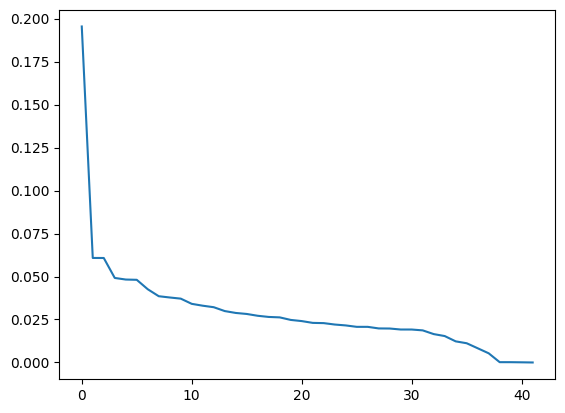

In [305]:
plt.plot(pd.Series(XGBb.get_feature_importances()).sort_values(ascending=False).values)

In [306]:
fi = pd.Series(XGBb.get_feature_importances())
fi[fi == 0.0].keys()

Index(['AvgLen'], dtype='object')

In [302]:
# these are GK features. Removing and updating gk features in the class, and rerunning

False

In [315]:
XGBb = XGBWrapper(xtrain_merged, new_features, use_gk=True, gk_df=gk_df, use_coords=True)
XGBb.fit(X_train, y_train)
y_pred = XGBb.predict(X_test)
mse = mean_squared_error(y_test[['home_score', 'away_score']].values, y_pred)
mae = mean_absolute_error(y_test[['home_score', 'away_score']].values, y_pred)
r2 = r2_score(y_test[['home_score', 'away_score']].values, y_pred)
print(f"XGB Wrapper Model: MSE: {mse}, MAE: {mae}, R2: {r2}")

(304, 788) <class 'numpy.ndarray'> (304, 9) <class 'pandas.core.frame.DataFrame'>
XGB Wrapper Model: MSE: 1.6641108989715576, MAE: 1.0135605335235596, R2: -0.06326818466186523


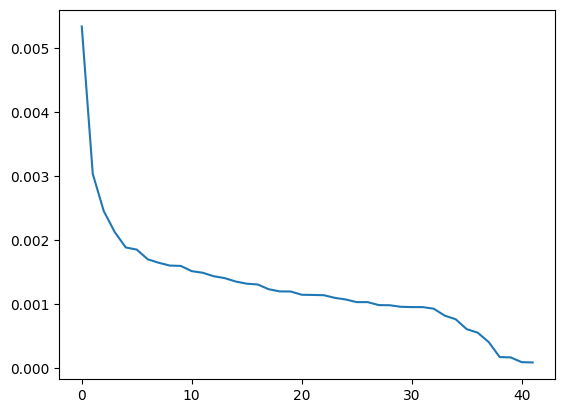

In [316]:
plt.plot(pd.Series(XGBb.get_feature_importances()).sort_values(ascending=False).values)

In [317]:
fi = pd.Series(XGBb.get_feature_importances())
fi.sort_values(ascending=False).tail(20)

Succ%       0.001145
Lost        0.001104
PrgC        0.001078
Mis         0.001036
Gls         0.001036
TI          0.000990
Mid 3rd     0.000988
Rec         0.000963
Won%        0.000959
Att 3rd     0.000958
PPA         0.000934
Def 3rd     0.000826
Touches     0.000769
Recov       0.000614
Fls         0.000559
Out         0.000413
GA          0.000178
Att (GK)    0.000173
AvgDist     0.000099
Stp%        0.000094
dtype: float64

In [318]:
# Bottom 4 are GK features. Removing and updating gk features in the class, and rerunning

(304, 782) <class 'numpy.ndarray'> (304, 9) <class 'pandas.core.frame.DataFrame'>
XGB Wrapper Model: MSE: 1.7206512689590454, MAE: 1.041597843170166, R2: -0.09846854209899902
TI             0.001209
Carries        0.001191
Mis            0.001157
familiarity    0.001148
SoT            0.001145
Def Pen        0.001129
Crs            0.001127
PrgR           0.001122
PrgC           0.001093
Won%           0.001073
Mid 3rd        0.001012
Touches        0.001005
Rec            0.000990
GCA            0.000966
KP             0.000959
PPA            0.000936
Def 3rd        0.000777
SCA            0.000717
Recov          0.000542
Save%          0.000233
dtype: float64


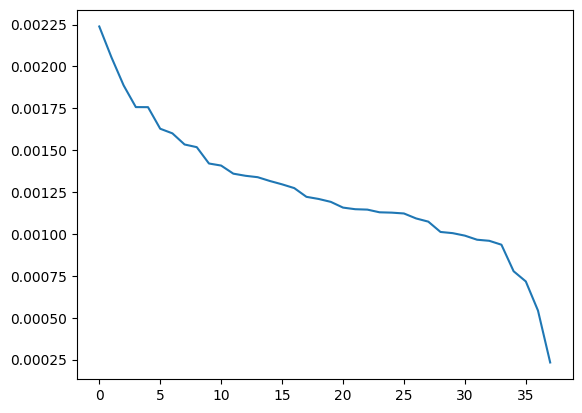

In [331]:
XGBb = XGBWrapper(xtrain_merged, new_features, use_gk=True, gk_df=gk_df, use_coords=True)
XGBb.fit(X_train, y_train)
y_pred = XGBb.predict(X_test)
mse = mean_squared_error(y_test[['home_score', 'away_score']].values, y_pred)
mae = mean_absolute_error(y_test[['home_score', 'away_score']].values, y_pred)
r2 = r2_score(y_test[['home_score', 'away_score']].values, y_pred)
print(f"XGB Wrapper Model: MSE: {mse}, MAE: {mae}, R2: {r2}")
plt.plot(pd.Series(XGBb.get_feature_importances()).sort_values(ascending=False).values)
fi = pd.Series(XGBb.get_feature_importances())
print(fi.sort_values(ascending=False).tail(20))

In [332]:
new_features.remove('Recov')

(304, 762) <class 'numpy.ndarray'> (304, 9) <class 'pandas.core.frame.DataFrame'>
XGB Wrapper Model: MSE: 1.6877937316894531, MAE: 1.0239439010620117, R2: -0.07782894372940063
Tkld%      0.001319
PrgC       0.001255
SoT        0.001246
Succ%      0.001240
Rec        0.001200
CrsPA      0.001195
Lost       0.001129
Carries    0.001093
Cmp%       0.001069
Gls        0.001053
PPA        0.001002
Att 3rd    0.000998
Mid 3rd    0.000944
TI         0.000906
Won%       0.000890
Mis        0.000854
Def 3rd    0.000783
Touches    0.000622
Fls        0.000618
Out        0.000376
dtype: float64


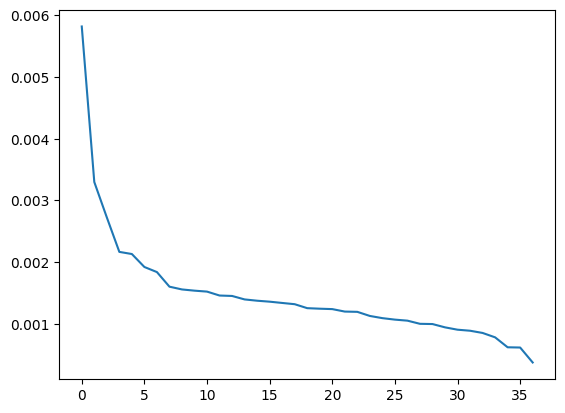

In [337]:
XGBb = XGBWrapper(xtrain_merged, new_features, use_gk=True, gk_df=gk_df, use_coords=True)
XGBb.fit(X_train, y_train)
y_pred = XGBb.predict(X_test)
mse = mean_squared_error(y_test[['home_score', 'away_score']].values, y_pred)
mae = mean_absolute_error(y_test[['home_score', 'away_score']].values, y_pred)
r2 = r2_score(y_test[['home_score', 'away_score']].values, y_pred)
print(f"XGB Wrapper Model: MSE: {mse}, MAE: {mae}, R2: {r2}")
plt.plot(pd.Series(XGBb.get_feature_importances()).sort_values(ascending=False).values)
fi = pd.Series(XGBb.get_feature_importances())
print(fi.sort_values(ascending=False).tail(20))

In [339]:
new_features.remove('Out')

(304, 742) <class 'numpy.ndarray'> (304, 9) <class 'pandas.core.frame.DataFrame'>
XGB Wrapper Model: MSE: 1.692375898361206, MAE: 1.0254051685333252, R2: -0.07956451177597046
Crs        0.001338
Gls        0.001332
CrsPA      0.001296
Tkld%      0.001259
Rec        0.001233
PrgC       0.001185
Cmp%       0.001076
PPA        0.001069
Touches    0.001054
Att 3rd    0.001052
Won%       0.001046
Carries    0.001003
Succ%      0.000994
Tkl+Int    0.000890
Mis        0.000848
Def 3rd    0.000829
TI         0.000815
In         0.000807
Fls        0.000762
Mid 3rd    0.000682
dtype: float64


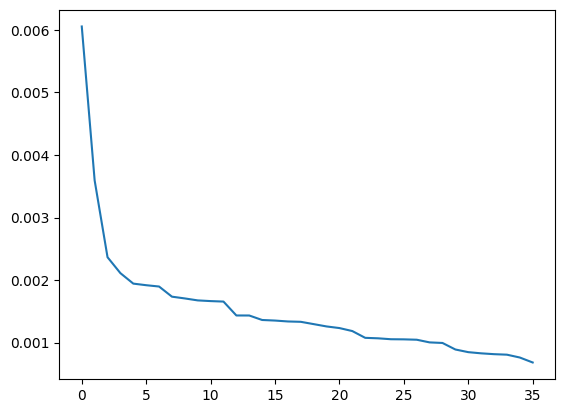

In [340]:
XGBb = XGBWrapper(xtrain_merged, new_features, use_gk=True, gk_df=gk_df, use_coords=True)
XGBb.fit(X_train, y_train)
y_pred = XGBb.predict(X_test)
mse = mean_squared_error(y_test[['home_score', 'away_score']].values, y_pred)
mae = mean_absolute_error(y_test[['home_score', 'away_score']].values, y_pred)
r2 = r2_score(y_test[['home_score', 'away_score']].values, y_pred)
print(f"XGB Wrapper Model: MSE: {mse}, MAE: {mae}, R2: {r2}")
plt.plot(pd.Series(XGBb.get_feature_importances()).sort_values(ascending=False).values)
fi = pd.Series(XGBb.get_feature_importances())
print(fi.sort_values(ascending=False).tail(20))

In [341]:
# removing 3rd features
new_features.remove('Def 3rd')
new_features.remove('Mid 3rd')
new_features.remove('Att 3rd')

(304, 682) <class 'numpy.ndarray'> (304, 9) <class 'pandas.core.frame.DataFrame'>
XGB Wrapper Model: MSE: 1.662629246711731, MAE: 1.011820912361145, R2: -0.059673845767974854
PrgC           0.001513
TotDist        0.001404
PPA            0.001402
Blocks         0.001377
Crs            0.001302
familiarity    0.001273
Tkld%          0.001267
Clr            0.001246
Cmp%           0.001220
Carries        0.001202
Tkl+Int        0.001182
Lost           0.001129
In             0.001097
Succ%          0.001056
TI             0.000945
Mis            0.000934
CrsPA          0.000902
Won%           0.000894
Fls            0.000789
Touches        0.000600
dtype: float64


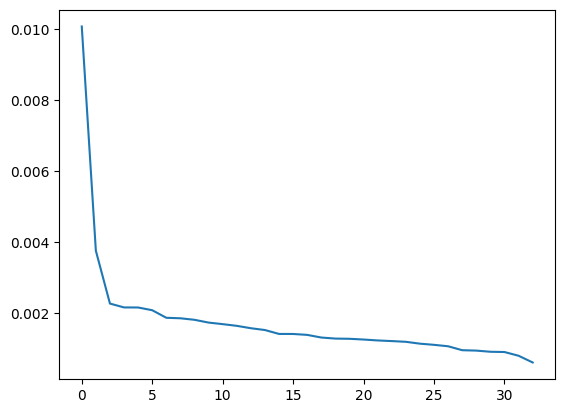

In [342]:
XGBb = XGBWrapper(xtrain_merged, new_features, use_gk=True, gk_df=gk_df, use_coords=True)
XGBb.fit(X_train, y_train)
y_pred = XGBb.predict(X_test)
mse = mean_squared_error(y_test[['home_score', 'away_score']].values, y_pred)
mae = mean_absolute_error(y_test[['home_score', 'away_score']].values, y_pred)
r2 = r2_score(y_test[['home_score', 'away_score']].values, y_pred)
print(f"XGB Wrapper Model: MSE: {mse}, MAE: {mae}, R2: {r2}")
plt.plot(pd.Series(XGBb.get_feature_importances()).sort_values(ascending=False).values)
fi = pd.Series(XGBb.get_feature_importances())
print(fi.sort_values(ascending=False).tail(20))

In [343]:
# run a training experiment with all the models and new feature set

In [ ]:
run_train(xtrain_merged, ytrain, new_features, use_gk=True, gk_df=gk_df, use_coords=False)

Model: XGB, MSE: 1.5993314743041993, MAE: 0.985647451877594, R2: -0.05983882546424866
Model: LinearRegression, MSE: 4.654338962651598, MAE: 1.6676117448074166, R2: -2.1302186014853244
Model: MLP, MSE: 2.7660452893299996, MAE: 1.2868710221503876, R2: -0.8185343467548073


(0.985647451877594,
 {'XGB': {'MSE': 1.5993314743041993,
   'MAE': 0.985647451877594,
   'R2': -0.05983882546424866},
  'LinearRegression': {'MSE': 4.654338962651598,
   'MAE': 1.6676117448074166,
   'R2': -2.1302186014853244},
  'MLP': {'MSE': 2.7660452893299996,
   'MAE': 1.2868710221503876,
   'R2': -0.8185343467548073}})

: 

In [345]:
run_train(xtrain_merged, ytrain, new_features, use_gk=True, gk_df=gk_df, use_coords=True)

Model: XGB, MSE: 1.5737587690353394, MAE: 0.9810117244720459, R2: -0.03950628638267517
Model: LinearRegression, MSE: 4.218273453918874, MAE: 1.6003398874973673, R2: -1.8167229427248794
Model: MLP, MSE: 2.565741864529687, MAE: 1.2552752051643732, R2: -0.71851790978262


(0.9810117244720459,
 {'XGB': {'MSE': 1.5737587690353394,
   'MAE': 0.9810117244720459,
   'R2': -0.03950628638267517},
  'LinearRegression': {'MSE': 4.218273453918874,
   'MAE': 1.6003398874973673,
   'R2': -1.8167229427248794},
  'MLP': {'MSE': 2.565741864529687,
   'MAE': 1.2552752051643732,
   'R2': -0.71851790978262}})

In this notebook, we implement feature selection using Variance threshold and Recurrent feature selection based on feature importance. The best MAE we able to achieve around 0.98 for XGB model. For LR, the best MAE achieved was 1.6. This error is on the higher end of what is desired, but due to high input feature set and limited training sample we will document the results and move to generating insights using weights assigned by our LR model in the next notebook.